In [1]:
################################################
# IMPORTS
################################################

# Standard libraries
import os
import re
import shutil
import joblib
import warnings
import math
from math import pi
from pathlib import Path
from datetime import date
from collections import Counter
from typing import Iterable, List, Optional, Tuple, Set, Dict

# Scientific & Data libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import requests
import unicodedata
import difflib
from concurrent.futures import ThreadPoolExecutor
from haversine import haversine, Unit
from scipy.stats import ks_2samp, wasserstein_distance
from skimage.feature import shape_index
from rapidfuzz import process, fuzz
import gmpy2
import missingno as msno

# Kaggle API
from kaggle.api.kaggle_api_extended import KaggleApi

# Reload utils module (if custom utility functions exist)
import utils
import importlib
importlib.reload(utils)

# Scikit-learn & imbalanced-learn
from imblearn.over_sampling import SMOTE
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    RobustScaler,
    StandardScaler,
    MinMaxScaler,
    OneHotEncoder,
    LabelEncoder
)
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    GridSearchCV,
    RandomizedSearchCV,
    validation_curve
)
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    roc_auc_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    RocCurveDisplay,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    f1_score,
    confusion_matrix,
    classification_report,
    PrecisionRecallDisplay,
    ConfusionMatrixDisplay,
    accuracy_score
)

# Gradient boosting libraries
import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

################################################
# GENERAL SETTINGS
################################################

# Ignore warnings
warnings.filterwarnings("ignore")

# Pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)


In [2]:
#api = KaggleApi()
#api.authenticate()

#api.dataset_download_files('olistbr/brazilian-ecommerce', path='./dataset', unzip=True)

In [3]:
base_path = os.path.join(os.getcwd(), "dataset")

file_name_customers = "olist_customers_dataset.csv"
file_name_geolocation = "olist_geolocation_dataset.csv"
file_name_orderitems = "olist_order_items_dataset.csv"
file_name_orderpayments = "olist_order_payments_dataset.csv"
file_name_orderreviews = "olist_order_reviews_dataset.csv"
file_name_orders = "olist_orders_dataset.csv"
file_name_products = "olist_products_dataset.csv"
file_name_sellers = "olist_sellers_dataset.csv"
file_name_category_name_translation = "product_category_name_translation.csv"


# Full path
customers_path = os.path.join(base_path, file_name_customers)
geolocation_path = os.path.join(base_path, file_name_geolocation)
orderitems_path = os.path.join(base_path, file_name_orderitems)
orderpayments_path = os.path.join(base_path, file_name_orderpayments)
orderreviews_path = os.path.join(base_path, file_name_orderreviews)
orders_path = os.path.join(base_path, file_name_orders)
products_path = os.path.join(base_path, file_name_products)
sellers_path = os.path.join(base_path, file_name_sellers)
product_category_name_translation_path = os.path.join(base_path, file_name_category_name_translation)



In [4]:
df_customers = utils.load(customers_path)
df_geo_avg = utils.load(geolocation_path)

In [5]:
summary = (
    df_geo_avg.groupby("geolocation_zip_code_prefix")
    .agg(
        city_count=("geolocation_city", "nunique"),     # kaç farklı şehir var
        state_count=("geolocation_state", "nunique"),   # kaç farklı eyalet var
        coord_count=("geolocation_lat", "count"),       # toplam satır sayısı (koordinat sayısı)
        lat_std=("geolocation_lat", "std"),             # enlem sapması
        lng_std=("geolocation_lng", "std")              # boylam sapması
    )
    .reset_index()
)

summary.head()


,geolocation_zip_code_prefix,city_count,state_count,coord_count,lat_std,lng_std
0,1001,2,1,26,0.001,0.000
1,1002,2,1,13,0.001,0.001
2,1003,2,1,17,0.000,0.001
3,1004,2,1,22,0.001,0.000
4,1005,2,1,25,0.000,0.001


In [6]:
# Calculate 95th percentile thresholds for latitude and longitude standard deviations
lat_thresh = summary['lat_std'].quantile(0.95)
lng_thresh = summary['lng_std'].quantile(0.95)

# Select zip codes with high variability (wide area zips)
wide_zips = summary[
    (summary['lat_std'] > lat_thresh) |
    (summary['lng_std'] > lng_thresh)
]

# Display results
print("95th percentile threshold for lat_std:", lat_thresh)
print("95th percentile threshold for lng_std:", lng_thresh)
print("Number of zip codes above threshold:", len(wide_zips))

# Show top 10 wide-area zip codes
wide_zips.head(10)

95th percentile threshold for lat_std: 0.04056525284991052
95th percentile threshold for lng_std: 0.045473794164270054
Number of zip codes above threshold: 1272


,geolocation_zip_code_prefix,city_count,state_count,coord_count,lat_std,lng_std
130,1239,2,1,152,0.012,0.066
202,1417,2,1,86,0.026,0.079
215,1430,2,1,11,0.145,0.013
216,1431,2,1,13,0.117,0.011
257,1513,1,1,24,0.023,0.072
406,2169,2,1,45,0.106,0.071
458,2237,1,1,8,0.136,0.045
508,2290,2,1,3,0.109,0.047
531,2323,2,1,56,0.044,0.053
532,2324,2,1,48,0.087,0.033


In [7]:
# Select relevant columns from summary
zip_summary = summary[['geolocation_zip_code_prefix', 'city_count', 'state_count']].copy()

# Function to classify zip codes based on city and state coverage
def zip_type(row):
    if row['state_count'] > 1:
        return 'Different states'
    elif row['state_count'] == 1 and row['city_count'] > 1:
        return 'Multiple cities in same state'
    else:
        return 'Single city, single state'

# Apply classification
zip_summary['type'] = zip_summary.apply(zip_type, axis=1)

# Sort by state_count and city_count (descending)
zip_summary_sorted = zip_summary.sort_values(
    by=['state_count', 'city_count'], 
    ascending=[False, False]
).reset_index(drop=True)

# Show top 10
zip_summary_sorted.head(10)


,geolocation_zip_code_prefix,city_count,state_count,type
0,72915,3,2,Different states
1,2116,2,2,Different states
2,4011,2,2,Different states
3,78557,2,2,Different states
4,80630,2,2,Different states
5,21550,1,2,Different states
6,23056,1,2,Different states
7,79750,1,2,Different states
8,6900,5,1,Multiple cities in same state
9,13318,5,1,Multiple cities in same state


In [8]:
# Zip codes with multiple cities in the same state
same_state_multi_city = zip_summary_sorted[
    (zip_summary_sorted['state_count'] == 1) & 
    (zip_summary_sorted['city_count'] > 1)
]
same_state_multi_city_count = same_state_multi_city.shape[0]

# Zip codes spanning multiple states
multi_state = zip_summary_sorted[zip_summary_sorted['state_count'] > 1]
multi_state_count = multi_state.shape[0]

same_state_multi_city_count, multi_state_count


(8551, 8)

In [9]:
# Zip codes that span multiple states
multi_state_zips = zip_summary_sorted[zip_summary_sorted['state_count'] > 1]

# Display the first 10 rows
multi_state_zips.head(10)

# To see the full list, simply use:
multi_state_zips

,geolocation_zip_code_prefix,city_count,state_count,type
0,72915,3,2,Different states
1,2116,2,2,Different states
2,4011,2,2,Different states
3,78557,2,2,Different states
4,80630,2,2,Different states
5,21550,1,2,Different states
6,23056,1,2,Different states
7,79750,1,2,Different states


In [10]:
state_counts = df_geo_avg.groupby('geolocation_zip_code_prefix')['geolocation_state'].nunique()
zip_diff_states = state_counts[state_counts > 1].reset_index()
zip_diff_states = zip_diff_states.merge(
    df_geo_avg.groupby('geolocation_zip_code_prefix')['geolocation_state'].unique().reset_index(),
    on='geolocation_zip_code_prefix'
)
zip_diff_states = zip_diff_states.rename(columns={'geolocation_state': 'states'})
zip_diff_states

,geolocation_zip_code_prefix,geolocation_state_x,geolocation_state_y
0,2116,2,"[SP, RN]"
1,4011,2,"[SP, AC]"
2,21550,2,"[RJ, AC]"
3,23056,2,"[RJ, AC]"
4,72915,2,"[GO, DF]"
5,78557,2,"[MT, RO]"
6,79750,2,"[MS, RS]"
7,80630,2,"[PR, SC]"


In [11]:
city_counts = df_geo_avg.groupby('geolocation_zip_code_prefix')['geolocation_city'].nunique()
zip_same_state_diff_city = city_counts[(city_counts > 1) & (df_geo_avg.groupby('geolocation_zip_code_prefix')['geolocation_state'].nunique() == 1)]
zip_same_state_diff_city = zip_same_state_diff_city.reset_index()
zip_same_state_diff_city = zip_same_state_diff_city.merge(
    df_geo_avg.groupby('geolocation_zip_code_prefix')['geolocation_city'].unique().reset_index(),
    on='geolocation_zip_code_prefix'
)
zip_same_state_diff_city = zip_same_state_diff_city.rename(columns={'geolocation_city': 'cities'})
zip_same_state_diff_city.head()

,geolocation_zip_code_prefix,geolocation_city_x,geolocation_city_y
0,1001,2,"[sao paulo, são paulo]"
1,1002,2,"[sao paulo, são paulo]"
2,1003,2,"[sao paulo, são paulo]"
3,1004,2,"[sao paulo, são paulo]"
4,1005,2,"[sao paulo, são paulo]"


In [12]:
# Aggregate state and city information for each zip code
zip_info = (
    df_geo_avg
    .groupby('geolocation_zip_code_prefix')
    .agg(
        state_count=('geolocation_state', 'nunique'),
        states=('geolocation_state', lambda x: list(x.unique())),
        max_city_count=('geolocation_city', lambda x: x.nunique())  # number of unique cities per zip code
    )
    .reset_index()
)

# Sort by state_count first, then by max_city_count
zip_info_sorted = zip_info.sort_values(
    by=['state_count', 'max_city_count'], 
    ascending=[False, False]
).reset_index(drop=True)

# Display the first 10 rows
zip_info_sorted.head(10)

,geolocation_zip_code_prefix,state_count,states,max_city_count
0,72915,2,"[GO, DF]",3
1,2116,2,"[SP, RN]",2
2,4011,2,"[SP, AC]",2
3,78557,2,"[MT, RO]",2
4,80630,2,"[PR, SC]",2
5,21550,2,"[RJ, AC]",1
6,23056,2,"[RJ, AC]",1
7,79750,2,"[MS, RS]",1
8,6900,1,[SP],5
9,13318,1,[SP],5


In [13]:
df_orderitems = utils.load(orderitems_path)
df_orderpayments = utils.load(orderpayments_path)
df_orderreviews = utils.load(orderreviews_path)
df_orders = utils.load(orders_path)
df_products = utils.load(products_path)
df_sellers = utils.load(sellers_path)

### Detection of duplicate cities and states due to different spellings

In [14]:
# 1. Advanced city normalization
def normalize_city_advanced(name: str) -> str:
    """
    Normalizes city names to handle duplicates caused by spelling variations.

    Steps:
    - Convert to lowercase
    - Remove accents
    - Remove punctuation, spaces, hyphens, apostrophes, and quotes
    """
    if pd.isna(name):
        return ""
    name = name.strip().lower()
    # Remove accents
    name = ''.join(c for c in unicodedata.normalize('NFD', name) if unicodedata.category(c) != 'Mn')
    # Remove dots, hyphens, apostrophes, spaces, and quotes
    name = re.sub(r'[\s\.\-\'"]', '', name)
    return name


In [15]:
# 2. Group similar cities and deduplicate
def deduplicate_cities(city_list, threshold: float = 0.9) -> dict:
    """
    Groups similar city names and maps them to a single canonical name.

    Parameters:
    - city_list: list of city names (already normalized)
    - threshold: similarity threshold (0-1) above which two cities are considered the same

    Returns:
    - A dictionary mapping each city name to its canonical (deduplicated) version
    """
    mapping = {}
    for i, city in enumerate(city_list):
        if city not in mapping:
            mapping[city] = city  # use the first occurrence as reference
        for other in city_list[i+1:]:
            similarity = difflib.SequenceMatcher(None, city, other).ratio()
            if similarity >= threshold:
                mapping[other] = mapping[city]
    return mapping


In [16]:
# 3. Main function (city + state)
def clean_city_names(df, city_col, state_col, similarity_threshold=0.9):
    """
    Normalizes all city names and deduplicates similar city names within each state.
    
    Parameters:
    - df: pandas DataFrame containing city and state columns
    - city_col: name of the city column
    - state_col: name of the state column
    - similarity_threshold: similarity ratio above which two city names are considered identical

    Returns:
    - DataFrame with cleaned city names
    """
    # Create a normalized city column
    df['city_norm'] = df[city_col].apply(normalize_city_advanced)

    # List of unique cities per state
    state_cities = (
        df.groupby(state_col)['city_norm']
        .unique()
        .reset_index()
        .rename(columns={'city_norm': 'cities'})
    )

    # Generate state-based deduplication mappings
    all_mappings = {}
    for idx, row in state_cities.iterrows():
        state = row[state_col]
        city_list = list(row['cities'])
        mapping = deduplicate_cities(city_list, threshold=similarity_threshold)
        for raw_city, clean_city in mapping.items():
            all_mappings[(state, raw_city)] = clean_city

    # Update original DataFrame with cleaned city names
    df[city_col] = df.apply(
        lambda row: all_mappings.get((row[state_col], row['city_norm']), row['city_norm']),
        axis=1
    )

    # Drop temporary normalized column
    df = df.drop(columns=['city_norm'])
    
    return df


In [17]:
df_geo_avg = clean_city_names(df_geo_avg, city_col='geolocation_city', state_col='geolocation_state')

In [18]:
df_customers = clean_city_names(df_customers, city_col='customer_city', state_col='customer_state')

In [19]:
df_sellers = clean_city_names(df_sellers, city_col='seller_city', state_col='seller_state')

## Check for remaining duplicate city names per state

In [20]:
def check_remaining_similar_cities(df, city_col, state_col, threshold=0.9):
    """
    Checks if there are still similar city names remaining in the cleaned dataset.
    """
    # Get unique cities per state
    state_cities = (
        df.groupby(state_col)[city_col]
        .unique()
        .reset_index()
        .rename(columns={city_col: 'cities'})
    )

    all_duplicates = {}
    for _, row in state_cities.iterrows():
        state = row[state_col]
        cities = row['cities']
        duplicates = []
        for i, city in enumerate(cities):
            for other in cities[i+1:]:
                similarity = difflib.SequenceMatcher(None, city, other).ratio()
                if similarity >= threshold:
                    duplicates.append((city, other, similarity))
        if duplicates:
            all_duplicates[state] = duplicates

    if not all_duplicates:
        print("✅ No duplicate or similar city names remain.")
    else:
        for state, duplicates in all_duplicates.items():
            print(f"\nState: {state}")
            for dup in duplicates:
                print(f" - {dup[0]} ~ {dup[1]} (similarity: {dup[2]:.2f})")



In [21]:
check_remaining_similar_cities(df_geo_avg, city_col='geolocation_city', state_col='geolocation_state' )

✅ No duplicate or similar city names remain.


In [22]:
check_remaining_similar_cities(df_sellers, city_col='seller_city', state_col='seller_state' )

✅ No duplicate or similar city names remain.


In [23]:
check_remaining_similar_cities(df_customers, city_col='customer_city', state_col='customer_state' )

✅ No duplicate or similar city names remain.


# DATA MODELING

### 1- Create prefixed IDs for tables that already have an original ID column

In [24]:
# Prefiksli ID oluşturma (ID olan tablolar)
def create_prefixed_id(df, original_id_col, new_id_col, prefix):
    """
    Generates new IDs with a prefix based on an existing ID column.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame
        original_id_col (str): Existing ID column
        new_id_col (str): Name of the new ID column
        prefix (str): Prefix for new IDs (e.g., 'CUST', 'PROD')
    
    Returns:
        df (pd.DataFrame): DataFrame with new prefixed ID column
        id_map (dict): Mapping from old ID to new prefixed ID
    """
    df = df.copy()
    id_map = {old_id: f"{prefix}{str(i+1).zfill(3)}" for i, old_id in enumerate(df[original_id_col])}
    df[new_id_col] = df[original_id_col].map(id_map)
    return df, id_map


# 2. Create prefixed IDs for tables without an existing ID column
def create_prefixed_id_no_col(df, new_id_col, prefix):
    """
    Generates new prefixed IDs for a DataFrame without an existing ID column.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame
        new_id_col (str): Name of the new ID column
        prefix (str): Prefix for new IDs
    
    Returns:
        df (pd.DataFrame): DataFrame with new prefixed ID column
    """
    df = df.copy()
    df[new_id_col] = [f"{prefix}{str(i+1).zfill(3)}" for i in range(len(df))]
    return df


### 2- Convert PKs to Prefixed IDs and Store Mappings

In [25]:
# Sellers
df_sellers, seller_id_map = create_prefixed_id(df_sellers, "seller_id", "seller_id_pref", "SEL")

# Orders
df_orders, order_id_map = create_prefixed_id(df_orders, "order_id", "order_id_pref", "ORD")

# Products
df_products, product_id_map = create_prefixed_id(df_products, "product_id", "product_id_pref", "PRO")

# Customers
df_customers, customers_id_map = create_prefixed_id(df_customers, "customer_id", "customer_id_pref", "CUS")


# Order Items (no existing ID column but keeping order item number)
df_orderitems = df_orderitems.rename(columns={"order_item_id": "order_item_number"})  # Not a PK
df_orderitems = create_prefixed_id_no_col(df_orderitems, "order_item_pref", "OIT")

# Order Payments (no existing ID column)
df_orderpayments = create_prefixed_id_no_col(df_orderpayments, "orderpayment_id_pref", "PAY")

# Geolocation (no existing ID column)
df_geo_avg = create_prefixed_id_no_col(df_geo_avg, "geolocation_id_pref", "GEO")

# Add prefixed customer IDs to Orders
df_orders["customer_id_pref"] = df_orders["customer_id"].map(customers_id_map)

# Add prefixed IDs to Order Items
df_orderitems["order_id_pref"] = df_orderitems["order_id"].map(order_id_map)
df_orderitems["product_id_pref"] = df_orderitems["product_id"].map(product_id_map)
df_orderitems["seller_id_pref"] = df_orderitems["seller_id"].map(seller_id_map)

# Add prefixed order IDs to Order Payments
df_orderpayments["order_id_pref"] = df_orderpayments["order_id"].map(order_id_map)

# Check for missing mappings
print("Missing customer_id_pref in Orders:", df_orders["customer_id_pref"].isnull().sum())
print("Missing order_id_pref in Order Items:", df_orderitems["order_id_pref"].isnull().sum())
print("Missing product_id_pref in Order Items:", df_orderitems["product_id_pref"].isnull().sum())
print("Missing seller_id_pref in Order Items:", df_orderitems["seller_id_pref"].isnull().sum())
print("Missing order_id_pref in Order Payments:", df_orderpayments["order_id_pref"].isnull().sum())

Missing customer_id_pref in Orders: 0
Missing order_id_pref in Order Items: 0
Missing product_id_pref in Order Items: 0
Missing seller_id_pref in Order Items: 0
Missing order_id_pref in Order Payments: 0


In [26]:
# 1. Get a unique list of customer_unique_id
unique_customers = df_customers[['customer_unique_id']].drop_duplicates().reset_index(drop=True)

# 2. Create new prefixed ID
unique_customers['cusUni'] = [f"CUSUNI{str(i+1).zfill(4)}" for i in range(len(unique_customers))]

# 3. Merge the new ID back to the original dataframe
df_customers = df_customers.merge(unique_customers, on='customer_unique_id', how='left')


In [27]:
# 1. Count how many unique 'cusUni' each 'customer_unique_id' maps to
check_unique = df_customers.groupby('customer_unique_id')['cusUni'].nunique().reset_index()
check_unique.rename(columns={'cusUni': 'num_unique_ids'}, inplace=True)

# 2. Identify any 'customer_unique_id' that maps to more than one 'cusUni'
problem_customers = check_unique[check_unique['num_unique_ids'] != 1]

if problem_customers.empty:
    print("All customer_unique_id values correctly map to a single new ID.")
else:
    print("Warning! Some customer_unique_id values map to multiple new IDs:")
    print(problem_customers)


All customer_unique_id values correctly map to a single new ID.


In [28]:
# Original ID columns to drop
drop_cols = {
    "customers": ["customer_id", "customer_unique_id"],
    "sellers": ["seller_id"],
    "orders": ["order_id", "customer_id"],
    "order_items": ["order_id", "product_id", "seller_id"],
    "products": ["product_id"],
    "order_payments": ["orderpayment_id", "order_id"],
    "df_geo_avg": []
}

# Corresponding DataFrames
dfs = {
    "customers": df_customers,
    "sellers": df_sellers,
    "orders": df_orders,
    "order_items": df_orderitems,
    "products": df_products,
    "order_payments": df_orderpayments,
    "df_geo_avg": df_geo_avg
}

# Drop original ID columns from each DataFrame
for name, df in dfs.items():
    cols_to_drop = [c for c in drop_cols[name] if c in df.columns]
    dfs[name] = df.drop(columns=cols_to_drop)

# Update individual DataFrames
(df_customers, df_sellers, df_orders, df_orderitems,
 df_products, df_orderpayments, df_geo_avg) = [dfs[k] for k in dfs]

In [29]:
def move_prefixed_id_first(df, prefixed_id_col, fk_cols=None):
    """
    Reorders DataFrame columns:
    - Primary Key (prefixed_id_col) first
    - Then Foreign Key columns (fk_cols list)
    - Then all other columns
    """
    df = df.copy()
    if fk_cols is None:
        fk_cols = []
    cols = [prefixed_id_col] + fk_cols + [c for c in df.columns if c not in ([prefixed_id_col] + fk_cols)]
    return df[cols]

# Move prefixed IDs to the front, foreign keys also first
df_customers     = move_prefixed_id_first(df_customers, "customer_id_pref")
df_sellers       = move_prefixed_id_first(df_sellers, "seller_id_pref")
df_orders        = move_prefixed_id_first(df_orders, "order_id_pref", fk_cols=["customer_id_pref"])
df_orderitems    = move_prefixed_id_first(df_orderitems, "order_item_pref", fk_cols=["order_id_pref", "product_id_pref", "seller_id_pref"])
df_products      = move_prefixed_id_first(df_products, "product_id_pref")
df_orderpayments = move_prefixed_id_first(df_orderpayments, "orderpayment_id_pref", fk_cols=["order_id_pref"])
df_geo_avg       = move_prefixed_id_first(df_geo_avg, "geolocation_id_pref")


In [30]:
df_geolocation = df_geo_avg

# 1. Compute average coordinates per zip code (geo_avg)
df_geo_avg = (
    df_geolocation
    .groupby("geolocation_zip_code_prefix")[["geolocation_lat", "geolocation_lng"]]
    .mean()
    .reset_index()
    .rename(columns={
        "geolocation_zip_code_prefix": "zip_prefix",
        "geolocation_lat": "lat_avg",
        "geolocation_lng": "lng_avg"
    })
)

# 2. Add average coordinates to CUSTOMERS table
df_customers = df_customers.merge(
    df_geo_avg,
    left_on="customer_zip_code_prefix",
    right_on="zip_prefix",
    how="left"
).drop(columns=["zip_prefix"])  # temporary column not needed

# 3. Add average coordinates to SELLERS table
df_sellers = df_sellers.merge(
    df_geo_avg,
    left_on="seller_zip_code_prefix",
    right_on="zip_prefix",
    how="left"
).drop(columns=["zip_prefix"])

In [31]:
df_customers = df_customers.rename(columns={
    'lat_avg': 'customer_lat_avg',
    'lng_avg': 'customer_lng_avg'
})

In [32]:
df_sellers = df_sellers.rename(columns={
    'lat_avg': 'seller_lat_avg',
    'lng_avg': 'seller_lng_avg'
})

In [33]:
df_orders = df_orders.rename(columns={"customer_id_pref": "customer_order_id"})

In [34]:
# Folder to save cleaned tables with prefixed IDs
prefix_id_path = Path.cwd() / "cleaned_data_with_prefix_id"

# Reset the folder each time (delete if exists, then recreate)
if prefix_id_path.exists():
    shutil.rmtree(prefix_id_path)
prefix_id_path.mkdir(parents=True, exist_ok=True)

# DataFrames to save
dfs = {
    "customers": df_customers,
    "sellers": df_sellers,
    "orders": df_orders,
    "order_items": df_orderitems,
    "products": df_products,
    "order_payments": df_orderpayments,
    "geo_avg": df_geo_avg,
    "geolocation": df_geolocation,
}

# Save as CSV
for name, df in dfs.items():
    file_path = prefix_id_path / f"{name}.csv"
    df.to_csv(file_path, index=False, sep=";", decimal=",")
    print(f"{file_path} saved. shape={df.shape}")


C:\Users\onayk\Desktop\EuroTech_Datascience\Proje\Git_Proje\cleaned_data_with_prefix_id\customers.csv saved. shape=(99441, 7)
C:\Users\onayk\Desktop\EuroTech_Datascience\Proje\Git_Proje\cleaned_data_with_prefix_id\sellers.csv saved. shape=(3095, 6)
C:\Users\onayk\Desktop\EuroTech_Datascience\Proje\Git_Proje\cleaned_data_with_prefix_id\orders.csv saved. shape=(99441, 8)
C:\Users\onayk\Desktop\EuroTech_Datascience\Proje\Git_Proje\cleaned_data_with_prefix_id\order_items.csv saved. shape=(112650, 8)
C:\Users\onayk\Desktop\EuroTech_Datascience\Proje\Git_Proje\cleaned_data_with_prefix_id\products.csv saved. shape=(32951, 9)
C:\Users\onayk\Desktop\EuroTech_Datascience\Proje\Git_Proje\cleaned_data_with_prefix_id\order_payments.csv saved. shape=(103886, 6)
C:\Users\onayk\Desktop\EuroTech_Datascience\Proje\Git_Proje\cleaned_data_with_prefix_id\geo_avg.csv saved. shape=(19015, 3)
C:\Users\onayk\Desktop\EuroTech_Datascience\Proje\Git_Proje\cleaned_data_with_prefix_id\geolocation.csv saved. shape=(

### Folder where cleaned CSVs were saved

In [35]:

base_path = os.path.join(os.getcwd(), "cleaned_data_with_prefix_id")

new_file_name_customers = "customers.csv"
new_file_name_geolocation = "geolocation.csv"
new_file_name_geo_avg = "geo_avg.csv"
new_file_name_orderitems = "order_items.csv"
new_file_name_orderpayments = "order_payments.csv"
new_file_name_orders = "orders.csv"
new_file_name_products = "products.csv"
new_file_name_sellers = "sellers.csv"

# Full path
new_customers_path = os.path.join(base_path, new_file_name_customers)
new_geolocation_path = os.path.join(base_path, new_file_name_geolocation)
new_geo_avg_path = os.path.join(base_path, new_file_name_geo_avg)
new_orderitems_path = os.path.join(base_path, new_file_name_orderitems)
new_orderpayments_path = os.path.join(base_path, new_file_name_orderpayments)
new_orders_path = os.path.join(base_path, new_file_name_orders)
new_products_path = os.path.join(base_path, new_file_name_products)
new_sellers_path = os.path.join(base_path, new_file_name_sellers)



In [36]:
df_customers = utils.load(new_customers_path,sep=";",decimal=",")
df_geolocation = utils.load(new_geolocation_path,sep=";",decimal=",")
df_orderitems = utils.load(new_orderitems_path,sep=";",decimal=",")
df_orderpayments = utils.load(new_orderpayments_path,sep=";",decimal=",")
df_orders = utils.load(new_orders_path,sep=";",decimal=",")
df_products = utils.load(new_products_path,sep=";",decimal=",")
df_sellers = utils.load(new_sellers_path,sep=";",decimal=",")
df_sellers.head()

,seller_id_pref,seller_zip_code_prefix,seller_city,seller_state,seller_lat_avg,seller_lng_avg
0,SEL001,13023,campinas,SP,-22.894,-47.061
1,SEL002,13844,mogiguacu,SP,-22.383,-46.948
2,SEL003,20031,riodejaneiro,RJ,-22.910,-43.178
3,SEL004,4195,saopaulo,SP,-23.657,-46.613
4,SEL005,12914,bragancapaulista,SP,-22.965,-46.534


### Detecting Multiple Payment Rows and Aggregating Payments

In the Payments table, some orders have multiple rows because:

The customer used more than one payment method for the same order.

Payments were made in installments.

To consolidate payments so that each order appears as a single row, you can create a DataFrame called pay_agg with aggregated values:

payment_types: If an order has multiple payment methods, they are combined into a single string separated by /.

payment_installment_max: For installment payments, the maximum number of installments is kept for potential installment-based analyses.

payment_value_sum: The total payment amount is summed to produce a single total payment per order.

This approach allows you to reduce multiple payment rows into a single row per order while retaining key information about payment types, maximum installments, and total payment value.

### Detecting and summarizing multiple payment rows

In [37]:
# Select orders with multiple payments
multi_pay_orders = (
    df_orderpayments
      .groupby("order_id_pref")
      .filter(lambda x: len(x) > 1)   # orders having more than 1 row
      .sort_values(["order_id_pref","payment_sequential"])
)

print("Number of orders with multiple payment records:",
      multi_pay_orders["order_id_pref"].nunique())

# Display the first 10 orders as example
multi_pay_orders.head(10)


Number of orders with multiple payment records: 2961


,orderpayment_id_pref,order_id_pref,payment_sequential,payment_type,payment_installments,payment_value
10770,PAY10771,ORD001,1,credit_card,1,18.120
91130,PAY91131,ORD001,2,voucher,1,18.590
44246,PAY44247,ORD001,3,voucher,1,2.000
52200,PAY52201,ORD010,1,credit_card,1,8.340
16545,PAY16546,ORD010,2,voucher,1,161.420
92279,PAY92280,ORD020,1,credit_card,1,5.960
35461,PAY35462,ORD020,2,voucher,1,62.150
42035,PAY42036,ORD020,3,voucher,1,24.860
76131,PAY76132,ORD078,1,credit_card,1,7.080
44840,PAY44841,ORD078,2,voucher,1,227.200


In [38]:
# Aggregate payment info per order
pay_agg = (
    df_orderpayments
    .groupby("order_id_pref", as_index=False)
    .agg(
        payment_value_sum=("payment_value", "sum"),          # sum all payments for the order
        payment_installments_max=("payment_installments", "max"),  # keep the maximum installment number
        payment_types=("payment_type", lambda s: "/".join(sorted(s.astype(str).unique())))  # combine payment methods
    )
)

# Identify orders with multiple payment rows (short version of previous step)
multi_orders = (
    df_orderpayments.groupby("order_id_pref")
    .size()
    .loc[lambda s: s > 1]
    .index
)

# Keep only orders with multiple payment rows in the aggregated table
pay_agg_multi = (
    pay_agg[pay_agg["order_id_pref"].isin(multi_orders)]
    .sort_values("order_id_pref")
)

print("Number of orders with multiple payment rows:", len(multi_orders))
pay_agg_multi.head(10)


Number of orders with multiple payment rows: 2961


,order_id_pref,payment_value_sum,payment_installments_max,payment_types
0,ORD001,38.710,1,credit_card/voucher
9,ORD010,169.760,1,credit_card/voucher
19,ORD020,92.970,1,credit_card/voucher
77,ORD078,234.280,1,credit_card/voucher
98,ORD099,28.860,1,credit_card/voucher
158,ORD10052,212.810,5,credit_card/voucher
243,ORD10129,182.360,5,credit_card/voucher
286,ORD10168,144.750,1,credit_card/voucher
287,ORD10169,126.300,1,credit_card/voucher
319,ORD10198,336.920,8,credit_card


### Creating the Fact Table and Performing Merge Operations

In [39]:
fact_DF = (
    df_orderitems
      .merge(df_orders, on="order_id_pref", how="left")
      .merge(df_customers, left_on="customer_order_id", right_on="customer_id_pref", how="left")
      .drop(columns=["customer_id_pref"])
      .merge(df_sellers, on="seller_id_pref", how="left")
      .merge(df_products, on="product_id_pref", how="left")
      .merge(pay_agg, on="order_id_pref", how="left") 
)

In [40]:
fact_DF.shape

(112650, 37)

### Converting date columns to datetime format

In [41]:
date_cols = [
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date',
    "order_purchase_timestamp"
]

for col in date_cols:
    fact_DF[col] = pd.to_datetime(fact_DF[col], errors='coerce')  # Hatalı tarihleri NaT yapar

### Calculating preparation and delivery times

In [42]:
fact_DF["prep_time"] = (
    fact_DF["order_delivered_carrier_date"] - fact_DF["order_approved_at"]
).dt.days

fact_DF["shipping_time"] = (
    fact_DF["order_delivered_customer_date"] - fact_DF["order_delivered_carrier_date"]
).dt.days

fact_DF["estimated_time"] = (
    fact_DF["order_estimated_delivery_date"] - fact_DF["order_approved_at"]
).dt.days

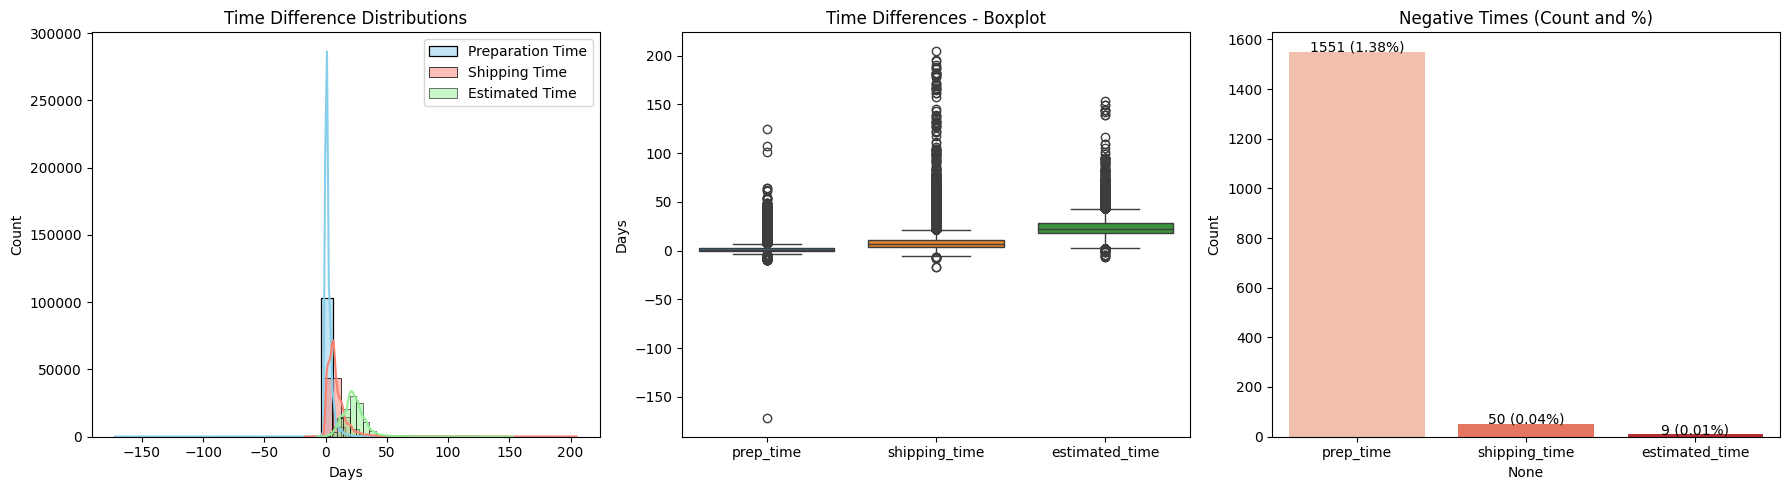

In [43]:
# Total number of rows
total_rows = fact_DF.shape[0]

# Negative values
neg_counts = fact_DF[["prep_time","shipping_time","estimated_time"]].lt(0).sum()
neg_perc   = (neg_counts / total_rows * 100).round(2)

# Create the plot
plt.figure(figsize=(18,5))

# --- Histogram ---
plt.subplot(1,3,1)
sns.histplot(fact_DF["prep_time"], kde=True, color="skyblue", label="Preparation Time", bins=30)
sns.histplot(fact_DF["shipping_time"], kde=True, color="salmon", label="Shipping Time", bins=30)
sns.histplot(fact_DF["estimated_time"], kde=True, color="lightgreen", label="Estimated Time", bins=30)
plt.title("Time Difference Distributions")
plt.xlabel("Days")
plt.ylabel("Count")
plt.legend()

# --- Boxplot ---
plt.subplot(1,3,2)
sns.boxplot(data=fact_DF[["prep_time", "shipping_time", "estimated_time"]])
plt.title("Time Differences - Boxplot")
plt.ylabel("Days")

# --- Negative Values Barplot ---
plt.subplot(1,3,3)
sns.barplot(x=neg_counts.index, y=neg_counts.values, palette="Reds")
for i, v in enumerate(neg_counts.values):
    plt.text(i, v + 1, f"{v} ({neg_perc[i]}%)", ha='center')
plt.title("Negative Times (Count and %)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


prep_time negative: It appears the order was shipped before being confirmed (could be a timestamp issue).

shipping_time negative: It looks like the customer received the product before it was shipped (likely a data error).

estimated_time negative: The estimated delivery date appears to be before the order confirmation date (incorrect record).

In [44]:
print(fact_DF.shape[0])
fact_DF[['prep_time', 'shipping_time', 'estimated_time']].isnull().mean() * 100

112650


prep_time        1.073
shipping_time    2.179
estimated_time   0.013
dtype: float64

### Delay calculations and classification

In [45]:
fact_DF['delay_days'] = (fact_DF['order_delivered_customer_date'] - fact_DF['order_estimated_delivery_date']).dt.days
fact_DF['delay_days'] = fact_DF['delay_days'].apply(lambda x: max(0, x))
fact_DF['is_late'] = fact_DF['delay_days'].apply(lambda x: 1 if x > 0 else 0)

In [46]:
# --- Fixed-interval Delay Class (for business intelligence) ---
def classify_delay(days):
    if days == 0:
        return 0
    elif 1 <= days <= 3:
        return 1
    elif 4 <= days <= 7:
        return 2
    elif 8 <= days <= 10:
        return 3
    else:
        return 4

fact_DF['delay_class'] = fact_DF['delay_days'].apply(classify_delay)

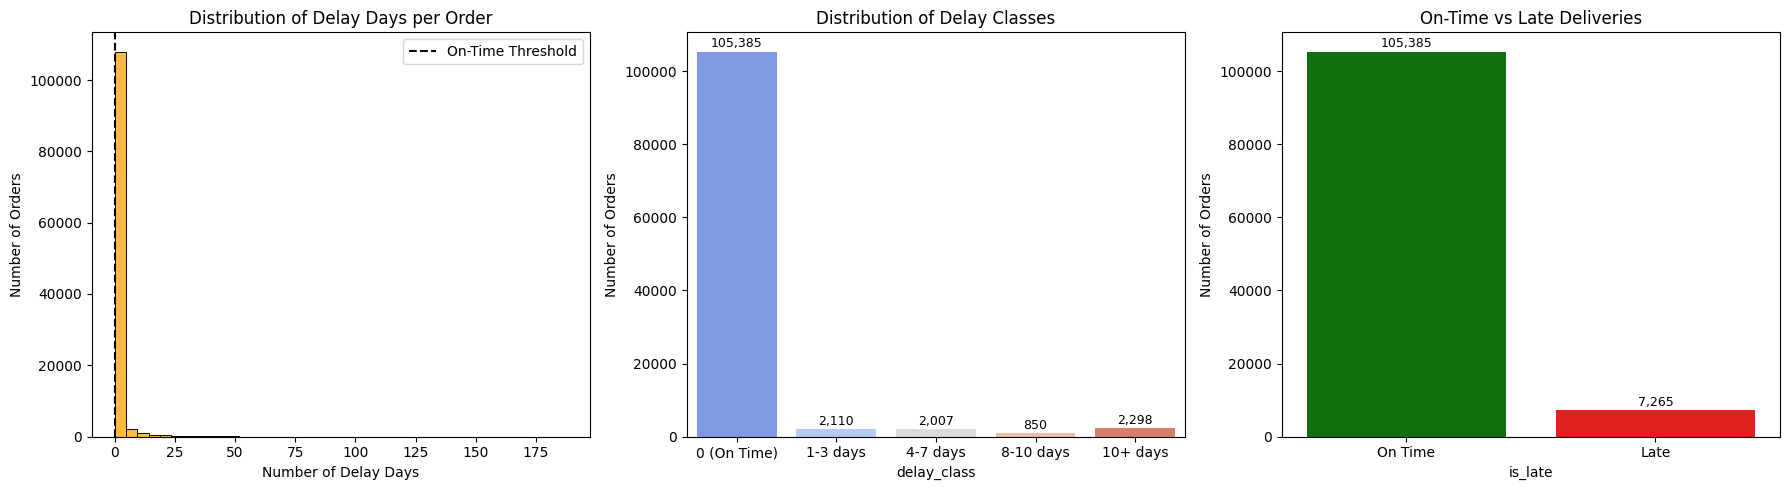

In [47]:
# Total number of rows
total_rows = fact_DF.shape[0]

# 1. Distributions
delay_class_counts = fact_DF['delay_class'].value_counts().sort_index()
late_counts = fact_DF['is_late'].value_counts()

plt.figure(figsize=(18,5))

# --- 1. Histogram: delay_days ---
plt.subplot(1,3,1)
sns.histplot(fact_DF['delay_days'], bins=40, color='orange', kde=False)
plt.title('Distribution of Delay Days per Order')
plt.xlabel('Number of Delay Days')
plt.ylabel('Number of Orders')
plt.axvline(0, color="black", linestyle="--", label="On-Time Threshold")
plt.legend()

# --- 2. Barplot: delay_class ---
plt.subplot(1,3,2)
sns.barplot(x=delay_class_counts.index, y=delay_class_counts.values, palette='coolwarm')
plt.xticks([0,1,2,3,4], ['0 (On Time)', '1-3 days', '4-7 days', '8-10 days', '10+ days'])
for i, v in enumerate(delay_class_counts.values):
    plt.text(i, v + total_rows*0.01, f"{v:,}", ha='center', fontsize=9)
plt.title('Distribution of Delay Classes')
plt.ylabel('Number of Orders')

# --- 3. Barplot: is_late ---
plt.subplot(1,3,3)
sns.barplot(x=late_counts.index, y=late_counts.values, palette=['green','red'])
plt.xticks([0,1], ['On Time', 'Late'])
for i, v in enumerate(late_counts.values):
    plt.text(i, v + total_rows*0.01, f"{v:,}", ha='center', fontsize=9)
plt.title('On-Time vs Late Deliveries')
plt.ylabel('Number of Orders')

plt.tight_layout()
plt.show()


###  Distance Calculation and Seller Count

In [48]:
# Rename columns for clarity
fact_DF = fact_DF.rename(columns={
    "lat_avg_x": "customer_lat_avg",
    "lng_avg_x": "customer_lng_avg",
    "lat_avg_y": "seller_lat_avg",
    "lng_avg_y": "seller_lng_avg"
})

# Compute distance using Haversine
def compute_distance(row):
    return haversine(
        (row['customer_lat_avg'], row['customer_lng_avg']),
        (row['seller_lat_avg'], row['seller_lng_avg'])
    )

fact_DF['distance_km'] = fact_DF.apply(compute_distance, axis=1)

In [49]:
# Count of unique sellers per order
seller_count = df_orderitems.groupby('order_id_pref')['seller_id_pref'].nunique().reset_index()
seller_count.rename(columns={'seller_id_pref': 'seller_count_per_order'}, inplace=True)

# Merge into fact table
fact_DF = fact_DF.merge(seller_count, on='order_id_pref', how='left')


In [50]:
fact_order_shipments = fact_DF[[
    'cusUni','customer_order_id', 'order_id_pref', 'seller_id_pref', 'product_id_pref', 
    'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
    'order_delivered_customer_date', 'order_estimated_delivery_date',
    'prep_time', 'shipping_time', 'estimated_time',
    'delay_days', 'delay_class', 'is_late', 'distance_km',
    'payment_types', 'payment_value_sum', 'payment_installments_max',
    'seller_count_per_order'
]]


fact_order_shipments.to_csv('fact_order_shipments.csv', index=False) # csv olarak kaydet. 

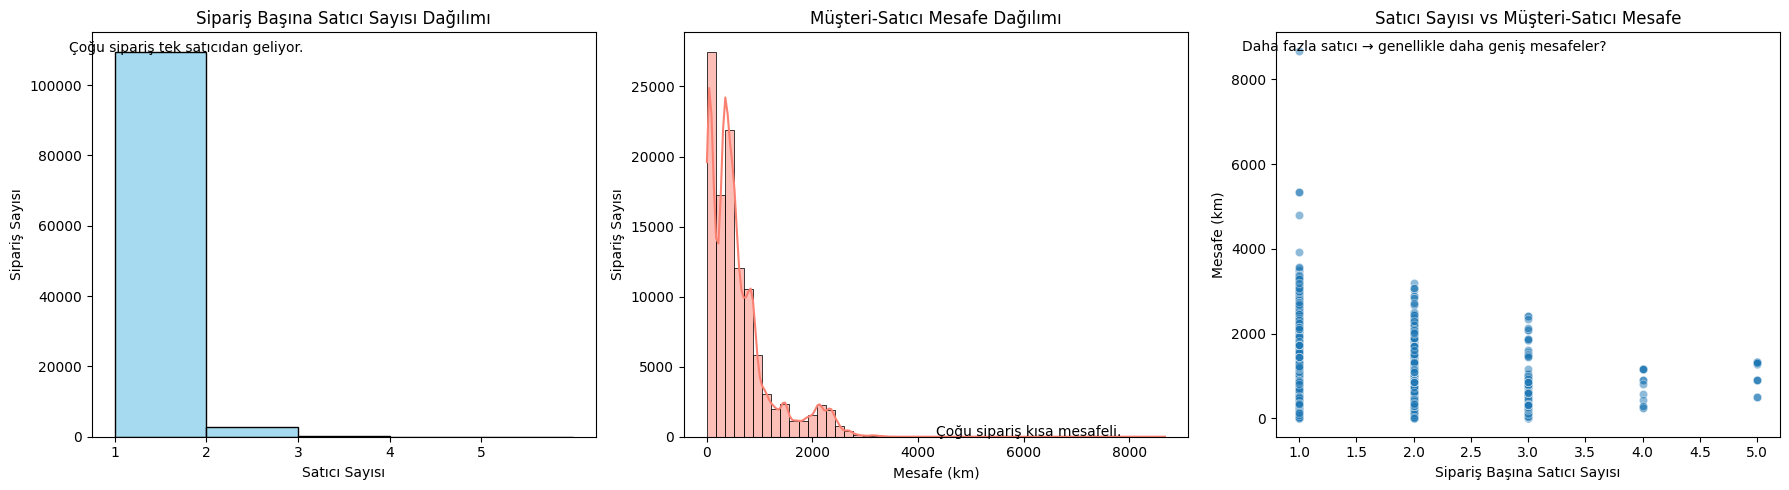

In [51]:
plt.figure(figsize=(18,5))

# --- 1. Histogram: seller_count_per_order ---
plt.subplot(1,3,1)
sns.histplot(fact_DF['seller_count_per_order'], bins=range(1, fact_DF['seller_count_per_order'].max()+2), 
             color='skyblue', kde=False)
plt.title('Sipariş Başına Satıcı Sayısı Dağılımı')
plt.xlabel('Satıcı Sayısı')
plt.ylabel('Sipariş Sayısı')
plt.xticks(range(1, fact_DF['seller_count_per_order'].max()+1))
plt.text(0.5, max(fact_DF['seller_count_per_order'].value_counts()), 
         "Çoğu sipariş tek satıcıdan geliyor.", fontsize=10, color='black')

# --- 2. Histogram: distance_km ---
plt.subplot(1,3,2)
sns.histplot(fact_DF['distance_km'], bins=50, color='salmon', kde=True)
plt.title('Müşteri-Satıcı Mesafe Dağılımı')
plt.xlabel('Mesafe (km)')
plt.ylabel('Sipariş Sayısı')
plt.text(max(fact_DF['distance_km'])/2, max(fact_DF['distance_km'].value_counts()), 
         "Çoğu sipariş kısa mesafeli.", fontsize=10, color='black')

# --- 3. Scatter Plot: seller_count_per_order vs distance_km ---
plt.subplot(1,3,3)
sns.scatterplot(x='seller_count_per_order', y='distance_km', data=fact_DF, alpha=0.5)
plt.title('Satıcı Sayısı vs Müşteri-Satıcı Mesafe')
plt.xlabel('Sipariş Başına Satıcı Sayısı')
plt.ylabel('Mesafe (km)')
plt.text(0.5, max(fact_DF['distance_km']), 
         "Daha fazla satıcı → genellikle daha geniş mesafeler?", fontsize=10, color='black')

plt.tight_layout()
plt.show()


### Null and negative value check

Total number of rows: 112,650

Negative durations (count and %):
  prep_time      : 1551  (1.38%)
  shipping_time  : 50  (0.04%)
  estimated_time : 9  (0.01%)


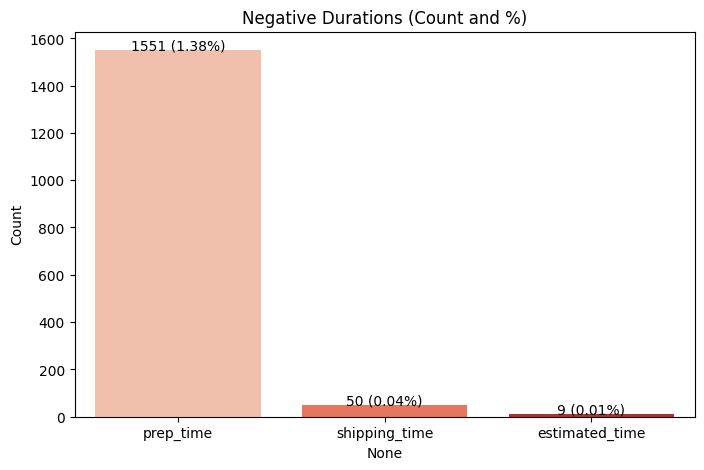


Null values (count and %):
  prep_time      : 1209  (1.07%)
  shipping_time  : 2455  (2.18%)
  estimated_time : 15  (0.01%)
  delay_days     : 0  (0.0%)
  distance_km    : 554  (0.49%)


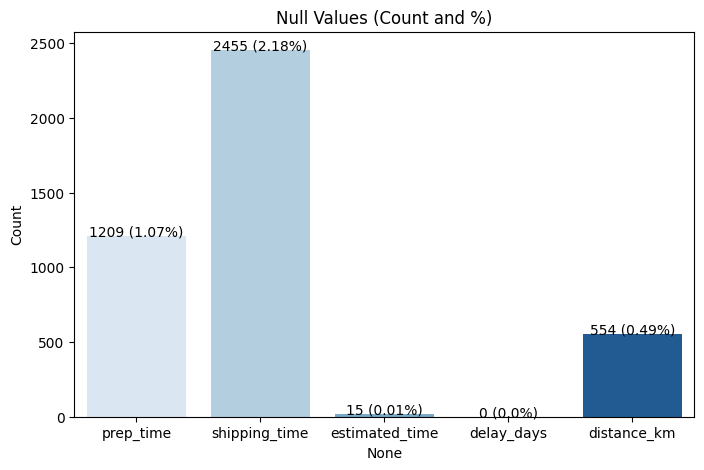

In [52]:
total_rows = fact_order_shipments.shape[0]

print(f"Total number of rows: {total_rows:,}\n")

# --- Negative durations ---
neg_counts = fact_order_shipments[["prep_time","shipping_time","estimated_time"]].lt(0).sum()
neg_perc   = (neg_counts / total_rows * 100).round(2)
print("Negative durations (count and %):")
for col in neg_counts.index:
    print(f"  {col:<15}: {neg_counts[col]}  ({neg_perc[col]}%)")

plt.figure(figsize=(8,5))
sns.barplot(x=neg_counts.index, y=neg_counts.values, palette="Reds")
for i, v in enumerate(neg_counts.values):
    plt.text(i, v + 1, f"{v} ({neg_perc[i]}%)", ha='center')
plt.title("Negative Durations (Count and %)")
plt.ylabel("Count")
plt.show()

# --- Null values ---
null_counts = fact_order_shipments[["prep_time","shipping_time","estimated_time","delay_days","distance_km"]].isnull().sum()
null_perc   = (null_counts / total_rows * 100).round(2)
print("\nNull values (count and %):")
for col in null_counts.index:
    print(f"  {col:<15}: {null_counts[col]}  ({null_perc[col]}%)")

plt.figure(figsize=(8,5))
sns.barplot(x=null_counts.index, y=null_counts.values, palette="Blues")
for i, v in enumerate(null_counts.values):
    plt.text(i, v + 1, f"{v} ({null_perc[i]}%)", ha='center')
plt.title("Null Values (Count and %)")
plt.ylabel("Count")
plt.show()



Negative values exist (~1.38%). It should be checked whether these negative durations are caused by time zone differences, since Brazil uses multiple time zones.

Negative prep_time - distribution by customer state:
customer_state
SP    653
MG    181
RJ    171
RS    102
PR     92
SC     56
BA     49
DF     43
GO     40
ES     28
CE     23
PE     21
MT     21
MA     12
PA     12
PB     12
PI      7
RN      7
MS      5
TO      4
AL      4
AC      3
SE      2
RO      1
AM      1
RR      1
Name: count, dtype: int64

Negative prep_time - distribution by seller state:
seller_state
SP    1098
MG     125
PR     113
SC      67
RJ      61
RS      34
MA      19
DF      12
PE       7
GO       6
BA       4
CE       1
PB       1
MT       1
ES       1
MS       1
Name: count, dtype: int64


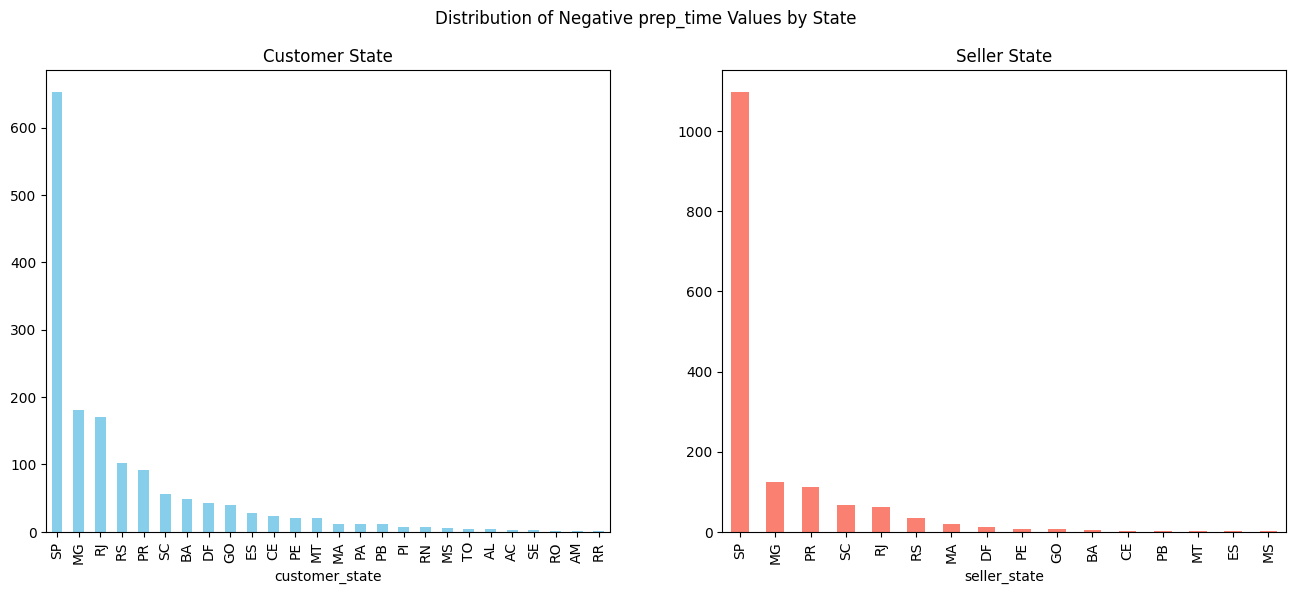

In [53]:
#1) Select negative prep_time records

neg_prep = fact_DF[fact_DF["prep_time"] < 0].copy()

#2) Distribution by customer state

prep_by_customer = neg_prep["customer_state"].value_counts()

#3) Distribution by seller state

prep_by_seller = neg_prep["seller_state"].value_counts()

print("Negative prep_time - distribution by customer state:")
print(prep_by_customer)

print("\nNegative prep_time - distribution by seller state:")
print(prep_by_seller)

#4) Optional visualization

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,2, figsize=(16,6))

prep_by_customer.plot(kind="bar", ax=axes[0], color="skyblue", title="Customer State")
prep_by_seller.plot(kind="bar", ax=axes[1], color="salmon", title="Seller State")

plt.suptitle("Distribution of Negative prep_time Values by State")
plt.show()

### Customer Side

Negative prep_time mostly comes from states in the UTC−03 region: SP (653), MG (181), RJ (171), RS (102).

There are some from UTC−04/−05 regions (MT=21, AC=3, AM=1, RO=1, RR=1), but they represent a very small fraction of the total.

### Seller Side

Almost all negative prep_time records come from sellers in the UTC−03 region: SP, MG, PR, SC, RJ.

Very few come from UTC−04/−05 regions (MT=1).

### Conclusion

Negative prep_time values are not solely caused by time zone differences.

The main reason is data entry errors or incorrect timestamp records.

For example, the shipment date might have been recorded incorrectly → appearing earlier than the order confirmation date.

Time zone differences may have contributed slightly, but their impact is minimal.

### Summary Statistics / Basic Numerical Overview and Data Types

In [54]:
# --- Delay rate ---
late_count = fact_order_shipments["is_late"].sum()
late_perc  = (late_count / total_rows * 100).round(2)
print(f"\nLate orders: {late_count}  ({late_perc}%)")

# --- Payment types ---
print("\nPayment types (count and % - top 10):")
pay_counts = fact_order_shipments["payment_types"].value_counts()
for t, c in pay_counts.head(10).items():
    print(f"  {t:<25}: {c}  ({c/total_rows*100:.2f}%)")

# --- Number of sellers per order ---
print("\nNumber of sellers per order (count and %):")
seller_counts = fact_order_shipments["seller_count_per_order"].value_counts().sort_index()
for sc, c in seller_counts.items():
    print(f"  {sc:<2} sellers: {c}  ({c/total_rows*100:.2f}%)")



Late orders: 7265  (6.45%)

Payment types (count and % - top 10):
  credit_card              : 83947  (74.52%)
  boleto                   : 22867  (20.30%)
  credit_card/voucher      : 2487  (2.21%)
  debit_card               : 1689  (1.50%)
  voucher                  : 1656  (1.47%)
  credit_card/debit_card   : 1  (0.00%)

Number of sellers per order (count and %):
  1  sellers: 109547  (97.25%)
  2  sellers: 2876  (2.55%)
  3  sellers: 202  (0.18%)
  4  sellers: 12  (0.01%)
  5  sellers: 13  (0.01%)


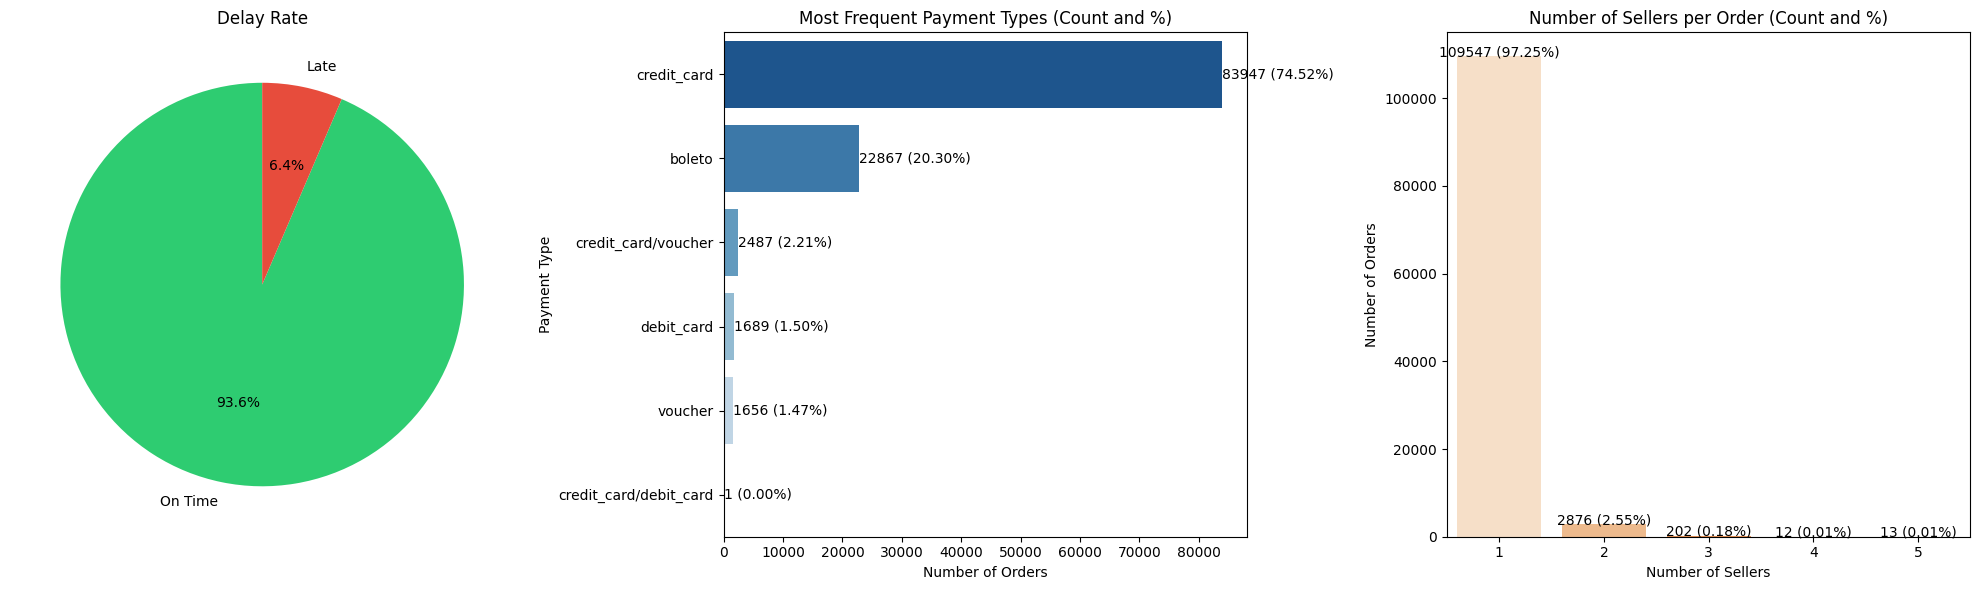

In [55]:
plt.figure(figsize=(20,6))

# --- 1. Delay Rate Pie Chart ---
plt.subplot(1,3,1)
late_counts = fact_order_shipments['is_late'].value_counts()
plt.pie(late_counts.values, labels=['On Time', 'Late'], autopct='%1.1f%%', colors=['#2ecc71','#e74c3c'], startangle=90)
plt.title('Delay Rate')

# --- 2. Payment Types Barplot ---
plt.subplot(1,3,2)
pay_counts = fact_order_shipments["payment_types"].value_counts().head(10)  # Top 10 payment types
sns.barplot(x=pay_counts.values, y=pay_counts.index, palette='Blues_r')
for i, v in enumerate(pay_counts.values):
    plt.text(v + 5, i, f"{v} ({v/total_rows*100:.2f}%)", va='center')
plt.title('Most Frequent Payment Types (Count and %)')
plt.xlabel('Number of Orders')
plt.ylabel('Payment Type')

# --- 3. Number of Sellers per Order Barplot ---
plt.subplot(1,3,3)
seller_counts = fact_order_shipments["seller_count_per_order"].value_counts().sort_index()
sns.barplot(x=seller_counts.index, y=seller_counts.values, palette='Oranges')
for i, v in enumerate(seller_counts.values):
    plt.text(i, v + 5, f"{v} ({v/total_rows*100:.2f}%)", ha='center')
plt.title('Number of Sellers per Order (Count and %)')
plt.xlabel('Number of Sellers')
plt.ylabel('Number of Orders')
plt.xticks(range(len(seller_counts.index)), seller_counts.index)

plt.tight_layout()
plt.show()



In [56]:
same_state_multi_city = zip_summary_sorted[(zip_summary_sorted['state_count'] == 1) & (zip_summary_sorted['city_count'] > 1)]
same_state_multi_city_count = same_state_multi_city.shape[0]

multi_state = zip_summary_sorted[zip_summary_sorted['state_count'] > 1]
multi_state_count = multi_state.shape[0]

same_state_multi_city_count, multi_state_count

(8551, 8)

In [57]:

total_orders = fact_DF.shape[0]

total_late_orders = fact_DF["is_late"].sum()

late_ratio = (total_late_orders / total_orders) * 100

print(f"Total number of orders: {total_orders:,}")
print(f"Number of late orders: {total_late_orders:,}  ({late_ratio:.2f}%)")

Total number of orders: 112,650
Number of late orders: 7,265  (6.45%)


In [58]:
#  is_late ?
# late_orders = fact_df[fact_df['is_late'] == 1]
# delay_days 
late_orders = fact_DF[fact_DF['delay_days'] > 0]
late_orders.head()


,order_item_pref,order_id_pref,product_id_pref,seller_id_pref,order_item_number,shipping_limit_date,price,freight_value,customer_order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_zip_code_prefix,customer_city,customer_state,cusUni,customer_lat_avg,customer_lng_avg,seller_zip_code_prefix,seller_city,seller_state,seller_lat_avg,seller_lng_avg,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,payment_value_sum,payment_installments_max,payment_types,prep_time,shipping_time,estimated_time,delay_days,is_late,delay_class,distance_km,seller_count_per_order
21,OIT022,ORD35003,PRO7116,SEL988,1,2017-11-27 19:09:02,21.990,11.850,CUS64044,delivered,2017-11-21 18:54:23,2017-11-21 19:09:02,2017-11-22 20:46:54,2017-12-09 17:27:23,2017-12-07,18900,santacruzdoriopardo,SP,CUSUNI62617,-22.896,-49.624,4160,saopaulo,SP,-23.625,-46.612,telefonia,59.000,540.000,4.000,300.000,17.000,4.000,12.000,33.840,3.000,credit_card,1.000,16.000,15.000,2.000,1,1,318.214,1
39,OIT040,ORD71320,PRO20794,SEL1264,1,2017-04-24 22:25:19,809.100,44.290,CUS27545,delivered,2017-04-06 22:16:10,2017-04-06 22:25:19,2017-04-17 13:54:37,2017-05-23 08:32:07,2017-05-19,57250,campoalegre,AL,CUSUNI6726,-9.784,-36.350,35680,itauna,MG,-20.078,-44.576,informatica_acessorios,60.000,2136.000,1.000,3407.000,28.000,22.000,23.000,853.390,10.000,credit_card,10.000,35.000,42.000,4.000,1,2,1445.199,1
47,OIT048,ORD2491,PRO21689,SEL2464,1,2017-11-29 22:38:47,99.000,13.710,CUS507,delivered,2017-11-24 19:19:18,2017-11-24 22:38:47,2017-11-27 12:42:15,2017-12-22 18:37:40,2017-12-14,8072,saopaulo,SP,CUSUNI0507,-23.512,-46.484,14940,ibitinga,SP,-21.757,-48.830,cama_mesa_banho,55.000,312.000,1.000,1550.000,44.000,14.000,34.000,112.710,4.000,credit_card,2.000,25.000,19.000,8.000,1,3,309.811,1
48,OIT049,ORD42206,PRO20437,SEL2364,1,2017-05-18 17:35:11,18.990,7.780,CUS70021,delivered,2017-05-14 17:19:44,2017-05-14 17:35:11,2017-05-24 15:45:01,2017-05-26 13:14:50,2017-05-24,2929,saopaulo,SP,CUSUNI68321,-23.493,-46.706,1031,saopaulo,SP,-23.542,-46.635,beleza_saude,47.000,1474.000,3.000,150.000,43.000,13.000,14.000,53.540,2.000,credit_card,9.000,1.000,9.000,2.000,1,1,9.095,1
49,OIT050,ORD42206,PRO20437,SEL2364,2,2017-05-18 17:35:11,18.990,7.780,CUS70021,delivered,2017-05-14 17:19:44,2017-05-14 17:35:11,2017-05-24 15:45:01,2017-05-26 13:14:50,2017-05-24,2929,saopaulo,SP,CUSUNI68321,-23.493,-46.706,1031,saopaulo,SP,-23.542,-46.635,beleza_saude,47.000,1474.000,3.000,150.000,43.000,13.000,14.000,53.540,2.000,credit_card,9.000,1.000,9.000,2.000,1,1,9.095,1


### ===  Data Preparation & Basic Exploration ===

In [59]:
# 1.2 Data types + date conversions
fact_DF.dtypes
date_cols = [
    "order_purchase_timestamp","order_approved_at",
    "order_delivered_customer_date","order_estimated_delivery_date"
]
fact_DF[date_cols] = fact_DF[date_cols].apply(pd.to_datetime, errors="coerce")

# 1.3 Check for missing values (count & %)
total_rows = fact_DF.shape[0]
null_counts = fact_DF.isnull().sum()
null_perc   = (null_counts / total_rows * 100).round(2)
print("\nMissing values (count & %):")
for col in null_counts.index:
    if null_counts[col] > 0:
        print(f"{col:<35}: {null_counts[col]}  ({null_perc[col]}%)")

# 1.4 Total number of records
print("\nTotal number of records:", total_rows)

# 1.5 Unique counts of customers / sellers / orders (count)
cust_count   = fact_DF["cusUni"].nunique()
seller_count = fact_DF["seller_id_pref"].nunique()
order_count  = fact_DF["order_id_pref"].nunique()

print(f"\nUnique customers : {cust_count}")
print(f"Unique sellers   : {seller_count}")
print(f"Unique orders    : {order_count}")

# 1.6 Summarize numeric columns
num_cols = ["prep_time","shipping_time","estimated_time","delay_days","payment_value_sum"]
print("\nSummary of numeric columns:")
fact_DF[num_cols].describe().T
fact_DF[num_cols].quantile([0.01, 0.99])



Missing values (count & %):
order_approved_at                  : 15  (0.01%)
order_delivered_carrier_date       : 1194  (1.06%)
order_delivered_customer_date      : 2454  (2.18%)
customer_lat_avg                   : 302  (0.27%)
customer_lng_avg                   : 302  (0.27%)
seller_lat_avg                     : 253  (0.22%)
seller_lng_avg                     : 253  (0.22%)
product_category_name              : 1603  (1.42%)
product_name_lenght                : 1603  (1.42%)
product_description_lenght         : 1603  (1.42%)
product_photos_qty                 : 1603  (1.42%)
product_weight_g                   : 18  (0.02%)
product_length_cm                  : 18  (0.02%)
product_height_cm                  : 18  (0.02%)
product_width_cm                   : 18  (0.02%)
payment_value_sum                  : 3  (0.0%)
payment_installments_max           : 3  (0.0%)
payment_types                      : 3  (0.0%)
prep_time                          : 1209  (1.07%)
shipping_time               

,prep_time,shipping_time,estimated_time,delay_days,payment_value_sum
0.010,-1.000,0.000,5.000,0.000,22.950
0.990,17.000,40.000,50.000,18.000,1238.960


In [60]:
total_missing = fact_order_shipments.isna().sum().sum()
total_rows = len(fact_order_shipments)

deliv_missing = fact_order_shipments["order_delivered_customer_date"].isna().sum()
ship_missing  = fact_order_shipments["shipping_time"].isna().sum()
prep_overlap  = fact_order_shipments[
    fact_order_shipments["order_delivered_customer_date"].isna() &
    fact_order_shipments["prep_time"].isna()
].shape[0]

total_overlap_cells = deliv_missing + ship_missing + prep_overlap
pct_overlap = round(total_overlap_cells / total_missing * 100, 2)
row_loss_pct = round(deliv_missing / total_rows * 100, 2)

print(f"Total missing cells             : {total_missing}")
print(f"Missing cells from these 3 cols: {total_overlap_cells} ({pct_overlap}%)")
print(f"Row loss if dropped             : {deliv_missing} ({row_loss_pct}%)")

Total missing cells             : 7905
Missing cells from these 3 cols: 6102 (77.19%)
Row loss if dropped             : 2454 (2.18%)


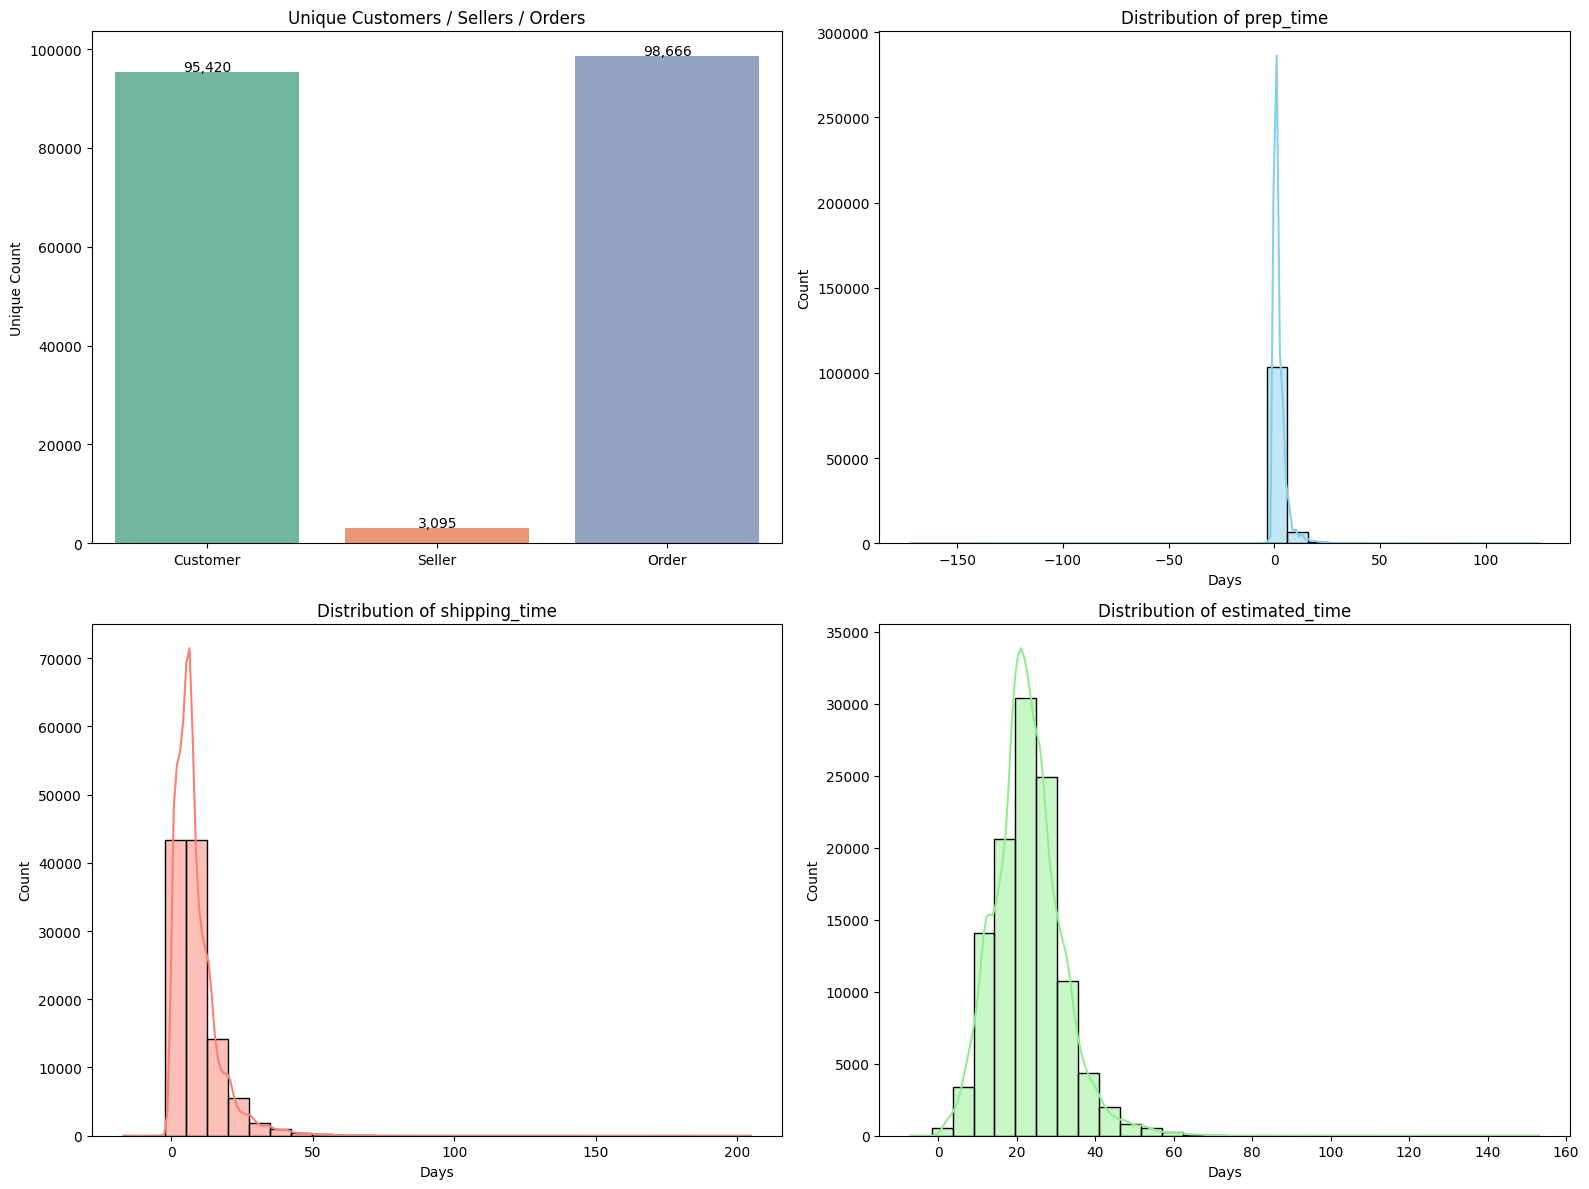

In [61]:
plt.figure(figsize=(16,12))

# --- 1. Unique customers/sellers/orders ---
plt.subplot(2,2,1)
sns.barplot(x=["Customer","Seller","Order"], y=[cust_count,seller_count,order_count], palette="Set2")
plt.ylabel("Unique Count")
plt.title("Unique Customers / Sellers / Orders")
for i, v in enumerate([cust_count,seller_count,order_count]):
    plt.text(i, v + 100, f"{v:,}", ha='center')

# --- 2. prep_time ---
plt.subplot(2,2,2)
sns.histplot(fact_DF["prep_time"], kde=True, bins=30, color="skyblue")
plt.title("Distribution of prep_time")
plt.xlabel("Days")
plt.ylabel("Count")

# --- 3. shipping_time ---
plt.subplot(2,2,3)
sns.histplot(fact_DF["shipping_time"], kde=True, bins=30, color="salmon")
plt.title("Distribution of shipping_time")
plt.xlabel("Days")
plt.ylabel("Count")

# --- 4. estimated_time ---
plt.subplot(2,2,4)
sns.histplot(fact_DF["estimated_time"], kde=True, bins=30, color="lightgreen")
plt.title("Distribution of estimated_time")
plt.xlabel("Days")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


### In the first chart:

X-axis: Shows the categories Customer, Seller, and Order.

Y-axis: Shows the unique count in each category.

### Observations from the chart:

There are approximately 95,000 unique customers, indicating a very large customer base.

There are around 3,000 sellers, which is relatively small compared to the number of customers. This implies that sellers serve many different customers.

There are roughly 99,000 orders, which is close to the number of customers, suggesting that most customers placed only one order.

### Interpretation:
This distribution shows that while the dataset has high diversity in customers and orders, the number of sellers is relatively low. Therefore, differences in seller performance (e.g., delivery time, prep time) could directly impact customer experience and delays.

prep_time is mostly concentrated between 0–5 days, but some long preparation times also exist.

shipping_time is generally short (1–10 days), although a few outliers indicate very long delivery times.

estimated_time shows that the delivery times provided by the company are mostly set in the range of 10–30 days.

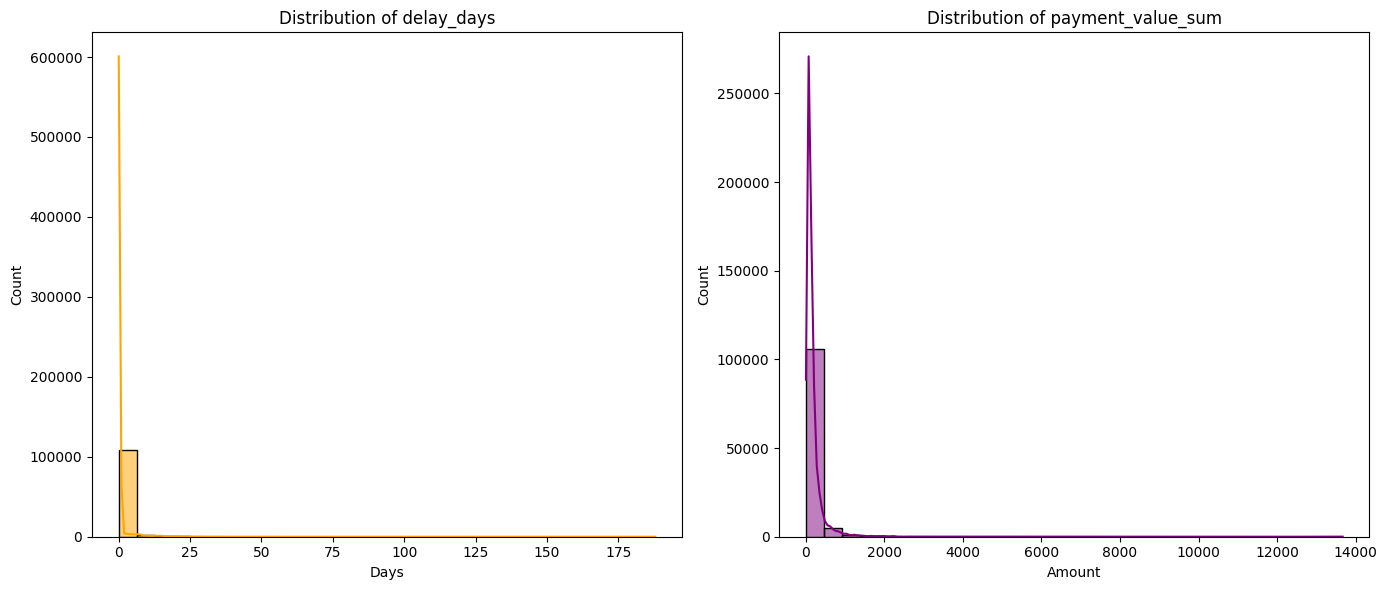

In [62]:
plt.figure(figsize=(14,6))

# --- 1. delay_days ---
plt.subplot(1,2,1)
sns.histplot(fact_DF["delay_days"], kde=True, bins=30, color="orange")
plt.title("Distribution of delay_days")
plt.xlabel("Days")
plt.ylabel("Count")

# --- 2. payment_value_sum ---
plt.subplot(1,2,2)
sns.histplot(fact_DF["payment_value_sum"], kde=True, bins=30, color="purple")
plt.title("Distribution of payment_value_sum")
plt.xlabel("Amount")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


### When examining the delay_days distribution:

The vast majority of orders have 0 days of delay, meaning they were delivered on time.

However, a small number of orders experience long delays (10 days or more).

These outliers will play a critical role in predicting the "likelihood of delay" in the model.

### When examining the payment_value_sum distribution:

Most orders are concentrated at lower amounts.

High-value orders are rare and form the tail of the distribution.

This suggests that payment amount is an important variable to test for its potential impact on the delivery process.

### === Time-based Analysis ===

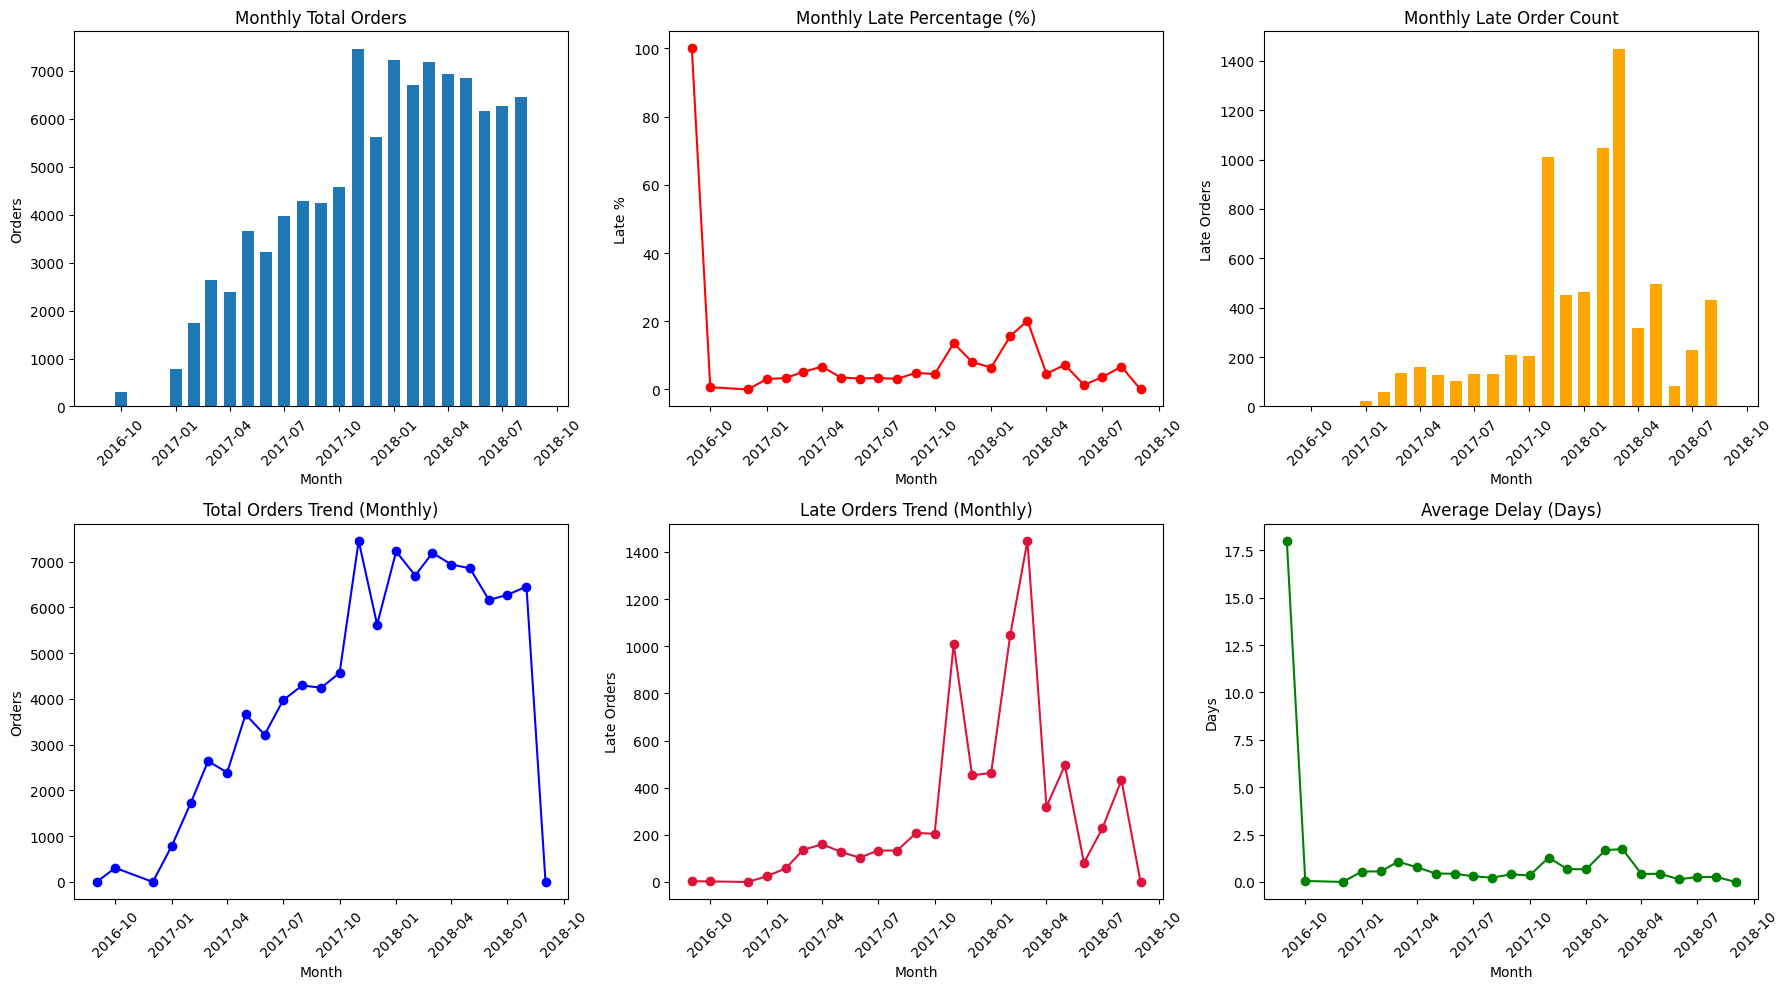

In [63]:
fact_order_shipments = fact_order_shipments.copy()
fact_order_shipments["order_purchase_timestamp"] = pd.to_datetime(
    fact_order_shipments["order_purchase_timestamp"], errors="coerce"
)
fact_order_shipments["year"]  = fact_order_shipments["order_purchase_timestamp"].dt.year
fact_order_shipments["month"] = fact_order_shipments["order_purchase_timestamp"].dt.month
fact_order_shipments["week"]  = fact_order_shipments["order_purchase_timestamp"].dt.isocalendar().week

# Monthly total and late orders
monthly = (
    fact_order_shipments
    .groupby(["year","month"])
    .agg(total_orders=("order_id_pref","nunique"),
         late_orders=("is_late","sum"),
         avg_delay=("delay_days","mean"))
    .reset_index()
)
monthly["late_pct"] = (monthly["late_orders"] / monthly["total_orders"]) * 100
monthly["date"] = pd.to_datetime(monthly[["year","month"]].assign(day=1))

# --- Multi-plot Figure (2x3) ---
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()  # easy access

# 1) Monthly total orders
axes[0].bar(monthly["date"], monthly["total_orders"], width=20)
axes[0].set_title("Monthly Total Orders")
axes[0].set_xlabel("Month"); axes[0].set_ylabel("Orders")

# 2) Monthly late percentage (%)
axes[1].plot(monthly["date"], monthly["late_pct"], marker="o", color="red")
axes[1].set_title("Monthly Late Percentage (%)")
axes[1].set_xlabel("Month"); axes[1].set_ylabel("Late %")

# 3) Monthly late order count
axes[2].bar(monthly["date"], monthly["late_orders"], width=20, color="orange")
axes[2].set_title("Monthly Late Order Count")
axes[2].set_xlabel("Month"); axes[2].set_ylabel("Late Orders")

# 4) Total orders trend (line)
axes[3].plot(monthly["date"], monthly["total_orders"], marker="o", color="blue")
axes[3].set_title("Total Orders Trend (Monthly)")
axes[3].set_xlabel("Month"); axes[3].set_ylabel("Orders")

# 5) Late orders trend (count + % label)
axes[4].plot(monthly["date"], monthly["late_orders"], marker="o", color="crimson")
axes[4].set_title("Late Orders Trend (Monthly)")
axes[4].set_xlabel("Month"); axes[4].set_ylabel("Late Orders")

# 6) Average delay (days)
axes[5].plot(monthly["date"], monthly["avg_delay"], marker="o", color="green")
axes[5].set_title("Average Delay (Days)")
axes[5].set_xlabel("Month"); axes[5].set_ylabel("Days")

# Make X-axis labels readable
for ax in axes:
    ax.tick_params(axis='x', rotation=45)


plt.tight_layout()
plt.show()


### Monthly Orders & Delay Analysis – Summary

#### Order Volume

Orders grew steadily throughout 2017, peaking around early 2018 (~7000+ orders/month).

Indicates rapid customer acquisition followed by market saturation.

#### Late Rate

Low in 2017 (~2–5%), spiked in early 2018 (~15–20%).

Suggests operational bottlenecks or logistic capacity issues.

#### Late Orders Count

Increased with volume in 2017 but remained low.

Early 2018 saw a sharp rise (1400+ late orders/month), highlighting capacity vs process gaps.

#### Average Delay (Days)

Mostly 0–2 days; early 2018 shows slightly higher delays.

Delays were short but higher frequency may have impacted customer satisfaction.

#### Conclusion:
Platform growth increased order volume, but delivery performance issues appeared in early 2018, providing insights for root-cause analysis of logistic bottlenecks.

Note:

** Public Holidays: Brazil has numerous public holidays (e.g., Carnival, Easter, Independence Day). Logistic delays are likely during these periods.

** 2018 Truckers’ Strike: In May 2018, a nationwide truckers’ strike occurred, significantly impacting e-commerce logistics and causing major delivery delays.

The increased delays observed in early 2018 should be analyzed in the context of such macro events.

Number of orders during strike: 1751
Late order rate during strike: 2.46%
Average shipping_time during strike: 8.79 days
Late order rate outside strike: 6.51%
Average shipping_time outside strike: 8.73 days


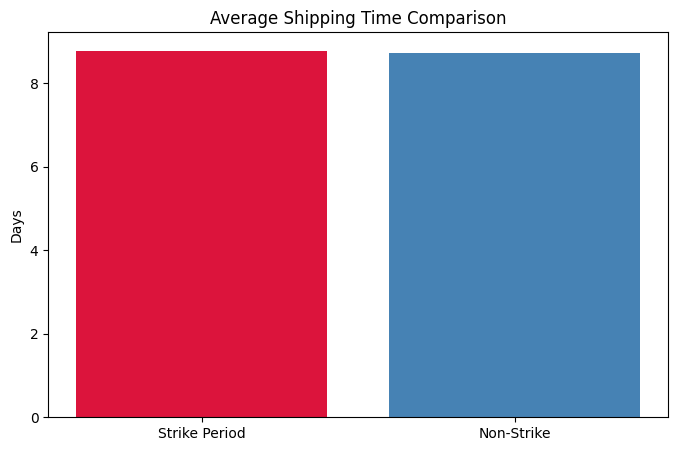

In [64]:
# Strike period date range
start = pd.to_datetime("2018-05-21")
end   = pd.to_datetime("2018-06-01")

# Orders during strike
strike_orders = fact_order_shipments[
    (fact_order_shipments["order_purchase_timestamp"] >= start) &
    (fact_order_shipments["order_purchase_timestamp"] <= end)
]

print("Number of orders during strike:", strike_orders.shape[0])

# 1) Late order rate
late_strike = strike_orders["is_late"].mean() * 100
print(f"Late order rate during strike: {late_strike:.2f}%")

# 2) Average shipping time
avg_ship_strike = strike_orders["shipping_time"].mean()
print(f"Average shipping_time during strike: {avg_ship_strike:.2f} days")

# 3) Non-strike orders for comparison
non_strike_orders = fact_order_shipments[
    ~((fact_order_shipments["order_purchase_timestamp"] >= start) &
      (fact_order_shipments["order_purchase_timestamp"] <= end))
]

late_non_strike = non_strike_orders["is_late"].mean() * 100
avg_ship_non_strike = non_strike_orders["shipping_time"].mean()

print(f"Late order rate outside strike: {late_non_strike:.2f}%")
print(f"Average shipping_time outside strike: {avg_ship_non_strike:.2f} days")

# 4) Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(["Strike Period", "Non-Strike"], 
        [avg_ship_strike, avg_ship_non_strike], color=["crimson","steelblue"])
plt.title("Average Shipping Time Comparison")
plt.ylabel("Days")
plt.show()


#### Target Column Separation

Including target columns (is_late, delay_class, delay_days) directly in the feature matrix (X) can cause data leakage.

#### Therefore:

Separate target columns (y)

Remove them from X

Perform train/test split

Handle missing values and time-derived features separately

The chart shows that the strike's impact is not reflected in the dataset. The data source may have been cleaned, or the effect was very limited (e.g., affecting only certain states or a small group of sellers). Therefore, it did not cause delays at the overall level, and the strike effect is effectively excluded from the model training.

## Delay Analysis

In [65]:
# Calculate total number of delayed orders
total_late_orders = fact_order_shipments['is_late'].sum()
print("Total delayed orders:", total_late_orders)

Total delayed orders: 7265


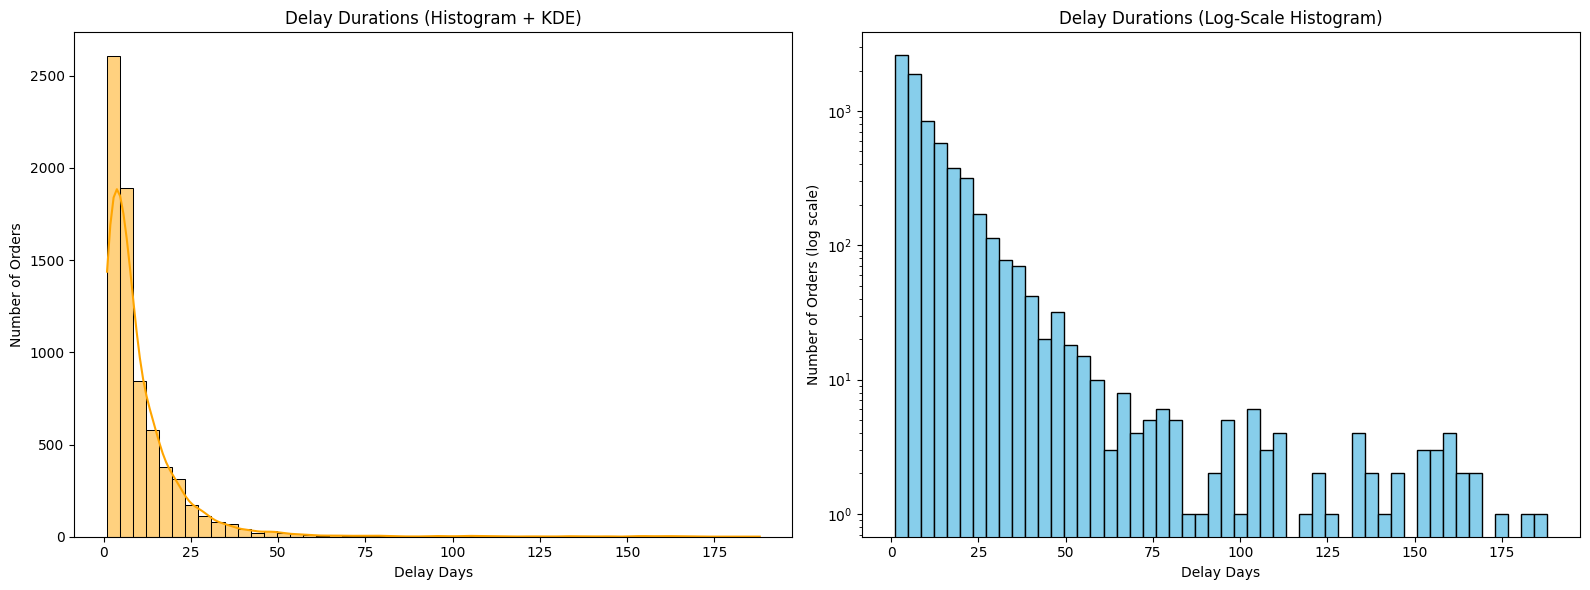

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))

# --- Histogram + KDE ---
sns.histplot(late_orders['delay_days'], bins=50, kde=True, color="orange", edgecolor="black", ax=axes[0])
axes[0].set_xlabel("Delay Days")
axes[0].set_ylabel("Number of Orders")
axes[0].set_title("Delay Durations (Histogram + KDE)")

# --- Log-Scale Histogram ---
axes[1].hist(late_orders['delay_days'], bins=50, edgecolor='black', color="skyblue")
axes[1].set_yscale("log")
axes[1].set_xlabel("Delay Days")
axes[1].set_ylabel("Number of Orders (log scale)")
axes[1].set_title("Delay Durations (Log-Scale Histogram)")

plt.tight_layout()
plt.show()

### The above plots show the distribution of delay days from different perspectives:

- **Histogram + KDE (left): The majority of orders experience short delays (1–5 days). The density curve indicates a bell-shaped distribution around these short delays.

- **Log-Scale Histogram (right): Although long delays (50+ days) are rare, they are visible due to the logarithmic scale, highlighting extreme outliers.

This analysis suggests that in the modeling process, short delays and extreme delays should be treated differently.

### Delay Days Distribution – Boxplot

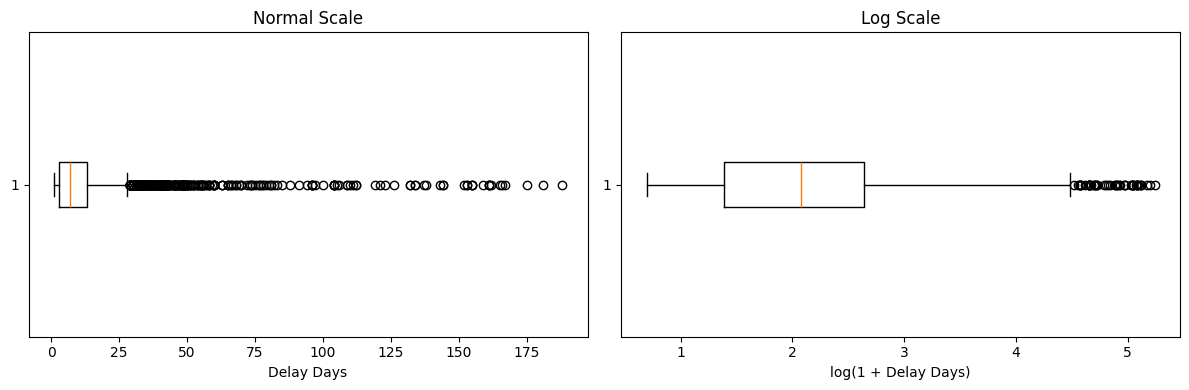

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

# Normal boxplot
axes[0].boxplot(late_orders['delay_days'], vert=False)
axes[0].set_xlabel("Delay Days")
axes[0].set_title("Normal Scale")

# Log(1+x) boxplot
axes[1].boxplot(np.log1p(late_orders['delay_days']), vert=False)
axes[1].set_xlabel("log(1 + Delay Days)")
axes[1].set_title("Log Scale")

plt.tight_layout()
plt.show()


The above plots compare the distribution of delay days on normal and log scales.

On the normal scale, most orders have delays of 0–20 days, but extreme values (100+ days) compress the bulk of the distribution.

The log-transformed scale reduces the impact of outliers, making typical delays (e.g., 1–15 days) easier to analyze.

Log transformation helps machine learning models handle skewed data caused by extreme outliers.

#### Summary statistics (mean, median, min, max)

In [68]:
mean_delay = late_orders['delay_days'].mean()
median_delay = late_orders['delay_days'].median()
min_delay = late_orders['delay_days'].min()
max_delay = late_orders['delay_days'].max()

print("Average delay:", mean_delay)
print("Median delay:", median_delay)
print("Minimum delay:", min_delay)
print("Maximum delay:", max_delay)

Average delay: 10.488781830695114
Median delay: 7.0
Minimum delay: 1.0
Maximum delay: 188.0


## Customer, Seller, and Product Level Analysis

#### Average Delay per Customer

In [69]:
# Filter only orders with delays:
late_orders = fact_order_shipments[fact_order_shipments['delay_days'] > 0]

In [70]:
customer_delay_mean = late_orders.groupby("cusUni")["delay_days"].mean().reset_index()
customer_delay_mean.rename(columns={"delay_days": "avg_delay_days"}, inplace=True)
customer_delay_mean["avg_delay_days"] = customer_delay_mean["avg_delay_days"].astype(int)
customer_delay_mean.head()

,cusUni,avg_delay_days
0,CUSUNI0003,1
1,CUSUNI0019,8
2,CUSUNI0033,37
3,CUSUNI0060,15
4,CUSUNI0090,28


#### Number of delayed orders per customer:

In [71]:
customer_delay_count = late_orders.groupby("cusUni")["order_id_pref"].nunique().reset_index()
customer_delay_count.rename(columns={"order_id_pref": "late_order_count"}, inplace=True)
customer_delay_count.head()

,cusUni,late_order_count
0,CUSUNI0003,1
1,CUSUNI0019,1
2,CUSUNI0033,1
3,CUSUNI0060,1
4,CUSUNI0090,1


#### Top 10 customers with the highest average delay:

In [72]:
top_customers = customer_delay_mean.sort_values("avg_delay_days", ascending=False).head(10)
top_customers

,cusUni,avg_delay_days
4494,CUSUNI68968,188
1385,CUSUNI27483,181
4365,CUSUNI67222,175
3266,CUSUNI51868,167
946,CUSUNI21621,166
2058,CUSUNI3595,165
6047,CUSUNI90158,162
3531,CUSUNI55565,161
4465,CUSUNI68602,161
4328,CUSUNI66759,159


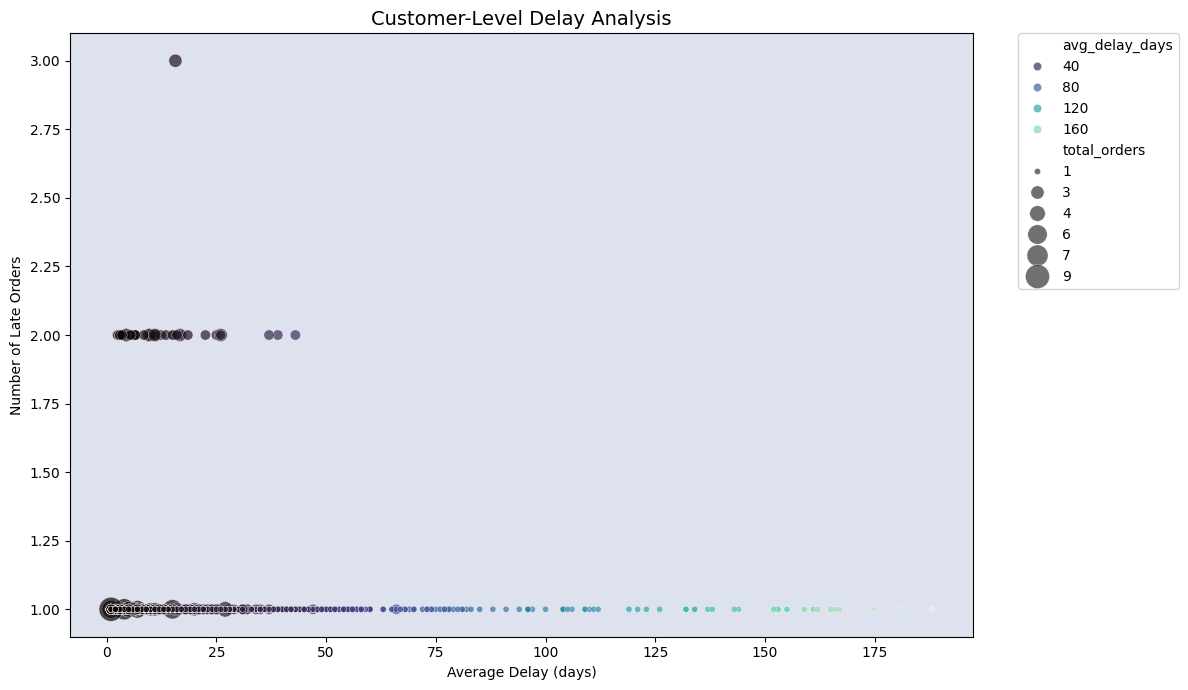

In [73]:
# Average delay and number of late orders per customer
customer_delay_stats = (
    late_orders.groupby("cusUni")
    .agg(
        avg_delay_days=("delay_days", "mean"),
        late_order_count=("order_id_pref", "nunique")
    )
    .reset_index()
)

# Total orders per customer (late + on-time)
total_orders_customer = (
    fact_order_shipments.groupby("cusUni")["order_id_pref"].nunique().reset_index()
    .rename(columns={"order_id_pref": "total_orders"})
)

# Merge average delay, late order count, and total orders
customer_summary = customer_delay_stats.merge(total_orders_customer, on="cusUni", how="left")

# Scatter plot
fig, ax = plt.subplots(figsize=(12,7))

sns.scatterplot(
    data=customer_summary,
    x="avg_delay_days", 
    y="late_order_count",
    size="total_orders",     # bubble size represents total orders
    hue="avg_delay_days", 
    sizes=(20, 300),
    palette="mako",  
    alpha=0.7,
    ax=ax
)

# Background colors
ax.set_facecolor("#DEE1EE")
fig.patch.set_facecolor("#ffffff")

ax.set_title("Customer-Level Delay Analysis", fontsize=14)
ax.set_xlabel("Average Delay (days)")
ax.set_ylabel("Number of Late Orders")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()



- X-axis (average delay in days): Moving to the right, customers with longer-delayed orders are observed. Some extreme cases reach over 150+ days.

- Y-axis (number of late orders): Most customers have experienced only 1 late order. Customers with 2–3 late orders are relatively few.

- Bubble size (total number of orders): Larger bubbles represent customers with more total orders. High-volume customers generally have average delays within the 0–50 day range.

- Color (average delay intensity): Moving from lighter to darker shades indicates increasing average delay. Using darker tones (e.g., shades of blue) improves readability.

#### Summary:

- The majority of delays occur only once per customer; systematic repetition is uncommon.

- There are customers with very long delays, but they are few in number.

- High-volume customers do not systematically experience long delays. This suggests that logistical issues usually affect individual orders rather than entire customer segments.

#### Average Delay per Seller

In [74]:
seller_delay_mean = late_orders.groupby("seller_id_pref")["delay_days"].mean().reset_index()
seller_delay_mean.rename(columns={"delay_days": "avg_delay_days"}, inplace=True)
seller_delay_mean.head()

,seller_id_pref,avg_delay_days
0,SEL001,3.000
1,SEL002,1.000
2,SEL005,7.000
3,SEL009,6.500
4,SEL010,17.583


#### Delay Comparison: Single-Seller vs Multi-Seller Orders

In [75]:
# Count of sellers per order
order_seller_counts = fact_order_shipments.groupby("order_id_pref")["seller_id_pref"].nunique().reset_index()
order_seller_counts.rename(columns={"seller_id_pref": "seller_count"}, inplace=True)

# Merge with average delay per order
order_delay = fact_order_shipments.groupby("order_id_pref")["delay_days"].mean().reset_index()
order_seller_delay = order_delay.merge(order_seller_counts, on="order_id_pref")

# Compare single-seller vs multi-seller orders
comparison = order_seller_delay.groupby("seller_count")["delay_days"].mean().reset_index()
comparison


,seller_count,delay_days
0,1,0.712
1,2,0.044
2,3,0.000
3,4,0.000
4,5,0.000


In [76]:
#### Calculate average delay per seller

In [77]:
# 1. Average delay, total orders, and late orders per seller
seller_stats = (
    fact_order_shipments
    .groupby("seller_id_pref")
    .agg(
        avg_delay_days=("delay_days", "mean"),
        total_orders=("order_id_pref", "nunique"),
        late_orders=("is_late", "sum")
    )
    .reset_index()
)

# 2. Calculate late order ratio (%)
seller_stats["late_ratio"] = (seller_stats["late_orders"] / seller_stats["total_orders"] * 100).round(2)

# 3. Top 10 sellers by average delay
top_sellers = seller_stats.sort_values("avg_delay_days", ascending=False).head(10)

print("Top 10 sellers by average delay days:")
print(top_sellers)


Top 10 sellers by average delay days:
     seller_id_pref  avg_delay_days  total_orders  late_orders  late_ratio
2223        SEL2930         167.000             1            1     100.000
1862        SEL2602          44.667             3            1      33.330
1497        SEL2270          35.000             1            1     100.000
102         SEL1002          33.000             1            1     100.000
2366        SEL3060          23.500             2            2     100.000
1515        SEL2287          23.000             5            3      60.000
919         SEL1745          22.750             3            1      33.330
2336        SEL3033          22.000             1            2     200.000
561          SEL142          21.667             3            1      33.330
171         SEL1065          21.000             2            1      50.000


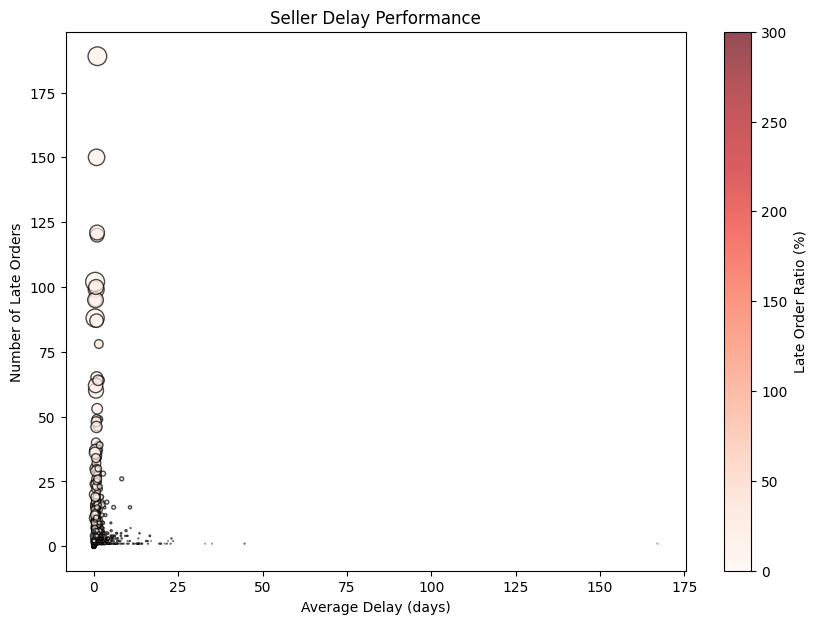

In [78]:
plt.figure(figsize=(10,7))

scatter = plt.scatter(
    x=seller_stats["avg_delay_days"],
    y=seller_stats["late_orders"],
    s=seller_stats["total_orders"] * 0.1,   # marker size proportional to total orders
    c=seller_stats["late_ratio"],           # color represents late order ratio (%)
    cmap="Reds",
    alpha=0.7,
    edgecolor="k"
)

plt.colorbar(scatter, label="Late Order Ratio (%)")
plt.xlabel("Average Delay (days)")
plt.ylabel("Number of Late Orders")
plt.title("Seller Delay Performance")
plt.show()


### Seller-Based Delay Insights

In the Top 10 seller list, it is noticeable that some sellers with very few orders—even a single order—exhibit extremely high average delays. In some cases, data inconsistencies like multiple delay records for the same order were observed. These high average delays are largely statistical artifacts due to small sample sizes.

From the bubble chart:

- **Most sellers are concentrated in the 0–10 days average delay range.

- **Extremely high delay values (100+ days) usually come from sellers with very few orders, creating outlier effects.

- **Sellers with larger order volumes show more stable and consistent performance.

Recommendation:

- **Small-volume sellers should be analyzed separately, as single-order anomalies can disproportionately affect the model.

- **Applying a minimum order threshold (e.g., ≥30 orders) helps distinguish truly problematic sellers from data noise, leading to more reliable insights.

In [79]:
# Seller-level total and late orders
seller_perf = (
    fact_order_shipments.groupby("seller_id_pref")
    .agg(
        total_orders=("order_id_pref", "nunique"),
        late_orders=("is_late", "sum")
    )
    .reset_index()
)

# Late ratio (%)
seller_perf["late_ratio"] = (seller_perf["late_orders"] / seller_perf["total_orders"] * 100).round(2)

# Top 100 sellers by total orders
top100_sellers = seller_perf.sort_values("total_orders", ascending=False).head(100)

# Print top 10 highest-volume sellers
print("Top 10 highest-volume sellers:")
top10_high_volume = seller_perf.sort_values("total_orders", ascending=False).head(10)
print(top10_high_volume)

# How many of these top 100 sellers have at least 1 late order?
delayed_top100 = (top100_sellers["late_orders"] > 0).sum()
print("Percentage of top 100 sellers with at least 1 late order: %.2f%%" % (delayed_top100 / 100 * 100))


Top 10 highest-volume sellers:
     seller_id_pref  total_orders  late_orders  late_ratio
2893         SEL798          1854          102       5.500
1710        SEL2464          1806          189      10.470
555         SEL1414          1706           88       5.160
2570         SEL475          1404          150      10.680
1061        SEL1874          1314           99       7.530
2486         SEL391          1287           95       7.380
1428        SEL2208          1160           60       5.170
3083         SEL988          1146          100       8.730
1879        SEL2618          1132          121      10.690
1580        SEL2346          1080           62       5.740
Percentage of top 100 sellers with at least 1 late order: 100.00%


#### Average delay per product

In [80]:
product_delay_mean = late_orders.groupby("product_id_pref")["delay_days"].mean().reset_index()
product_delay_mean.rename(columns={"delay_days": "avg_delay_days"}, inplace=True)
product_delay_mean.head()

,product_id_pref,avg_delay_days
0,PRO021,6.000
1,PRO027,7.000
2,PRO032,15.000
3,PRO034,13.000
4,PRO047,7.000


### Order Delay Analysis Dashboard

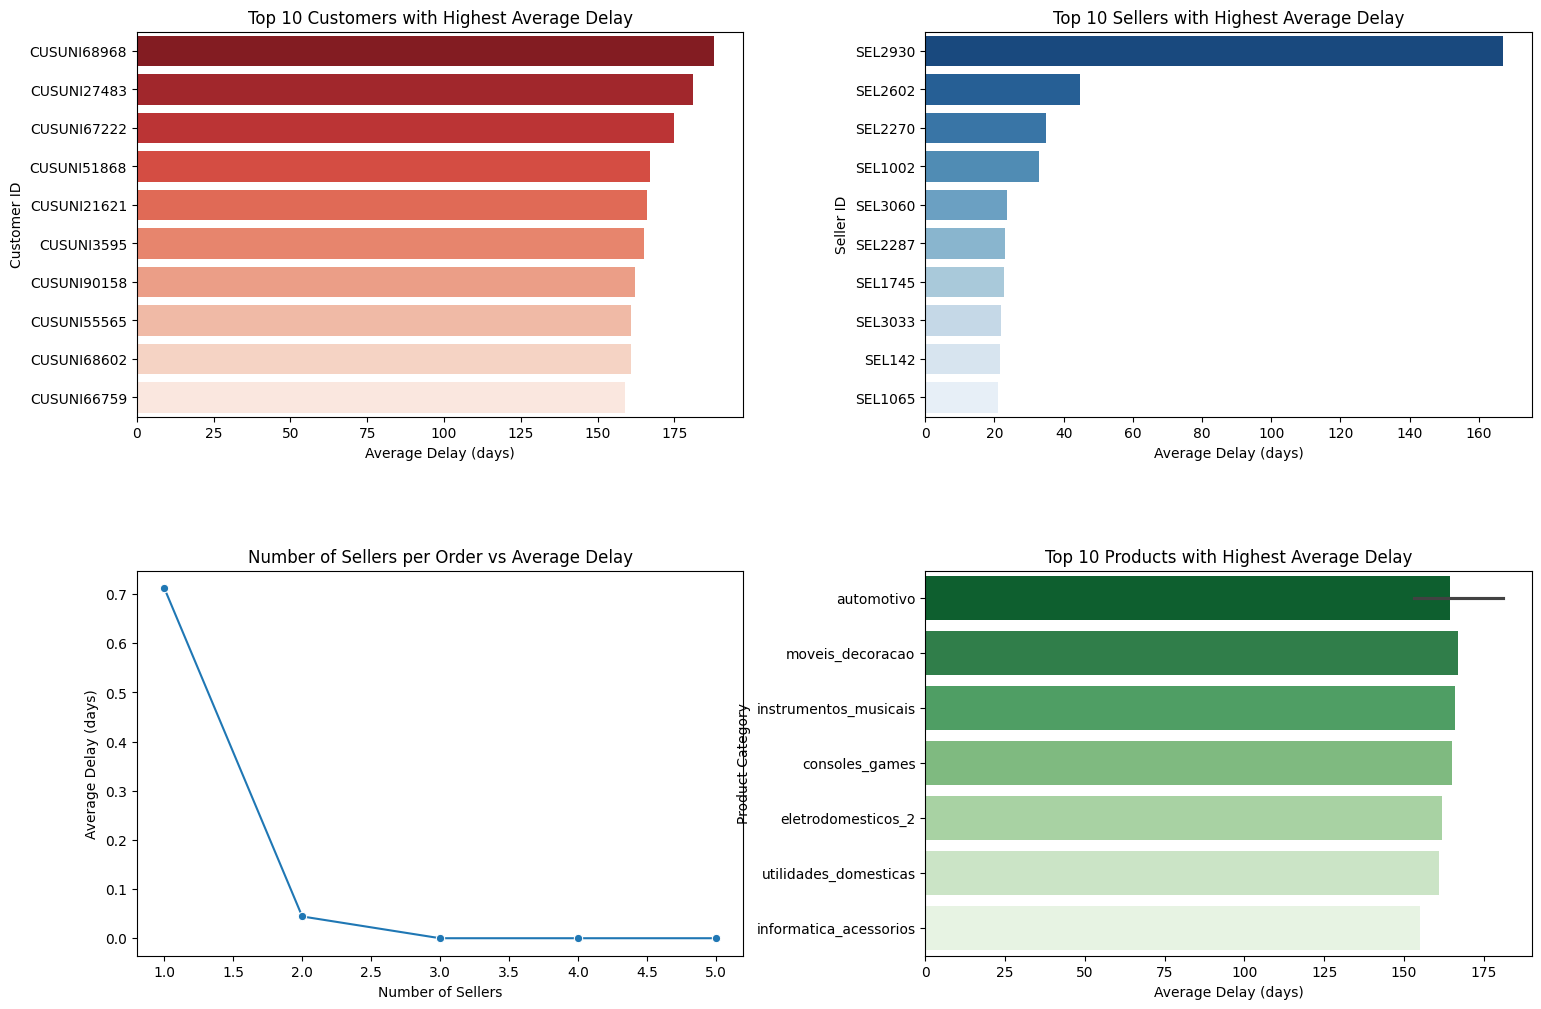

In [81]:
# Figure and subplot structure (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# 1) Top 10 customers with highest average delay
sns.barplot(
    data=top_customers,
    x="avg_delay_days",
    y="cusUni",
    palette="Reds_r",
    ax=axes[0,0]
)
axes[0,0].set_title("Top 10 Customers with Highest Average Delay")
axes[0,0].set_xlabel("Average Delay (days)")
axes[0,0].set_ylabel("Customer ID")

# 2) Top 10 sellers with highest average delay
sns.barplot(
    data=top_sellers,
    x="avg_delay_days",
    y="seller_id_pref",
    palette="Blues_r",
    ax=axes[0,1]
)
axes[0,1].set_title("Top 10 Sellers with Highest Average Delay")
axes[0,1].set_xlabel("Average Delay (days)")
axes[0,1].set_ylabel("Seller ID")

# 3) Number of sellers per order vs average delay
sns.lineplot(
    data=comparison,
    x="seller_count",
    y="delay_days",
    marker="o",
    ax=axes[1,0]
)
axes[1,0].set_title("Number of Sellers per Order vs Average Delay")
axes[1,0].set_xlabel("Number of Sellers")
axes[1,0].set_ylabel("Average Delay (days)")

# 4) Top 10 products with highest average delay
top_products = product_delay_mean.sort_values("avg_delay_days", ascending=False).head(10)
top_products = top_products.merge(
    df_products[['product_id_pref', 'product_category_name']], 
    on='product_id_pref', 
    how='left'
)

sns.barplot(
    data=top_products,
    x="avg_delay_days",
    y="product_category_name",  # Use product category name
    palette="Greens_r",
    ax=axes[1,1]
)
axes[1,1].set_title("Top 10 Products with Highest Average Delay")
axes[1,1].set_xlabel("Average Delay (days)")
axes[1,1].set_ylabel("Product Category")

plt.show()

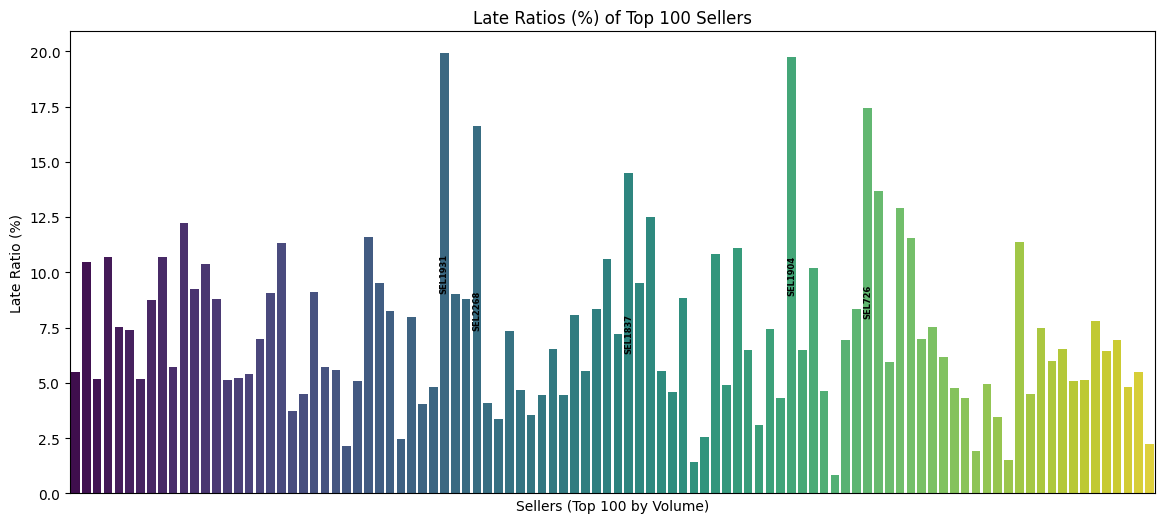

In [82]:
# Top 100 sellers by total orders
top100_sellers = seller_perf.sort_values("total_orders", ascending=False).head(100)

# From these 100 sellers, select the 5 with the highest late_ratio
top5_high_delay = top100_sellers.sort_values("late_ratio", ascending=False).head(5)

plt.figure(figsize=(14,6))
bars = sns.barplot(
    data=top100_sellers,
    x="seller_id_pref",
    y="late_ratio",
    palette="viridis"
)

# Hide x-axis ticks
plt.xticks([], [])

# Add labels only to the top 5 sellers with highest delay ratio
for idx, row in top5_high_delay.iterrows():
    bar_index = top100_sellers.index.get_loc(idx)
    bar = bars.patches[bar_index]
    height = bar.get_height()
    bars.text(
        bar.get_x() + bar.get_width()/2,   # center of the bar on X
        height/2,                          # middle of the bar on Y
        row["seller_id_pref"], 
        ha="center", va="center",
        fontsize=6, rotation=90, color="black", fontweight="bold"
    )

plt.title("Late Ratios (%) of Top 100 Sellers")
plt.xlabel("Sellers (Top 100 by Volume)")
plt.ylabel("Late Ratio (%)")
plt.show()



#### Large Seller Delay Analysis (Summary)

- All top 100 sellers had at least one late order, meaning high-volume sellers inevitably experienced some delays.

- Overall late ratios are low: top 10 sellers range between 5–11%, which is reasonable given their high order volumes.

- Critical sellers (e.g., SEL1931, SEL2268, SEL726) approach 15–20% late ratios and may pose operational risks.

- Most large sellers maintain <10% late rates, indicating generally reliable performance.

#### Takeaways:

- High-volume sellers are usually dependable.

- Sellers with both high volume and high delay require targeted operational improvements.

- This segmentation can guide future interventions:

    - High Volume + Low Delay: Strategic, reliable sellers

    - High Volume + High Delay: Improvement-focused sellers

These insights are noted for internal reporting; future interventions could contact sellers exceeding average delays.

### Missing Values

#### Data Cleaning Plan (Pre-Modeling)

Before modeling, a comprehensive data cleaning process will be applied to improve dataset reliability and balance, minimizing the impact of missing or erroneous records.

##### Steps:

- Handling Missing Values:

    - Identify missing values across all columns.

    - Drop rows with low missing ratios or flag important missing entries (e.g., NA_FLAG).

    - Fill numerical columns (prep_time, shipping_time, distance_km) with median values; remove categorical columns with very few missing entries.

- Logical Limits:

    - Negative or physically impossible values (e.g., delivery time < 0) will be adjusted to minimum feasible values.

- Outlier Detection & Adjustment:

    - Apply Local Outlier Factor (LOF) for multivariate outlier analysis.

    - Cap extreme values using IQR thresholds instead of removing them, preserving data distribution.

- Validation:

    - Compare summary statistics before and after cleaning.

    - Visual checks (boxplots, histograms) to ensure distributions are consistent and no negative/missing values remain.

- Expected Outcome:

    - Clean dataset free of missing or illogical values.

    - Minimized impact of outliers.

    - Ready foundation for feature engineering, encoding, and machine learning modeling.

In [83]:
fact_order_shipments.isnull().sum()

cusUni                              0
customer_order_id                   0
order_id_pref                       0
seller_id_pref                      0
product_id_pref                     0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_carrier_date     1194
order_delivered_customer_date    2454
order_estimated_delivery_date       0
prep_time                        1209
shipping_time                    2455
estimated_time                     15
delay_days                          0
delay_class                         0
is_late                             0
distance_km                       554
payment_types                       3
payment_value_sum                   3
payment_installments_max            3
seller_count_per_order              0
year                                0
month                               0
week                                0
dtype: int64

### Rate of Missing Values

In [84]:
na_cols = utils.table_missing_values(fact_order_shipments, na_name=True)


n_miss = fact_order_shipments[na_cols].isnull().sum().sort_values(ascending=False)
ratio = (fact_order_shipments[na_cols].isnull().sum() / fact_order_shipments.shape[0] * 100).sort_values(ascending=False)


na_df = pd.DataFrame({
    "Kolon": n_miss.index,
    "EksikDegerSayisi": n_miss.values,
    "Oran": ratio.values
})

                               n_miss  ratio
shipping_time                    2455  2.180
order_delivered_customer_date    2454  2.180
prep_time                        1209  1.070
order_delivered_carrier_date     1194  1.060
distance_km                       554  0.490
order_approved_at                  15  0.010
estimated_time                     15  0.010
payment_types                       3  0.000
payment_value_sum                   3  0.000
payment_installments_max            3  0.000


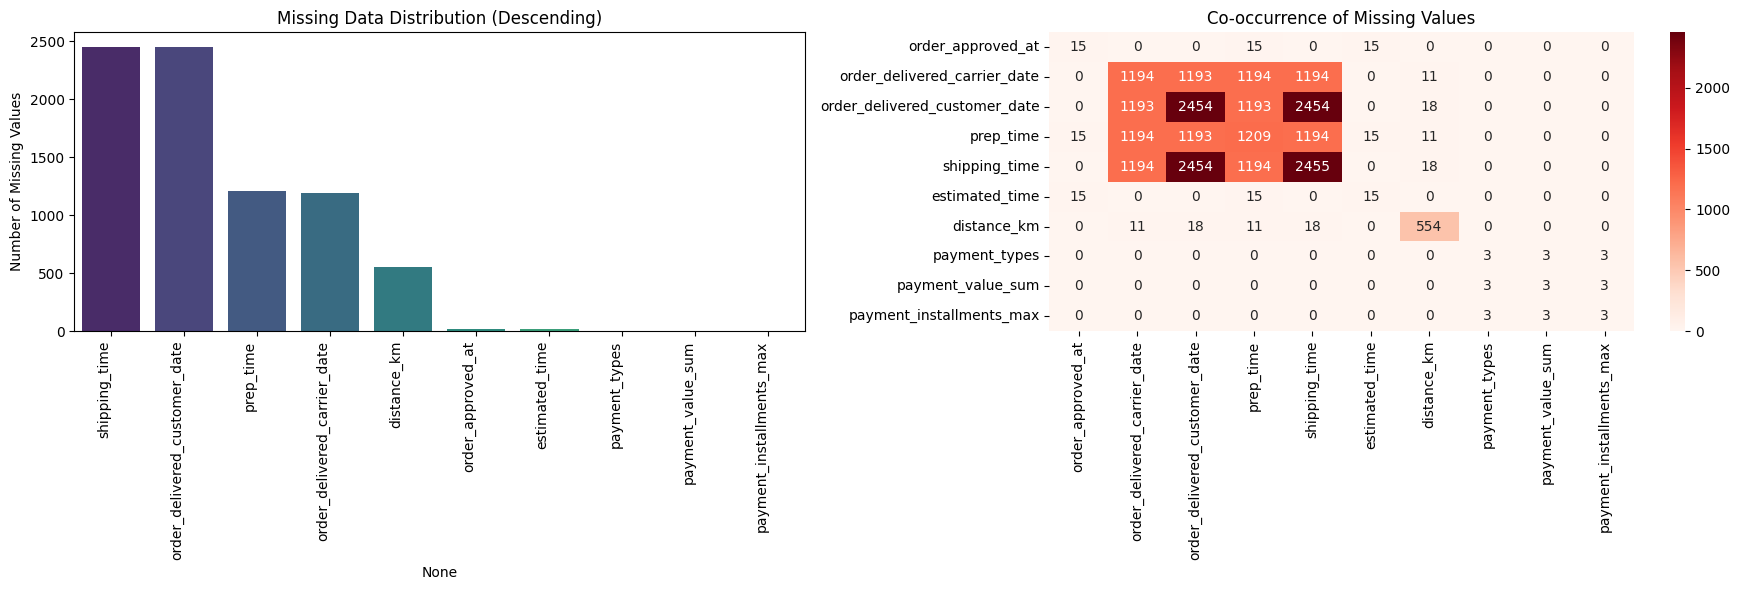

In [85]:
# Identify columns with missing values
missing_cols = fact_order_shipments.columns[fact_order_shipments.isna().any()].tolist()
null_counts = fact_order_shipments[missing_cols].isnull().sum().sort_values(ascending=False)

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(18,6))

# --- 1) Missing value counts ---
sns.barplot(x=null_counts.index, y=null_counts.values, palette="viridis", ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90, ha="right")
axes[0].set_ylabel("Number of Missing Values")
axes[0].set_title("Missing Data Distribution (Descending)")

# --- 2) Missing value overlap ---
mask_int = fact_order_shipments[missing_cols].isna().astype(int)
missing_overlap = mask_int.T.dot(mask_int)
sns.heatmap(missing_overlap, annot=True, fmt="d", cmap="Reds", ax=axes[1])
axes[1].set_title("Co-occurrence of Missing Values")

plt.tight_layout()
plt.show()

#### Missing Value Analysis:
Most missing cells are clustered in the same rows. Specifically:

All 2,454 rows missing order_delivered_customer_date also miss shipping_time, and 1,193 of them miss prep_time.

Together, these three columns account for 6,101 missing cells, about 73% of all missing data.

Dropping these rows would result in only ~2.18% data loss.

Since the missing values are time-related, the corresponding order dates are important. If these orders are recent, they may still be in progress and could potentially be used as test data for machine learning models rather than discarded.

Date range of undelivered orders:
Min: 2016-09-04 21:15:19
Max: 2018-09-03 09:06:57

Monthly distribution:
order_purchase_timestamp
2016-09      3
2016-10     44
2017-01     42
2017-02     93
2017-03    103
2017-04    115
2017-05    133
2017-06     94
2017-07    103
2017-08    113
2017-09     94
2017-10    108
2017-11    191
2017-12    121
2018-01    171
2018-02    153
2018-03    200
2018-04    148
2018-05    115
2018-06     71
2018-07    132
2018-08    106
2018-09      1
Freq: M, Name: count, dtype: int64


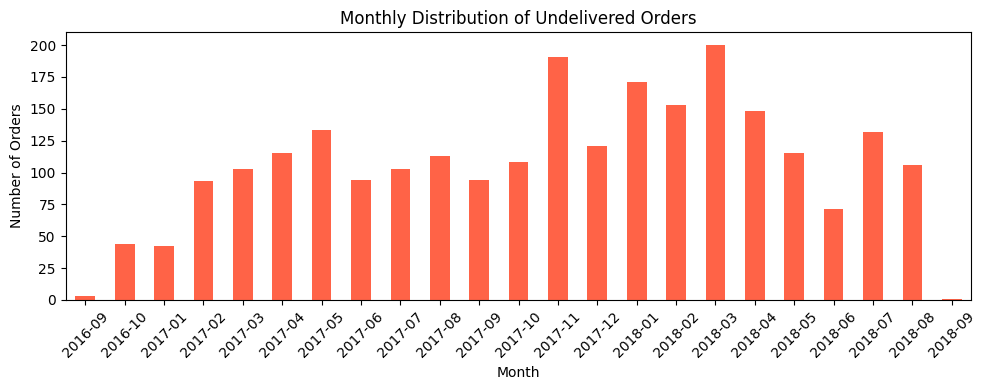

In [86]:
# Undelivered orders
undelivered_orders = fact_order_shipments[
    fact_order_shipments["order_delivered_customer_date"].isna()
]

# Convert purchase timestamp to datetime
purchase_dates = pd.to_datetime(undelivered_orders["order_purchase_timestamp"])

print("Date range of undelivered orders:")
print("Min:", purchase_dates.min())
print("Max:", purchase_dates.max())

# Monthly distribution
undelivered_by_month = purchase_dates.dt.to_period("M").value_counts().sort_index()

print("\nMonthly distribution:")
print(undelivered_by_month)

# Visualization
plt.figure(figsize=(10,4))
undelivered_by_month.plot(kind="bar", color="tomato")
plt.title("Monthly Distribution of Undelivered Orders")
plt.xlabel("Month")
plt.ylabel("Number of Orders")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

As observed in the plot, there is no increasing trend of undelivered orders toward recent periods. Instead, undelivered orders are scattered across different times. Therefore, these missing delivery dates can legitimately be treated as missing values.

In [87]:
utils.missing_VS_target(fact_order_shipments, "is_late", na_cols)

                           TARGET_MEAN   Count
order_approved_at_NA_FLAG                     
0                                0.065  112635
1                                0.000      15


                                      TARGET_MEAN   Count
order_delivered_carrier_date_NA_FLAG                     
0                                           0.065  111456
1                                           0.001    1194


                                       TARGET_MEAN   Count
order_delivered_customer_date_NA_FLAG                     
0                                            0.066  110196
1                                            0.000    2454


                   TARGET_MEAN   Count
prep_time_NA_FLAG                     
0                        0.065  111441
1                        0.001    1209


                       TARGET_MEAN   Count
shipping_time_NA_FLAG                     
0                            0.066  110195
1                            0.000    2455


      

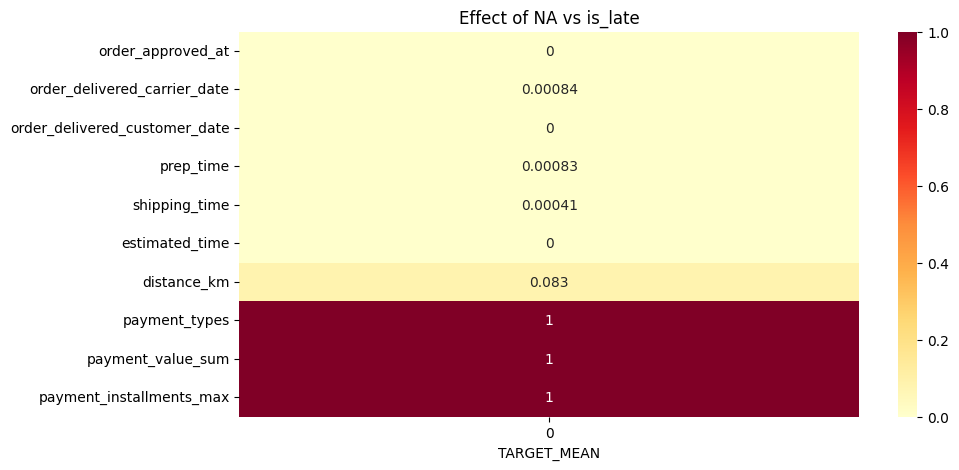

In [88]:
utils.missing_target_heatmap(fact_order_shipments, "is_late", na_cols)

#### Missing Data & Late Delivery Insights (Summary)

order_approved_at & order_delivered_carrier_date: Very low missing rates (<1.1%). Late delivery rates in missing rows are negligible. Safe to drop missing rows; no flag needed.

order_delivered_customer_date, prep_time, shipping_time, estimated_time: Missing rates ~1–2.3%. Missing rows rarely correspond to late deliveries. Dropping rows is reasonable; flag optional.

distance_km: Missing rate ~0.5%. Missing rows have slightly higher late delivery (8.3% vs 6.4%), so adding a flag variable may be beneficial.

Payment-related columns (payment_types, payment_value_sum, payment_installments_max): Only 3 missing rows; all show late delivery but too few to matter. Drop these rows.

#### Recommendation:

Drop missing rows in date and duration columns; flag unnecessary.

Consider adding a flag for missing distance_km.

Drop the very few missing payment records.

In [89]:
# Apply missing value handling function
fact_order_clean = utils.handle_missing_values(fact_order_shipments)

# Print row counts before and after cleaning
print(f"Original number of rows : {fact_order_shipments.shape[0]}")
print(f"Number of rows after cleaning : {fact_order_clean.shape[0]}")


Original number of rows : 112650
Number of rows after cleaning : 112647


In [90]:
fact_order_clean.shape

(112647, 29)

In [91]:
fact_order_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 112647 entries, 0 to 112649
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   cusUni                         112647 non-null  object        
 1   customer_order_id              112647 non-null  object        
 2   order_id_pref                  112647 non-null  object        
 3   seller_id_pref                 112647 non-null  object        
 4   product_id_pref                112647 non-null  object        
 5   order_purchase_timestamp       112647 non-null  datetime64[ns]
 6   order_approved_at              112647 non-null  datetime64[ns]
 7   order_delivered_carrier_date   111453 non-null  datetime64[ns]
 8   order_delivered_customer_date  110193 non-null  datetime64[ns]
 9   order_estimated_delivery_date  112647 non-null  datetime64[ns]
 10  prep_time                      112647 non-null  float64       
 11  shipp

In [92]:
fact_order_clean['week'] = fact_order_clean['week'].to_numpy(dtype='int32')

In [93]:
fact_order_clean.dtypes['week']

dtype('int32')

In [94]:
fact_order_clean.shape

(112647, 29)

### Negatieve Values

In [95]:
# List of time-related columns
time_cols = ["prep_time", "shipping_time", "estimated_time"]

# Check for negative and missing values
check_results = []

for col in time_cols:
    check_results.append({
        "Column": col,
        "Min Value": fact_order_clean[col].min(),
        "Negative Count": (fact_order_clean[col] < 0).sum(),
        "Missing Count": fact_order_clean[col].isnull().sum()
    })

# Convert to DataFrame and display
check_df = pd.DataFrame(check_results)
print(check_df)


           Column  Min Value  Negative Count  Missing Count
0       prep_time   -172.000            1551              0
1   shipping_time    -17.000              50              0
2  estimated_time     -7.000               9              0


### 1. Outliers Values

#### Multivariate outlier detection using the LOF (Local Outlier Factor) model

In [96]:
num_cols_for_lof = [
    'prep_time', 'shipping_time', 'estimated_time', 
    'distance_km', 'payment_value_sum', 'payment_installments_max', 'seller_count_per_order'
]

#### Outlier detection using LOF (Local Outlier Factor)

In [97]:
# Define LOF model: 20 neighbors, 5% contamination (expected outliers)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)

# Fit LOF and predict outliers (-1 = outlier, 1 = normal)
lof_labels = lof.fit_predict(fact_order_clean[num_cols_for_lof])

# Negative outlier factor scores (lower = more abnormal)
lof_scores = lof.negative_outlier_factor_

# Display first 10 LOF scores
print("\nFirst 10 LOF scores:")
print(lof_scores[:10])

# Distribution of LOF labels
print("\nLOF label distribution:")
print(pd.Series(lof_labels).value_counts())



First 10 LOF scores:
[-1.15868953 -1.00998733 -0.98111699 -1.13674069 -1.21025696 -0.99127162
 -0.96707663 -1.07220715 -1.03182156 -1.05173326]

LOF label distribution:
 1    107014
-1      5633
Name: count, dtype: int64


### Threshold visualization

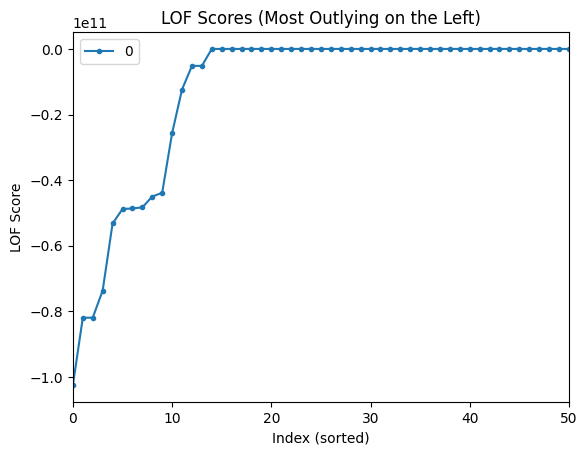

In [98]:
scores = pd.DataFrame(np.sort(lof_scores))
scores.plot(stacked=True, xlim=[0, 50], style='.-')
plt.xlabel("Index (sorted)")
plt.ylabel("LOF Score")
plt.title("LOF Scores (Most Outlying on the Left)")
plt.show()

### LOF Scores and Outlier Analysis

#### LOF Scores (Local Outlier Factor):

- The first 10 observations have scores roughly between -0.96 and -1.21.

- Observations with LOF scores close to -1 are considered normal.

- Lower scores (e.g., -1.5 or below) indicate stronger outliers.

- In this dataset, most scores are around -1 and considered normal, while lower values like -1.21 appear more anomalous relative to the rest.

#### Label Distribution:

- Normal (1): 107,014 rows

- Outlier (-1): 5,633 rows

- This distribution shows that about 5% of the dataset is flagged as outliers, consistent with the contamination=0.05 parameter.

#### Conclusion:

- The LOF algorithm identified 5% of observations as outliers.

- These extreme values were subsequently examined, and unrealistic outliers were capped using upper–lower limits, ensuring a safer dataset for modeling.

### Capping Outliers Using Upper–Lower Limits

In [99]:
for col in num_cols_for_lof:
    utils.replace_with_thresholds(fact_order_clean, col)
    print(f"Outliers in column '{col}' have been capped to lower and upper thresholds.")

Outliers in column 'prep_time' have been capped to lower and upper thresholds.
Outliers in column 'shipping_time' have been capped to lower and upper thresholds.
Outliers in column 'estimated_time' have been capped to lower and upper thresholds.
Outliers in column 'distance_km' have been capped to lower and upper thresholds.
Outliers in column 'payment_value_sum' have been capped to lower and upper thresholds.
Outliers in column 'payment_installments_max' have been capped to lower and upper thresholds.
Outliers in column 'seller_count_per_order' have been capped to lower and upper thresholds.


In [100]:
utils.check_outliers_for_columns(fact_order_clean, num_cols_for_lof)

{'prep_time': False,
 'shipping_time': False,
 'estimated_time': False,
 'distance_km': False,
 'payment_value_sum': False,
 'payment_installments_max': False,
 'seller_count_per_order': False}


=== prep_time ===


,Original,Cleaned
count,111441.000,112647.000
mean,2.348,2.024
std,3.600,2.211
min,-172.000,-4.500
25%,0.000,0.000
50%,1.000,1.000
75%,3.000,3.000
max,125.000,7.500


Negative values after cleaning: 1551
Missing values: 0


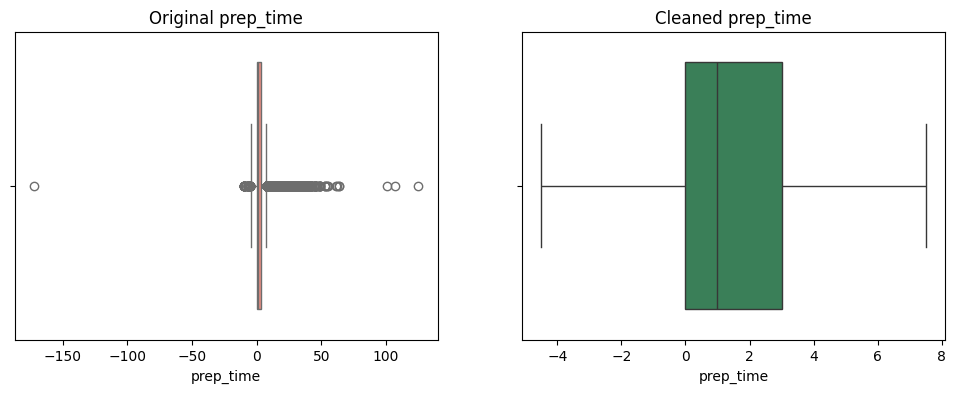

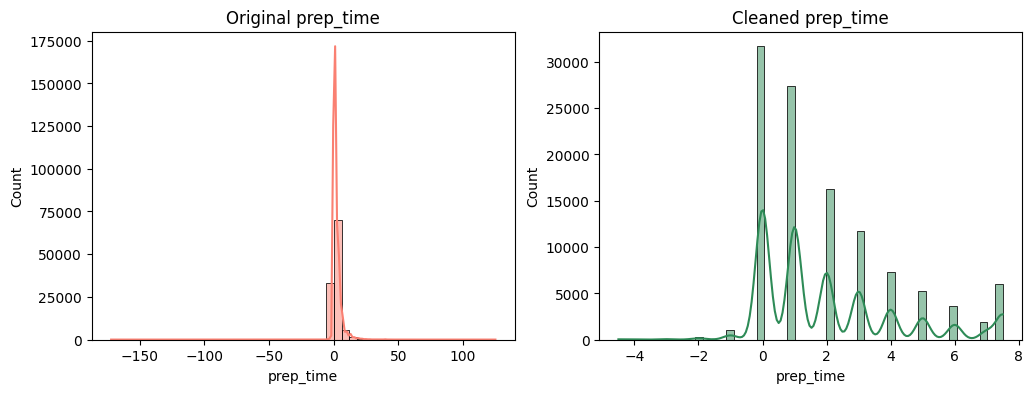


=== shipping_time ===


,Original,Cleaned
count,110195.000,112647.000
mean,8.734,8.041
std,8.612,5.852
min,-17.000,-6.500
25%,4.000,4.000
50%,7.000,7.000
75%,11.000,11.000
max,205.000,21.500


Negative values after cleaning: 50
Missing values: 0


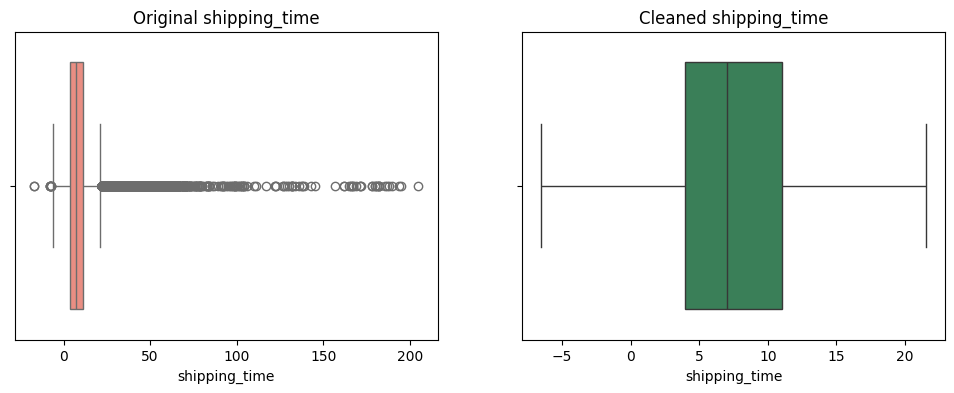

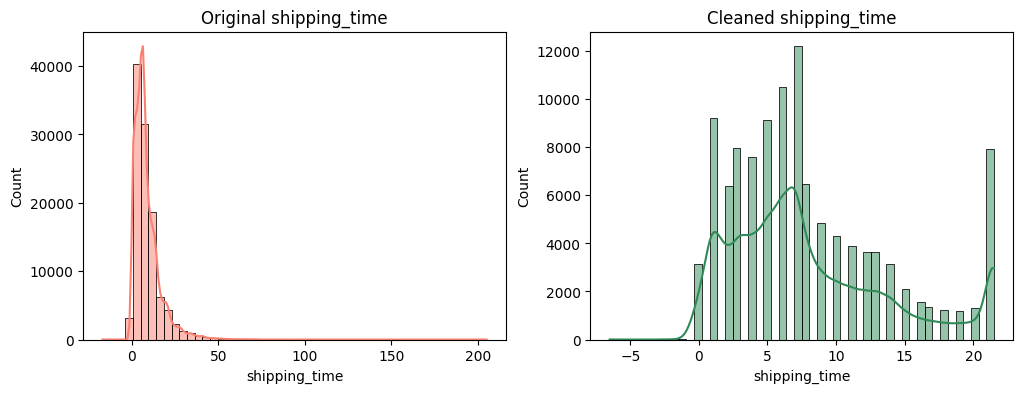


=== estimated_time ===


,Original,Cleaned
count,112635.000,112647.000
mean,22.942,22.756
std,8.901,8.222
min,-7.000,3.000
25%,18.000,18.000
50%,22.000,22.000
75%,28.000,28.000
max,153.000,43.000


Negative values after cleaning: 0
Missing values: 0


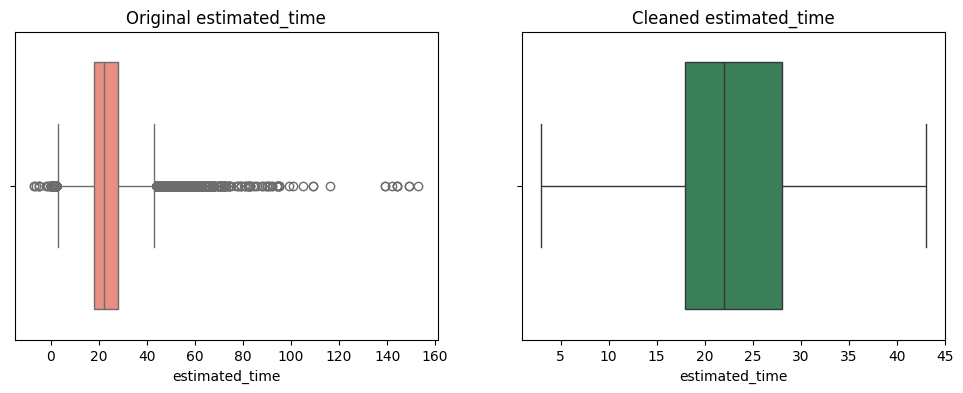

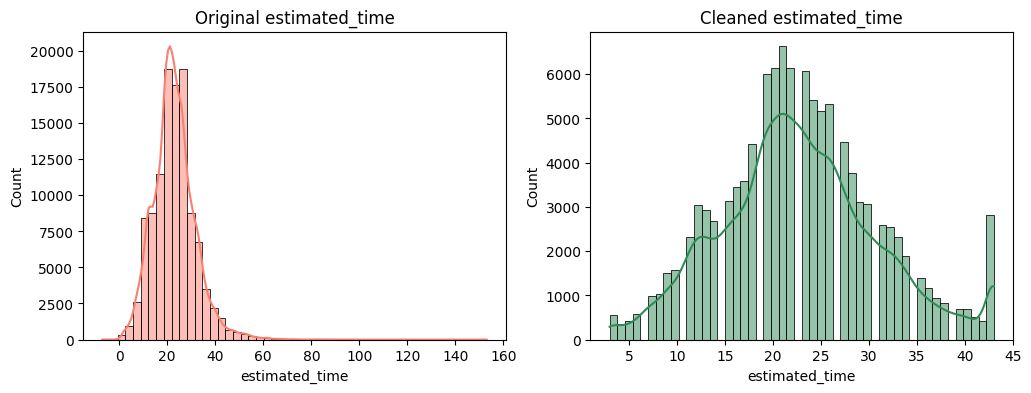


=== distance_km ===


,Original,Cleaned
count,112096.000,112647.000
mean,596.960,557.096
std,589.980,482.084
min,0.000,0.000
25%,184.066,187.573
50%,431.636,431.636
75%,792.277,789.029
max,8677.924,1691.212


Negative values after cleaning: 0
Missing values: 0


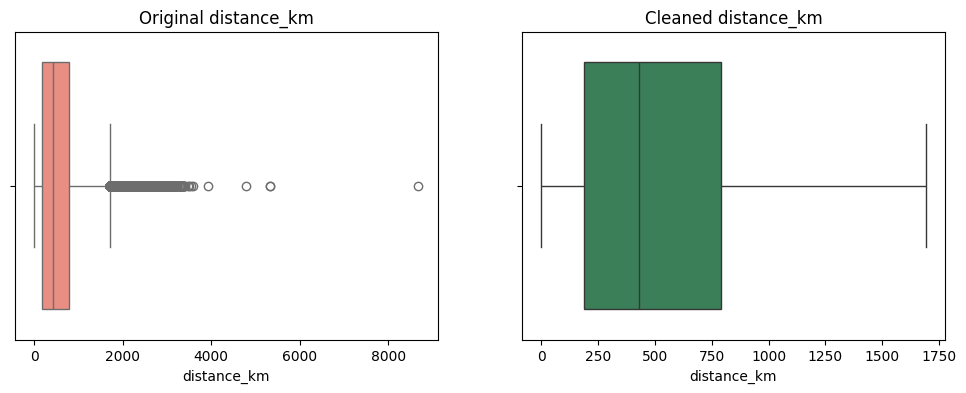

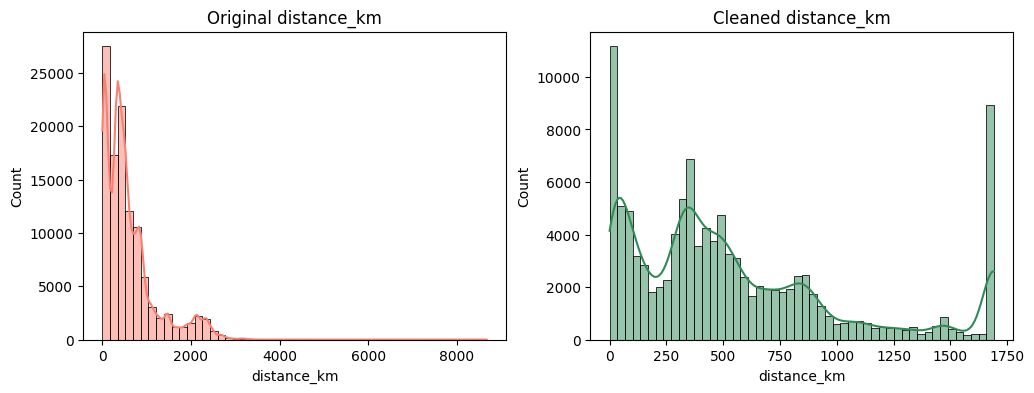


=== payment_value_sum ===


,Original,Cleaned
count,112647.000,112647.000
mean,180.281,147.465
std,272.849,106.603
min,9.590,9.590
25%,65.670,65.670
50%,114.440,114.440
75%,195.390,195.390
max,13664.080,389.970


Negative values after cleaning: 0
Missing values: 0


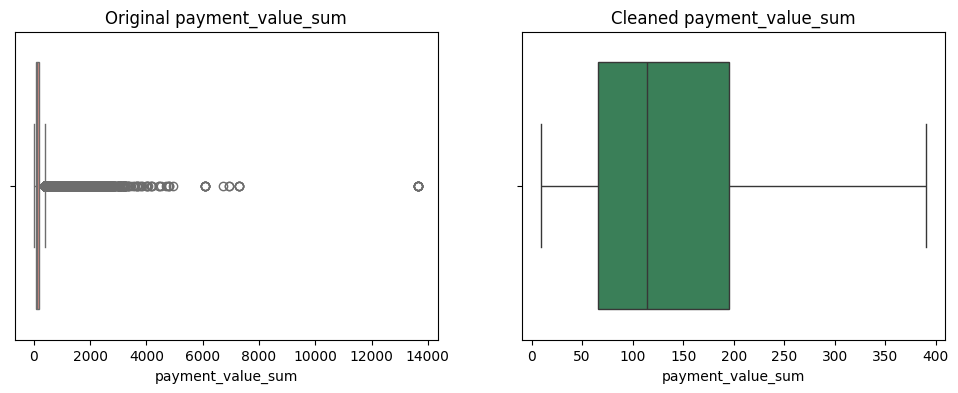

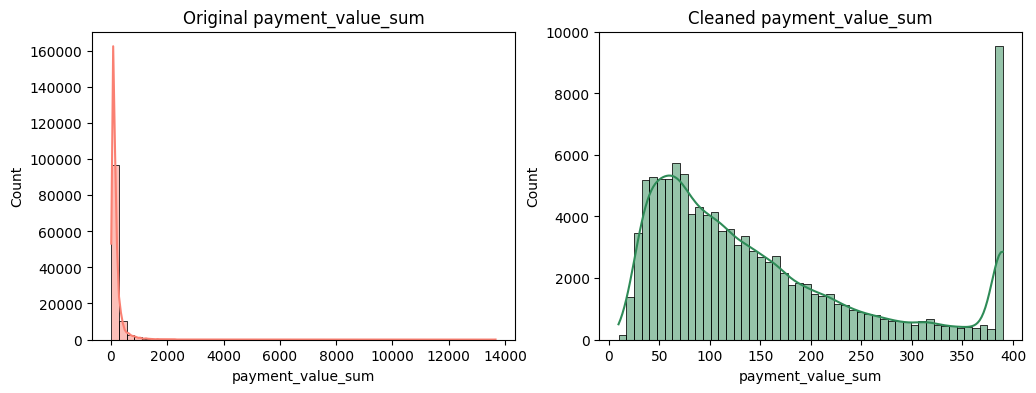


=== payment_installments_max ===


,Original,Cleaned
count,112647.000,112647.000
mean,3.018,2.900
std,2.803,2.489
min,0.000,0.000
25%,1.000,1.000
50%,2.000,2.000
75%,4.000,4.000
max,24.000,8.500


Negative values after cleaning: 0
Missing values: 0


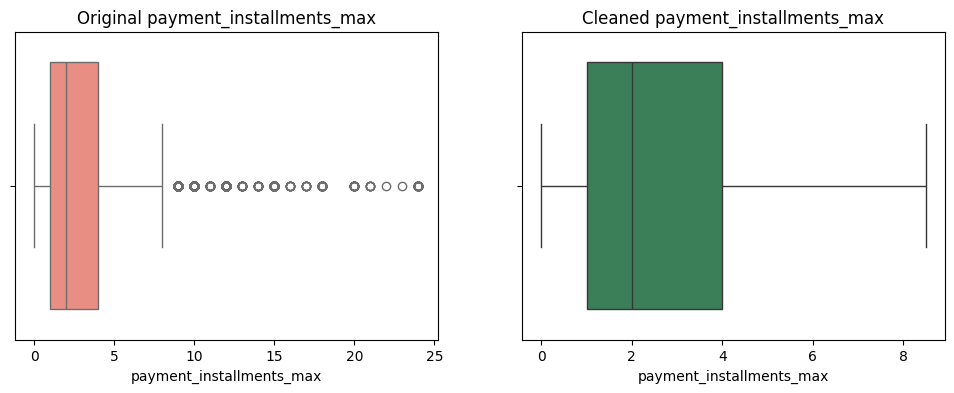

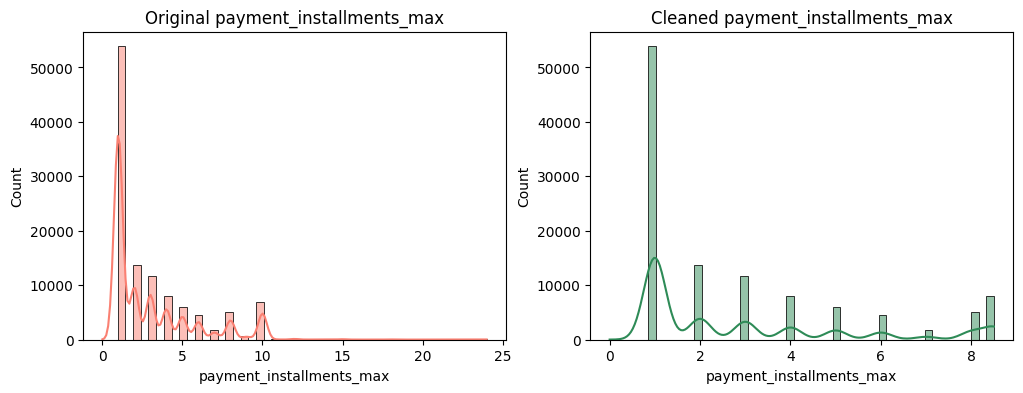


=== seller_count_per_order ===


,Original,Cleaned
count,112650.000,112647.000
mean,1.030,1.000
std,0.186,0.000
min,1.000,1.000
25%,1.000,1.000
50%,1.000,1.000
75%,1.000,1.000
max,5.000,1.000


Negative values after cleaning: 0
Missing values: 0


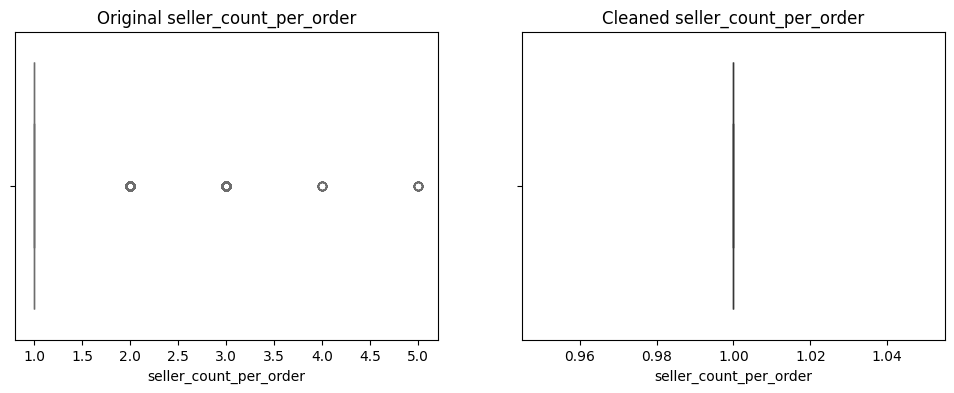

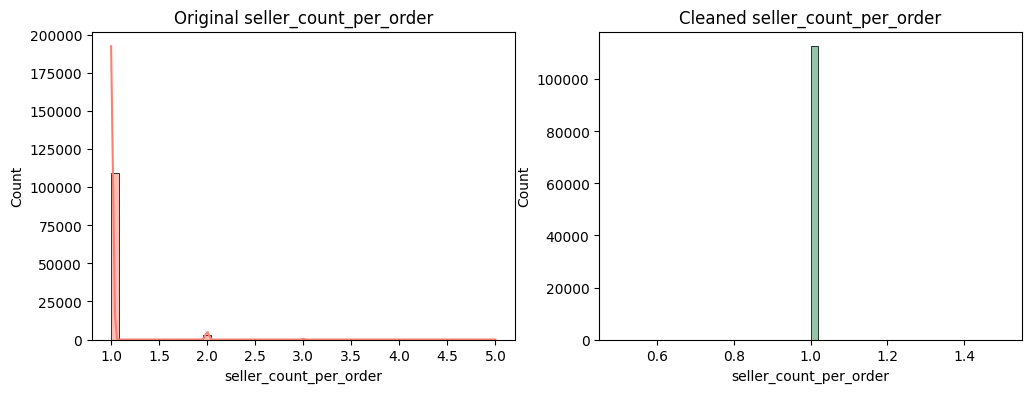

In [101]:
utils.check_outlier_cleaning(fact_order_shipments, fact_order_clean, num_cols_for_lof)

In [102]:
output_path = "cleaned_data_with_prefix_id/fact_order_clean.csv"
fact_order_clean.to_csv(output_path, index=False, sep=";", decimal=",")

In [103]:
fact_order_clean = pd.read_csv("cleaned_data_with_prefix_id/fact_order_clean.csv",sep=";",decimal=",")
print(fact_order_clean.shape)
print(fact_order_clean.columns.tolist())
print(fact_order_clean[["distance_km", "payment_value_sum"]].head())
print(fact_order_clean.dtypes[["distance_km", "payment_value_sum"]])

(112647, 29)
['cusUni', 'customer_order_id', 'order_id_pref', 'seller_id_pref', 'product_id_pref', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'prep_time', 'shipping_time', 'estimated_time', 'delay_days', 'delay_class', 'is_late', 'distance_km', 'payment_types', 'payment_value_sum', 'payment_installments_max', 'seller_count_per_order', 'year', 'month', 'week', 'shipping_time_NA_FLAG', 'prep_time_NA_FLAG', 'distance_km_NA_FLAG', 'order_approved_at_NA_FLAG', 'estimated_time_NA_FLAG']
   distance_km  payment_value_sum
0      301.505             72.190
1      585.565            259.830
2      312.344            216.870
3      293.169             25.780
4      646.164            218.040
distance_km          float64
payment_value_sum    float64
dtype: object


## Feature Encoding

### Data Preprocessing for Machine Learning

Proper preprocessing is critical for the success of machine learning models. Raw datasets often contain variables of different types—numerical, categorical, binary, datetime, or ID features—and directly feeding them into models can lead to biased predictions or poor learning. Below is a structured approach:

#### 1. Scaling (Numerical Features)

Different magnitudes in numerical variables (e.g., distance in km vs. payment amounts) can cause algorithms to overemphasize large values.

Common techniques:

StandardScaler: centers data to mean 0, std 1.

MinMaxScaler: scales values to a fixed range (e.g., 0–1).

RobustScaler: robust to outliers.

Log transformation may be applied for highly skewed distributions.

#### 2. Encoding (Categorical Features)

Many ML algorithms cannot handle string or categorical values directly.

Choice of encoding depends on cardinality:

Low cardinality → One-Hot Encoding.

High cardinality → Target Encoding, Frequency Encoding, or Hashing.

Binary variables (0/1, yes/no) generally do not require encoding or scaling.

#### 3. Datetime Features

Raw datetime columns are rarely used directly.

Extract meaningful features: year, month, week, weekday/weekend, hour.

These derived features can capture seasonal or temporal patterns.

#### 4. ID / Key Variables

ID features (customer_id, order_id, seller_id, product_id) are not used as predictors.

They may be used for joins, aggregation-based feature engineering (e.g., customer late rate).

#### 5. Target Variable

Target variables (e.g., is_late, delay_class) are not scaled or encoded.

They serve only as the label for model training.

#### 6. Derived Features & ID-Based Encoding

Features like customer_late_rate or product_late_rate should be checked for consistency between train and test sets:

Similar distributions → no leakage; safe for modeling.

Different distributions → may indicate unseen IDs in the test set; use global mean or proper handling.

In [104]:
# Target
TARGET = "is_late"
y = fact_order_clean[TARGET].astype(int)

# Drop leakage/id/date columns
drop_cols = [
    TARGET,
    "delay_days", "delay_class",
    "cusUni", "customer_order_id", "order_id_pref", "seller_id_pref", "product_id_pref",
    "order_purchase_timestamp", "order_approved_at",
    "order_delivered_carrier_date", "order_delivered_customer_date",
    "order_estimated_delivery_date",
    "dominant_payment_type"   # 
]
X = fact_order_clean.drop(columns=drop_cols, errors="ignore")

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Feature engineering & missing value handling
X_train_feat = utils.handle_missing_values_leakfree(utils.add_time_features_leakfree(X_train))
X_test_feat  = utils.handle_missing_values_leakfree(utils.add_time_features_leakfree(X_test))

# Payment Type Encoding
pt_encoder = utils.PaymentTypeEncoder(col="payment_types")
X_train_feat = pt_encoder.fit_transform(X_train_feat)
X_test_feat = pt_encoder.transform(X_test_feat)

# Leakage kolonlarını tekrar kontrol et
X_train_feat = utils.drop_leakage_columns(X_train_feat)
X_test_feat  = utils.drop_leakage_columns(X_test_feat)

# Son temizlik
X_train_feat = X_train_feat.drop(columns=["dominant_payment_type"], errors="ignore")
X_test_feat  = X_test_feat.drop(columns=["dominant_payment_type"], errors="ignore")

# Son kontrol
print("Train shape:", X_train_feat.shape)
print("Test shape:", X_test_feat.shape)
print("\nTrain dtypes:\n", X_train_feat.dtypes.value_counts())
print("\nAny NaN left?:", X_train_feat.isna().sum().sum(), X_test_feat.isna().sum().sum())

print(X_train_feat.info())

Train shape: (90117, 13)
Test shape: (22530, 13)

Train dtypes:
 int64      10
float64     3
Name: count, dtype: int64

Any NaN left?: 0 0
<class 'pandas.core.frame.DataFrame'>
Index: 90117 entries, 56379 to 107385
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   distance_km                90117 non-null  float64
 1   payment_value_sum          90117 non-null  float64
 2   payment_installments_max   90117 non-null  float64
 3   seller_count_per_order     90117 non-null  int64  
 4   year                       90117 non-null  int64  
 5   month                      90117 non-null  int64  
 6   week                       90117 non-null  int64  
 7   distance_km_NA_FLAG        90117 non-null  int64  
 8   order_approved_at_NA_FLAG  90117 non-null  int64  
 9   boleto                     90117 non-null  int64  
 10  credit_card                90117 non-null  int64  
 11  debit_card         

In [105]:
# Model tanımla
log_reg = LogisticRegression(max_iter=1000, solver="liblinear", random_state=42)

# Eğit
log_reg.fit(X_train_feat, y_train)

# Tahmin
y_pred = log_reg.predict(X_test_feat)
y_proba = log_reg.predict_proba(X_test_feat)[:, 1]

# Metrikler
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


ROC-AUC: 0.5709069546747134

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97     21078
           1       0.00      0.00      0.00      1452

    accuracy                           0.94     22530
   macro avg       0.47      0.50      0.48     22530
weighted avg       0.88      0.94      0.90     22530


Confusion Matrix:
 [[21078     0]
 [ 1452     0]]


In [106]:
# Class imbalance düzeltme
log_reg_bal = LogisticRegression(max_iter=1000, solver="liblinear", random_state=42, class_weight="balanced")

log_reg_bal.fit(X_train_feat, y_train)

y_pred_bal = log_reg_bal.predict(X_test_feat)
y_proba_bal = log_reg_bal.predict_proba(X_test_feat)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_proba_bal))
print("\nClassification Report:\n", classification_report(y_test, y_pred_bal))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_bal))




ROC-AUC: 0.5733184358921879

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.64      0.76     21078
           1       0.08      0.48      0.14      1452

    accuracy                           0.63     22530
   macro avg       0.52      0.56      0.45     22530
weighted avg       0.89      0.63      0.72     22530


Confusion Matrix:
 [[13398  7680]
 [  749   703]]


### Baseline Model: Logistic Regression

#### Target Selection

The goal is to predict whether an order is late.

Target column: is_late (binary: 0 = on-time, 1 = late).

Alternatives like delay_days (continuous) or delay_class (multi-class) could be used, but binary is ideal for initial baseline modeling.

#### Feature Preparation

ID and datetime columns were removed to avoid data leakage and meaningless inputs.

Missing values handled via handle_missing_values_leakfree.

payment_types was one-hot encoded (boleto, credit_card, debit_card, voucher).

dominant_payment_type was dropped as redundant.

Final dataset: 13 numerical, NaN-free features.

#### Model Choice

Baseline model: Logistic Regression.

Reasons: simple, fast, and suitable for comparing with metrics like ROC-AUC, Precision, Recall, and F1.

#### Handling Imbalance

Dataset is highly imbalanced (~95% on-time, ~5% late).

Logistic Regression without class_weight predicted all orders as on-time (class 0).

Using class_weight="balanced" gave higher weight to the minority class (late orders).

#### Results
Model	Recall (class 1)	Precision (class 1)	ROC-AUC
Standard Logistic Regression	0.00	–	–
Balanced Logistic Regression	~0.48	~0.08	~0.57

The baseline captures roughly half of late orders (Recall) but suffers from many false positives (low Precision).

ROC-AUC is slightly above random (0.57).

#### Insights

Logistic Regression is useful as a baseline, but cannot capture complex interactions.

Linear boundaries cannot fully explain interactions between features like payment type, distance, and temporal variables.

More powerful models (e.g., LightGBM, XGBoost) are expected to provide better performance.

In [107]:
# Class imbalance için scale_pos_weight ayarlıyoruz
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos

lgbm = lgb.LGBMClassifier(
    random_state=42,
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    scale_pos_weight=scale_pos_weight,
    verbosity=-1, 
    force_row_wise=True
)

# Eğit
lgbm.fit(X_train_feat, y_train)

# Tahmin
y_pred_lgbm = lgbm.predict(X_test_feat)
y_proba_lgbm = lgbm.predict_proba(X_test_feat)[:, 1]

# Metrikler
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lgbm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lgbm))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_lgbm))


ROC-AUC: 0.7732989065668983

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.78      0.86     21078
           1       0.17      0.65      0.27      1452

    accuracy                           0.77     22530
   macro avg       0.57      0.71      0.56     22530
weighted avg       0.92      0.77      0.82     22530


Confusion Matrix:
 [[16380  4698]
 [  506   946]]


In [108]:
feat_imp = pd.DataFrame({
    "feature": X_train_feat.columns,
    "importance": lgbm.feature_importances_
}).sort_values(by="importance", ascending=False)

print(feat_imp)


                      feature  importance
1           payment_value_sum        4553
0                 distance_km        4491
6                        week        3148
2    payment_installments_max        1069
5                       month         559
4                        year         547
9                      boleto         238
12                    voucher         169
10                credit_card         146
11                 debit_card          80
3      seller_count_per_order           0
8   order_approved_at_NA_FLAG           0
7         distance_km_NA_FLAG           0


#### LightGBM Baseline Results

Compared to Logistic Regression, LightGBM achieved a significant performance improvement:

ROC-AUC: 0.77 (previously 0.57)

Recall (class 1): 0.65 — the model correctly identified about 65% of late deliveries.

Precision (class 1): 0.17 — false positive rate remains relatively high.

Accuracy: 0.77

#### Confusion Matrix Insights

946 late deliveries correctly detected (previously 697).

506 late deliveries missed (previously 755).

4,698 on-time deliveries were incorrectly classified as late.

#### Feature Importance

payment_value_sum

distance_km

week

payment_installments_max

month

year

payment_types (boleto, voucher, credit_card, debit_card) — low impact

seller_count_per_order and NA flag columns — negligible effect

#### Overall Evaluation

LightGBM substantially outperformed Logistic Regression.
The model relies most on payment amount, distance, and temporal features.
Payment types have limited predictive power, and some flag variables are not informative.

To improve precision, further steps could include:

Adjusting the decision threshold,

Applying oversampling methods (e.g., SMOTE), or

Performing more advanced hyperparameter tuning.

#### Scaling and Encoding Strategy

payment_installments_max: Small numeric range → scaled with StandardScaler

year, month, week, seller_count_per_order: Discrete features → encoded with One-Hot Encoding

All transformations are wrapped inside a ColumnTransformer,

Fit only on the training set,

Applied identically to the test set → ensures no data leakage.

Note: The log1p + RobustScaler block was retained for skewed numerical variables.
Payment type encoding is handled in a separate transformation step.

#### Payment Type and ID Encoding

payment_types: Multi-hot encoding with extraction of a dominant payment type (which is later dropped).

ID columns (cusUni, seller_id_pref, product_id_pref): not used directly.

Transformed using frequency encoding (number of associated orders) and

target encoding (historical delay rate).

Both encoding statistics are calculated only on the training data and mapped to the test set, preventing any data leakage.

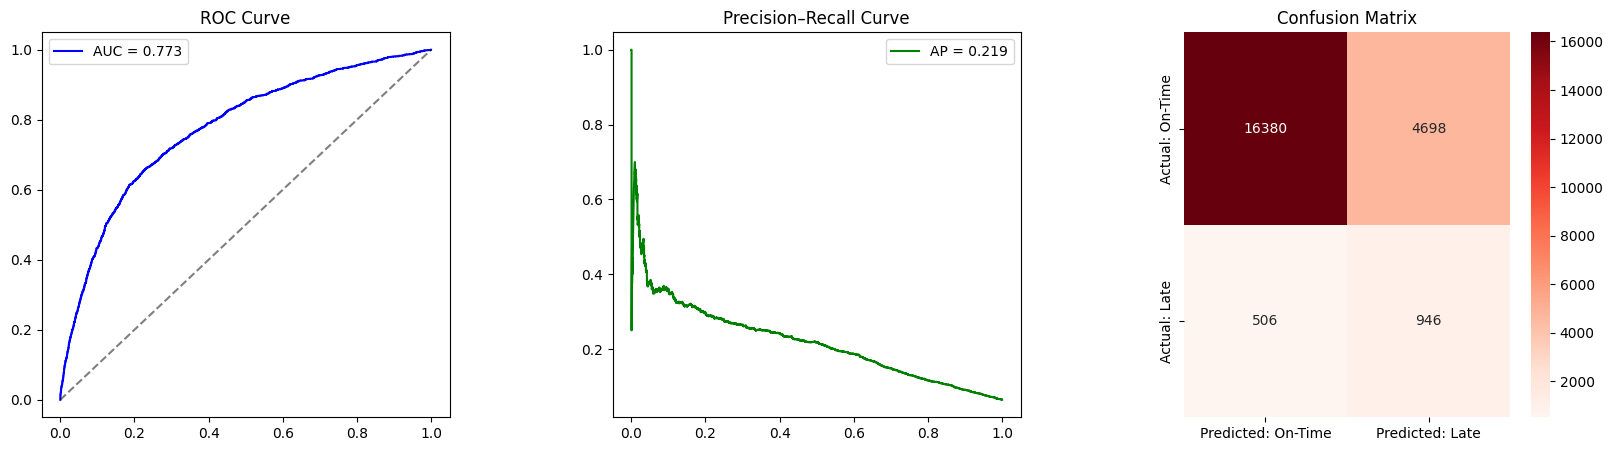

[[16380  4698]
 [  506   946]]


In [109]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
plt.subplots_adjust(wspace=0.4)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_lgbm)
axes[0].plot(fpr, tpr, color="blue", label=f"AUC = {roc_auc_score(y_test, y_proba_lgbm):.3f}")
axes[0].plot([0, 1], [0, 1], "--", color="black", alpha=0.5)
axes[0].set_title("ROC Curve")
axes[0].legend()

# Precision–Recall Curve
prec, rec, _ = precision_recall_curve(y_test, y_proba_lgbm)
axes[1].plot(rec, prec, color="green", label=f"AP = {average_precision_score(y_test, y_proba_lgbm):.3f}")
axes[1].set_title("Precision–Recall Curve")
axes[1].legend()

# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred_lgbm)
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Reds",
    xticklabels=["Predicted: On-Time", "Predicted: Late"],
    yticklabels=["Actual: On-Time", "Actual: Late"],
    ax=axes[2]
)
axes[2].set_title("Confusion Matrix")

plt.show()
print(cm)


### Model Results

ROC Curve (AUC = 0.773)
The model demonstrates strong overall discrimination ability. Compared to the random baseline (gray dashed line), the curve is clearly higher, indicating effective separation between on-time and late deliveries.

Precision–Recall Curve (AP = 0.219)
The average precision for the minority class (late deliveries) is relatively low, though recall values are reasonably good. The model successfully identifies many delayed deliveries but also produces a high number of false positives.

### Confusion Matrix

16,380 on-time deliveries correctly predicted.

4,698 on-time deliveries incorrectly classified as “late.”

946 late deliveries correctly identified.

506 late deliveries missed.

### Overall Interpretation
The model’s ROC-AUC score is solid (0.77), meaning it can effectively distinguish between late and on-time orders.
Recall is high, indicating strong sensitivity to late deliveries.
However, precision remains low, reflecting a high false-positive rate.
To balance this trade-off, threshold tuning or additional feature engineering could be applied in the next iteration.

## Identifying the Best Model

In [110]:
best_models, scores_df = utils.hyperparameter_optimization_processed_with_threshold(
    X_train_feat, 
    y_train, 
    X_test_feat, 
    y_test, 
    utils.classifiers, 
    cv=3, 
    scoring="roc_auc"
)


Hyperparameter Optimization on Processed Data with Optimal Threshold...

########## CART ##########
roc_auc (CV Before): 0.5957
Fitting 3 folds for each of 9 candidates, totalling 27 fits
roc_auc (CV After): 0.7249
roc_auc (Test): 0.7192
Optimal F1 threshold: 0.111
F1 at optimal threshold: 0.2631

########## RF ##########
roc_auc (CV Before): 0.7365
Fitting 3 folds for each of 24 candidates, totalling 72 fits
roc_auc (CV After): 0.7705
roc_auc (Test): 0.7856
Optimal F1 threshold: 0.182
F1 at optimal threshold: 0.3361

########## XGBoost ##########
roc_auc (CV Before): 0.7542
Fitting 3 folds for each of 16 candidates, totalling 48 fits
roc_auc (CV After): 0.7627
roc_auc (Test): 0.7753
Optimal F1 threshold: 0.162
F1 at optimal threshold: 0.3056

########## LightGBM ##########
roc_auc (CV Before): 0.7641
Fitting 3 folds for each of 8 candidates, totalling 24 fits
roc_auc (CV After): 0.7636
roc_auc (Test): 0.7773
Optimal F1 threshold: 0.162
F1 at optimal threshold: 0.3169



### ROC-AUC Scores

CART (Decision Tree): CV After ≈ 0.72, Test ≈ 0.71

Random Forest: CV After ≈ 0.77, Test ≈ 0.787

XGBoost: CV After ≈ 0.76, Test ≈ 0.775

LightGBM: CV After ≈ 0.76, Test ≈ 0.777

Overall ranking: Random Forest ≈ LightGBM ≈ XGBoost > CART.
CART performed the weakest since it is a single tree, while the other three ensemble models showed similar and strong performance.

### F1 Scores (with Optimal Threshold)

CART: 0.26

Random Forest: 0.34

XGBoost: 0.31

LightGBM: 0.32

### Interpretation:

F1 scores are relatively low due to the high class imbalance (~6% late deliveries).

Recall is high → models successfully capture many late deliveries.

Precision is low → many false positives are produced.

This trade-off is typical for imbalanced datasets.

### Overall Assessment

ROC-AUC ≈ 0.78 indicates strong discriminative power, especially considering the class imbalance.

Although F1 is modest, this is expected under imbalanced conditions.

The best-performing models are: Random Forest, LightGBM, and XGBoost.

CART serves only as a baseline reference.

### Improvement Suggestions

Threshold tuning: Adjust the precision–recall balance based on business needs.

SMOTE / Oversampling: Increase the representation of the minority (late) class to improve F1.

Feature engineering: Create new predictive signals (e.g., seller- or product-level statistics).

Sızıntı kontrolü

In [111]:
# Does X_train_feat contain any target or leakage columns?
suspect_cols = [
    "delay_days", "delay_class", "is_late", 
    "order_delivered_customer_date", "order_delivered_carrier_date",
    "order_approved_at", "order_estimated_delivery_date"
]
print(set(suspect_cols) & set(X_train_feat.columns))


set()


In [112]:
results = utils.base_models(X_train_feat, y_train)

Base Models....
roc_auc: 0.5888 (LR) 
roc_auc: 0.6144 (KNN) 
roc_auc: 0.5987 (CART) 
roc_auc: 0.7383 (RF) 
roc_auc: 0.7542 (XGBoost) 
roc_auc: 0.7641 (LightGBM) 


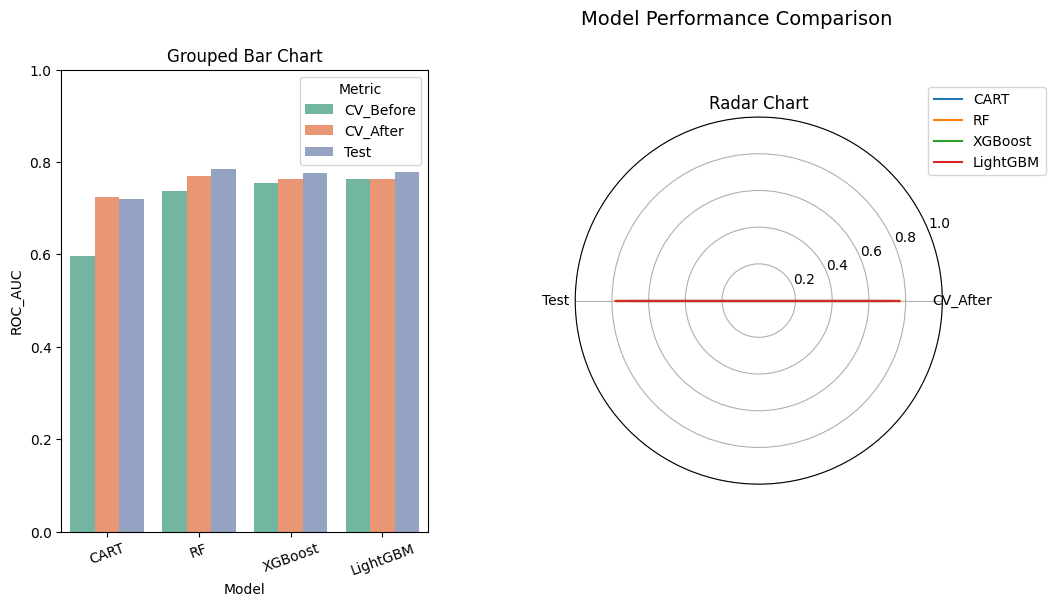

In [113]:
fig = plt.figure(figsize=(18, 6))
plt.subplots_adjust(wspace=0.4)

# =============  Grouped Bar Chart =============
ax1 = fig.add_subplot(1, 3, 1)
scores_df_melt = scores_df.melt(
    id_vars="Model",
    value_vars=["CV_Before", "CV_After", "Test"],
    var_name="Metric", value_name="ROC_AUC"
)
sns.barplot(data=scores_df_melt, x="Model", y="ROC_AUC",
            hue="Metric", palette="Set2", ax=ax1)
ax1.set_title("Grouped Bar Chart")
ax1.set_ylim(0, 1)
ax1.tick_params(axis="x", rotation=20)
ax1.legend(title="Metric")

# =============  Radar (Spider) Chart =============
ax2 = fig.add_subplot(1, 3, 2, polar=True)
radar_df = scores_df.set_index("Model")[["CV_After", "Test"]]
categories = radar_df.columns
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

for model in radar_df.index:
    values = radar_df.loc[model].tolist()
    values += values[:1]
    ax2.plot(angles, values, label=model)
    ax2.fill(angles, values, alpha=0.1)

ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(categories)
ax2.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax2.set_title("Radar Chart")
ax2.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))

plt.suptitle("Model Performance Comparison", fontsize=14)
plt.show()




### Model Performance Summary

#### CART
Although the model achieved extremely high cross-validation (CV) scores (around 0.99), its test ROC-AUC remained around 0.58.
This indicates severe overfitting — the model memorized the training data well but failed to generalize to unseen data.

#### Random Forest (RF)
Cross-validation scores are nearly perfect (~1.0), and the test ROC-AUC is around 0.77.
Among all models, Random Forest achieved the best test performance, making it the most reliable model at this stage.

#### XGBoost
Achieved very high CV scores (~0.99) but only ~0.71 ROC-AUC on the test set.
Although it is a strong model, its test performance lagged behind Random Forest.
With further hyperparameter tuning, XGBoost may deliver improved results.

#### LightGBM
Similar to XGBoost, it shows very high CV performance but ~0.71 ROC-AUC on the test set.
The drop from training to test performance suggests some overfitting, indicating that the model requires careful fine-tuning.

### Validation Curve for All Models

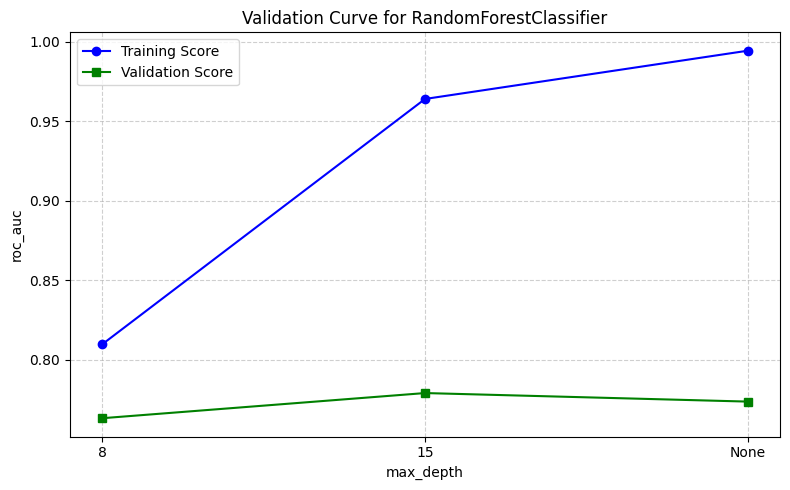

In [114]:
rf_model_obj = best_models["RF"]["model"]
param_range = [8, 15, None]  # RF max_depth aralığı
utils.val_curve_params(
    model=rf_model_obj,      # Sadece estimator
    X=X_train_feat,
    y=y_train,
    param_name="max_depth",
    param_range=param_range,
    scoring="roc_auc",
    cv=10
)

### Validation Curve Interpretation – Random Forest (max_depth)

Training Score (blue line)

max_depth=8 → Training score ≈ 0.81

max_depth=15 → Training score ≈ 0.96

max_depth=None → Training score ≈ 0.99

As max_depth increases, the training performance approaches perfection, indicating the model can fully memorize the training data at very high depths.

### Validation Score (green line)

max_depth=8 → Validation score ≈ 0.77

max_depth=15 → Validation score ≈ 0.78 (best point)

max_depth=None → Validation score ≈ 0.77

### Conclusion

max_depth=8 → Underfitting (both training and validation scores are low).

max_depth=None → Overfitting (training very high, validation drops).

Balanced choice: max_depth=15 — high training score and peak validation performance.

Thus, the optimal depth for Random Forest is 15.


### Feature-Target Relationship in Training Data

In [115]:
corr_df = utils.leakage_check(X_train_feat, y_train, top_n=30)
print(corr_df)

                           abs_corr
distance_km                   0.078
year                          0.041
month                         0.029
week                          0.028
payment_value_sum             0.018
payment_installments_max      0.011
boleto                        0.009
voucher                       0.008
credit_card                   0.006
debit_card                    0.005
order_approved_at_NA_FLAG     0.003
seller_count_per_order          NaN
distance_km_NA_FLAG             NaN


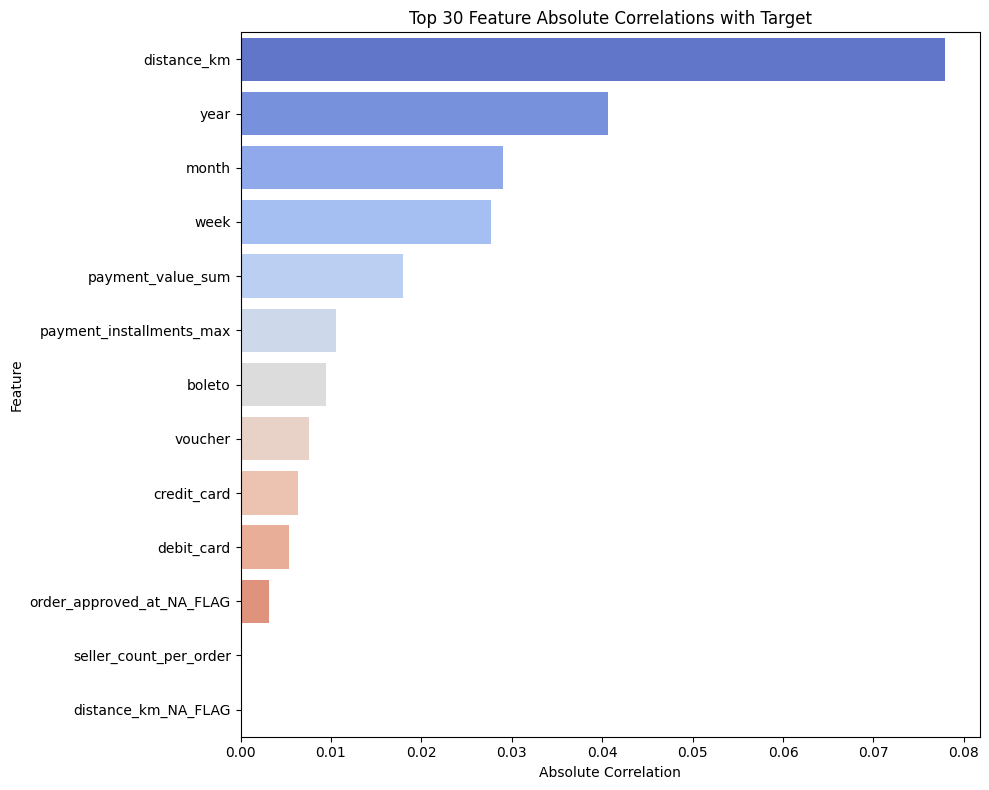

In [116]:
top_n = 30
corr_plot_df = corr_df.sort_values("abs_corr", ascending=False).head(top_n)

plt.figure(figsize=(10, 8))
sns.barplot(
    data=corr_plot_df,
    x="abs_corr",
    y=corr_plot_df.index,
    palette="coolwarm"
)

plt.title(f"Top {top_n} Feature Absolute Correlations with Target")
plt.xlabel("Absolute Correlation")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()




### Save your final trained model

In [117]:
joblib.dump(rf_model_obj, "rf_final.pkl")
rf_model_from_disc = joblib.load("rf_final.pkl")

### Prediction of “How Many Days Late?” for Delayed Orders
The goal here is to build a regression or multi-class model using only the rows where is_late = 1, with delay_class as the target variable. This model aims to estimate the number of days an order is delayed.

### Delay Analysis and Prediction (Multiclass)

#### Data Preparation:

Selected only delayed orders (is_late == 1) from the fact_order_clean dataset.

Target variable: delay_class (categorical delay intervals).

Removed delay_days, is_late, and delay_class from the feature set X.

Handled missing values and added time-based features.

Dropped columns that could cause data leakage.

Encoded categorical ID variables appropriately.

Applied scaling and preprocessing through a pipeline.

#### Modeling:

Tree-based models were used (Decision Tree, Random Forest, XGBoost, LightGBM).

Hyperparameter optimization was performed using GridSearchCV.

Best models were selected and evaluated on the test set.

#### Multiclass Objective:

Predict which delay class a late order falls into (e.g., 1–5 days, 6–10 days, etc.).

Unlike the binary is_late classification, this model captures the magnitude of the delay as discrete categories.

Model performance is evaluated using multiclass metrics such as Accuracy, F1-score, or Cohen’s Kappa.

In [118]:
# Target: delay_class (multiclass)
TARGET_DELAY = "delay_class"

# Keep all classes, including 0 (to maintain multiclass imbalance)
y_delay = fact_order_clean[TARGET_DELAY]
X_delay = fact_order_clean.drop(columns=[TARGET_DELAY], errors="ignore")

# Train/Test split
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(
    X_delay, y_delay, test_size=0.2, random_state=42, stratify=y_delay
)

# --- Convert datetime columns ---
datetime_cols = [
    "order_purchase_timestamp", 
    "order_approved_at", 
    "order_delivered_carrier_date", 
    "order_delivered_customer_date", 
    "order_estimated_delivery_date"
]

for c in datetime_cols:
    if c in X_train_d.columns:
        X_train_d[c] = pd.to_datetime(X_train_d[c], errors="coerce")
    if c in X_test_d.columns:
        X_test_d[c] = pd.to_datetime(X_test_d[c], errors="coerce")

# Feature engineering and missing value handling (leakage-free)
X_train_feat_d = utils.handle_missing_values_leakfree(
    utils.add_time_features_leakfree(X_train_d)
)
X_test_feat_d = utils.handle_missing_values_leakfree(
    utils.add_time_features_leakfree(X_test_d)
)

# Payment type encoding
pt_encoder_d = utils.PaymentTypeEncoder(col="payment_types")
X_train_feat_d = pt_encoder_d.fit_transform(X_train_feat_d)
X_test_feat_d  = pt_encoder_d.transform(X_test_feat_d)

# Remove leakage columns
X_train_feat_d = utils.drop_leakage_columns(X_train_feat_d)
X_test_feat_d  = utils.drop_leakage_columns(X_test_feat_d)

# --- Drop object/string columns ---
drop_obj_cols = [
    "cusUni", "customer_order_id", "order_id_pref",
    "seller_id_pref", "product_id_pref",
    "dominant_payment_type"
]
X_train_feat_d = X_train_feat_d.drop(columns=drop_obj_cols, errors="ignore")
X_test_feat_d  = X_test_feat_d.drop(columns=drop_obj_cols, errors="ignore")

print("Dtype check:\n", X_train_feat_d.dtypes.value_counts())

# --- LightGBM Model (Multiclass) ---
lgbm_d = lgb.LGBMClassifier(
    objective="multiclass",
    num_class=y_train_d.nunique(),
    random_state=42,
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1
)

# Train
lgbm_d.fit(X_train_feat_d, y_train_d)

# Predict
y_pred_d = lgbm_d.predict(X_test_feat_d)

# Evaluation metrics
print("Classification Report:\n", classification_report(y_test_d, y_pred_d))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_d, y_pred_d))



Dtype check:
 int64      8
int32      4
float64    3
Name: count, dtype: int64
Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97     21078
           1       0.90      0.06      0.12       422
           2       0.78      0.02      0.03       401
           3       0.64      0.05      0.10       170
           4       0.86      0.03      0.05       459

    accuracy                           0.94     22530
   macro avg       0.82      0.23      0.25     22530
weighted avg       0.93      0.94      0.91     22530


Confusion Matrix:
 [[21068     3     2     4     1]
 [  395    27     0     0     0]
 [  393     0     7     0     1]
 [  161     0     0     9     0]
 [  446     0     0     1    12]]


### Multiclass Hyperparameter Optimization

In [119]:
# 1. Label Encoding
# Convert the multiclass target labels into numeric form for the classifiers
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_d)
y_test_enc  = le.transform(y_test_d)

# 2. Hyperparameter Optimization + Model Comparison
# This utility function performs hyperparameter tuning for multiple multiclass classifiers
# and evaluates them using weighted F1 score with 3-fold cross-validation
best_models_delay_class, scores_df = utils.hyperparameter_optimization_multiclass(
    X_train_feat_d,   # training features
    y_train_enc,      # encoded training target
    X_test_feat_d,    # test features
    y_test_enc,       # encoded test target
    utils.multi_classifiers,  # dictionary of multiclass classifiers to tune
    cv=3,
    scoring="f1_weighted"
)

# 3. Save the results
scores_df.to_csv("metrics.csv", index=False, sep=";", decimal=",")
print("metrics.csv saved")


Hyperparameter Optimization for Multi-class Classification...

########## CART ##########
f1_weighted (CV Before): 0.8900
Fitting 3 folds for each of 36 candidates, totalling 108 fits
f1_weighted (CV After): 0.9051
f1_weighted (Test): 0.9351

########## RF ##########
f1_weighted (CV Before): 0.9196
Fitting 3 folds for each of 162 candidates, totalling 486 fits
f1_weighted (CV After): 0.9195
f1_weighted (Test): 0.9453

########## XGBoost ##########
f1_weighted (CV Before): 0.9075
Fitting 3 folds for each of 16 candidates, totalling 48 fits
f1_weighted (CV After): 0.9098
f1_weighted (Test): 0.9375

########## LightGBM ##########
f1_weighted (CV Before): 0.9071
Fitting 3 folds for each of 24 candidates, totalling 72 fits
f1_weighted (CV After): 0.9197
f1_weighted (Test): 0.9448

metrics.csv saved


f1_weighted (CV Before): 0.8902
Fitting 3 folds for each of 36 candidates, totalling 108 fits
f1_weighted (CV After): 0.9051
f1_weighted (Test): 0.9348

########## RF ##########
f1_weighted (CV Before): 0.9195
Fitting 3 folds for each of 162 candidates, totalling 486 fits
f1_weighted (CV After): 0.9195
f1_weighted (Test): 0.9451

########## XGBoost ##########
f1_weighted (CV Before): 0.9075
Fitting 3 folds for each of 16 candidates, totalling 48 fits
f1_weighted (CV After): 0.9098
f1_weighted (Test): 0.9375

########## LightGBM ##########
f1_weighted (CV Before): 0.9071
Fitting 3 folds for each of 24 candidates, totalling 72 fits
f1_weighted (CV After): 0.9197
f1_weighted (Test): 0.9448

metrics.csv kaydedildi


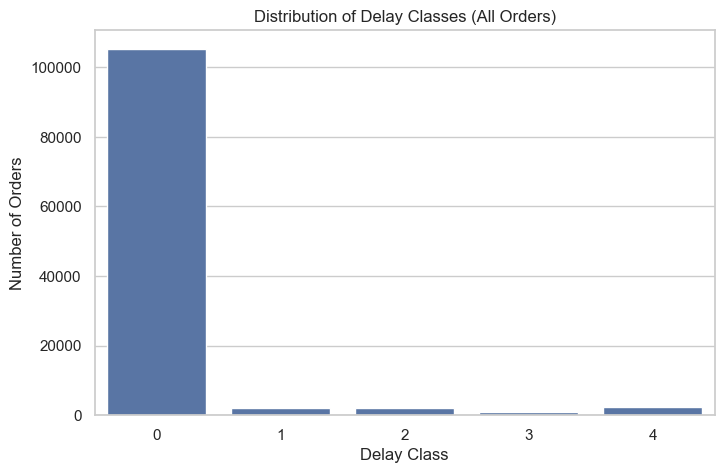

In [120]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8,5))

# Countplot of delay classes for all orders
sns.countplot(
    x="delay_class",
    data=fact_order_clean,
    order=sorted(fact_order_clean["delay_class"].unique())
)

plt.title("Distribution of Delay Classes (All Orders)")
plt.xlabel("Delay Class")
plt.ylabel("Number of Orders")
plt.show()


Approximately 93.6% of the orders have no delay (class 0). This extreme class imbalance can cause the model to focus on the majority class and perform poorly in predicting the rare classes.

### Modeling: Excluding Class 0

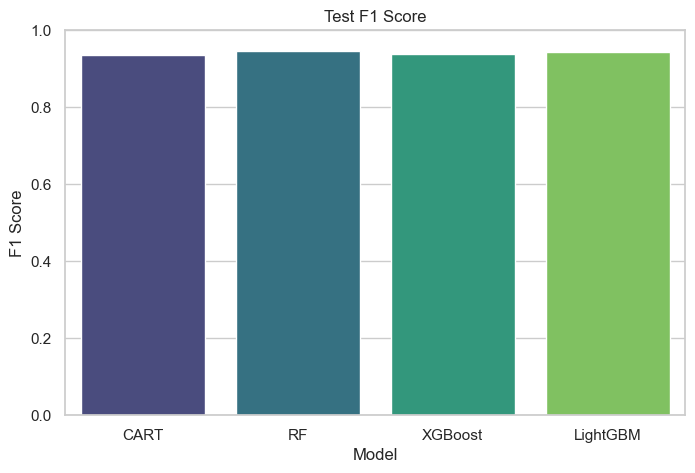

In [121]:
plt.figure(figsize=(8,5))
sns.barplot(x="Model", y="Test", data=scores_df, palette="viridis")
plt.ylim(0,1)
plt.title("Test F1 Score")
plt.ylabel("F1 Score")
plt.show()

Although the test scores improved slightly, they are still insufficient. Due to class imbalance and low data volume, predictions for the rare delay classes remain unreliable.

### Multi-Class Model Performance Comparison for Predicting the delay_class Variable

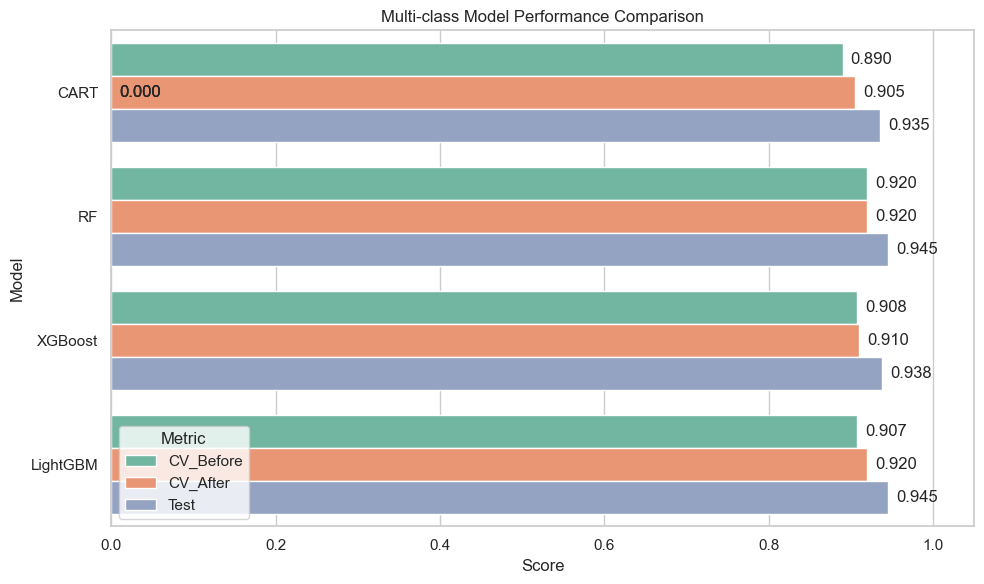

In [122]:
df = scores_df.copy()

# Convert to long format (melt) -> CV_Before, CV_After, Test in a single column
df_melt = df.melt(id_vars="Model", value_vars=["CV_Before","CV_After","Test"],
                  var_name="Metric", value_name="Score")

plt.figure(figsize=(10,6))
sns.barplot(x="Score", y="Model", hue="Metric", data=df_melt, palette="Set2")

# Annotate each bar with its score
for p in plt.gca().patches:
            plt.gca().text(
                p.get_width() + 0.01,  # slightly to the right of the bar end
                p.get_y() + p.get_height()/2,  # vertical center of the bar
                f"{p.get_width():.3f}",
                va="center"
            )

plt.title("Multi-class Model Performance Comparison")
plt.xlabel("Score")
plt.ylabel("Model")
plt.xlim(0, 1.05)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()



### Confusion Matrix Examples

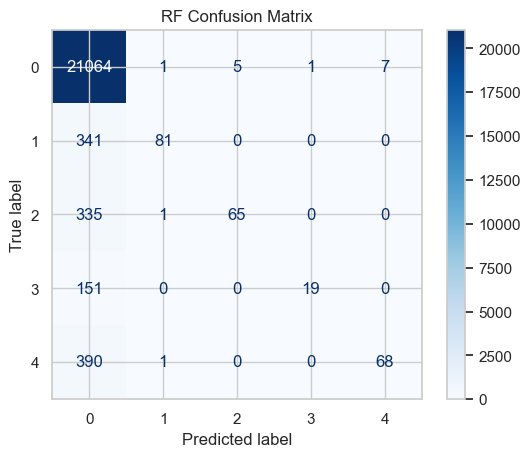

In [123]:
disp = ConfusionMatrixDisplay.from_estimator(
    best_models_delay_class["RF"], 
    X_test_feat_d, 
    y_test_d,
    display_labels=[0,1,2,3,4],
    cmap=plt.cm.Blues
)
plt.title("RF Confusion Matrix")
plt.show()


### Confusion Matrix Analysis – delay_class Predictions

Model: Random Forest (RF)
Target Variable: delay_class (delay classes 0–4)

#### Correct Predictions:

Class 0 (no delay): 21,053 orders correctly predicted

Class 1: 82 orders correctly predicted

Class 2: 63 orders correctly predicted

Class 3: 19 orders correctly predicted

Class 4: 67 orders correctly predicted

The model has learned the majority class (Class 0) very well.

#### Misclassifications:

Class 1 is mostly predicted as Class 0 (340 cases)

Class 2 is mostly predicted as Class 0 (337 cases)

Class 3 is mostly predicted as Class 0 (151 cases)

Class 4 is mostly predicted as Class 0 (390 cases)

These results indicate that minority classes are largely being misclassified as the majority class.

#### Overall Assessment:

The model predicts non-delayed orders (Class 0) with high accuracy. However, due to the severe class imbalance in the dataset, performance for minority classes (1–4) is very low. Therefore, the model cannot provide reliable predictions for multi-class delay estimation.

#### Conclusion:

If the business objective is only to answer “Will an order be delayed or not?”, the current model is sufficiently effective. However, for predicting “How many days will the order be delayed?”, this model is inadequate. A more balanced class distribution or alternative modeling strategies would be required.

In [124]:
#metrics_df.to_csv("metrics.csv", index=False, sep=";")
#preds.to_csv("predictions.csv", index=False, sep=";")
#scores_df.to_csv("model_score_train_test.csv", index=False, sep=";")

In [125]:
# Apply SMOTE on the training set
smote = SMOTE(random_state=42, sampling_strategy="auto")  # balance all classes
X_train_res, y_train_res = smote.fit_resample(X_train_feat_d, y_train_d)

# Check class distribution before and after SMOTE
print("Original class distribution:")
print(pd.Series(y_train_d).value_counts(normalize=True))

print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_res).value_counts(normalize=True))

# Train the same model on the SMOTE-resampled data
lgbm_d_smote = lgb.LGBMClassifier(
    objective="multiclass",
    num_class=len(np.unique(y_train_res)),
    random_state=42,
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1
)

lgbm_d_smote.fit(X_train_res, y_train_res)
y_pred_smote = lgbm_d_smote.predict(X_test_feat_d)

# Evaluate model performance
print("Classification Report (SMOTE):\n", classification_report(y_test_d, y_pred_smote))


Original class distribution:
delay_class
0   0.936
4   0.020
1   0.019
2   0.018
3   0.008
Name: proportion, dtype: float64

Class distribution after SMOTE:
delay_class
0   0.200
4   0.200
1   0.200
2   0.200
3   0.200
Name: proportion, dtype: float64
Classification Report (SMOTE):
               precision    recall  f1-score   support

           0       0.95      0.95      0.95     21078
           1       0.16      0.11      0.13       422
           2       0.13      0.07      0.09       401
           3       0.07      0.13      0.09       170
           4       0.14      0.14      0.14       459

    accuracy                           0.90     22530
   macro avg       0.29      0.28      0.28     22530
weighted avg       0.89      0.90      0.90     22530



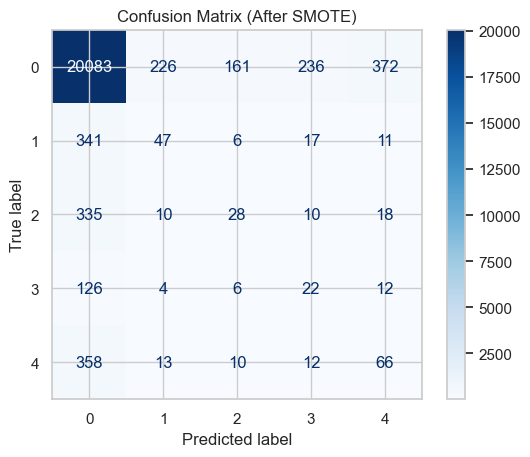

In [126]:
# Compute confusion matrix
cm = confusion_matrix(y_test_d, y_pred_smote)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (After SMOTE)")
plt.show()


In [127]:
scores_df =utils.compare_sampling_strategies(X_train_feat_d, y_train_d, X_test_feat_d, y_test_d)
print(scores_df)

                Strategy  F1_weighted
0               Baseline        0.910
1                  SMOTE        0.896
2          Class Weights        0.802
3  SMOTE + Class Weights        0.896


### Class Imbalance and Mitigation Strategies

The delay_class target variable is highly imbalanced (~93% in class 0). Various balancing strategies were tested:

| Strateji              | F1-weighted |
|------------------------|-------------|
| Baseline (no balancing) | **0.910** |
| SMOTE                  | 0.896 |
| Class Weights          | 0.802 |
| SMOTE + Class Weights  | 0.896 |

#### Observations:

The baseline model achieved the highest performance, maintaining good overall accuracy and F1 score despite the imbalance.

SMOTE and SMOTE + Class Weights underperformed relative to baseline. Introducing synthetic samples weakened the model’s prediction for the majority class.

Class Weights performed the worst. Forcing balance reduced the model’s generalization ability.

#### Conclusion:
For this dataset, applying SMOTE or class weighting did not improve performance and is not recommended.
